# Classification: Initial tinkering with E. coli iModulon data to see if we can train a CNN to classify promoters into iModulons

# Try reweighting BCE loss with class weights AND ALSO doing data augmentation

In [1]:
import copy
import pandas as pd
import numpy as np
import utils as u
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats


import altair as alt
import seaborn as sns
import torch_utils as tu

import torch
import torch.nn as nn

import random

import utils as u 
import torch_utils as tu
import models as m

from sklearn.metrics import multilabel_confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from skorch import NeuralNetRegressor,NeuralNetClassifier
from skorch.callbacks import EarlyStopping,Checkpoint,GradientNormClipping
from skorch.dataset import Dataset
from skorch.helper import predefined_split


In [2]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    #os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")


In [3]:
set_seed(46)

Random seed set as 46


## Load data

In [4]:
fname = 'ec_iMod_out/ecoli_seq_M_opFilt.tsv' 
XY = pd.read_csv(fname,sep='\t')
print(XY.shape)
display(XY.head())

loc2seq = dict([(x,z) for (x,z) in XY[['locus_tag','upstream_region']].values])

print(loc2seq['b3575'])

(2129, 99)


locus_tag  gene                                 product type  strand  start  \
0     b0005  yaaX  DUF2502 domain-containing protein YaaX  CDS       1   5233   
1     b0007  yaaJ               putative transporter YaaJ  CDS      -1   6528   
2     b0008  talB                         transaldolase B  CDS       1   8237   
3     b0009   mog       molybdopterin adenylyltransferase  CDS       1   9305   
4     b0010  satP        acetate/succinate:H(+) symporter  CDS      -1   9927   

                                     upstream_region         0         1  \
0  GGCAGAACGTGCTGATTTACCCTTGCTTTCACATAATCTGCCCGCC...  0.008229 -0.000685   
1  AGGGAGGTCAATTTGTCCGTCATGATAGTATTTCTCTTTAAACAGC...  0.008111 -0.003929   
2  ATGAAGGAGAAAAAATCTGGCATGCATATCCCTCTTATTGCCGGTC...  0.008629 -0.001270   
3  AGGGGCTATCGAACGTAAACTGTCTTACACCGGCGAAGTGAAAGCG...  0.002952  0.002053   
4  CATGGTTTGCTGCGCGGCGCGGGGCTGGGAGGCCCTGTAGGTGCGG...  0.006142  0.000884   

          2  ...        82        83        84        85        86        87  \
0 -0.005215  ... -0.006856  0.010676  0.008874  0.018497  0.000700 -0.013267   
1  0.003207  ... -0.000337 -0.010468  0.016122  0.010361 -0.003899 -0.022839   
2 -0.005664  ...  0.000394  0.007215 -0.000707 -0.012959 -0.002329  0.006391   
3 -0.002882  ... -0.009291 -0.000226  0.016013  0.002179  0.004891 -0.002365   
4  0.008166  ... -0.009214 -0.010588  0.001363  0.003979 -0.005208  0.003190   

         88        89        90        91  
0  0.015265  0.016886 -0.015319 -0.020727  
1 -0.003665 -0.001823 -0.023604 -0.012765  
2 -0.003650 -0.008537  0.002898 -0.000891  
3 -0.003490 -0.006066 -0.011982  0.011477  
4 -0.015137 -0.005784 -0.001302  0.010800  

[5 rows x 99 columns]

TCAATCAGCATCAACCCGCGAAACAGACTCTGGCTTCCGGCTGGACGCTCTTTTTCCTGCGCCATCTCGTTCTCTTTTTTTCCCATCACTTCTTTCCCCATTTTGTCGCGTCCTGATGGTAGCGCAAAGTGTGCCGTAGTTCACGATCTCGACAGATAATTTATAACCAATTGATTTTTATGTCTTTTGAAATTCATCAATCAGATTGCCTTGTTAAAAAGTGATCGATATATTTGAAATCAAGTTTCGCATATTGAAATTTTAAGCCAAAAAAGCGATCAAAAAAACAAGGAAGCCTGG


In [5]:
# get iModulon column labels
M = pd.read_csv('ec_iMod_out/iMod_download/M.csv',index_col=0)
imods = [x.strip() for x in M.columns]
imods[:5]

['0', '1', '2', '3', '4']

In [6]:
# load binarized version of M matrix
Mb = pd.read_csv('ec_iMod_out/iMod_download/gene_presence_matrix.csv',index_col=0).astype(int)
Mb.index.name='locus_tag'
Mb

0  1  2  3  4  5  6  7  8  9  ...  82  83  84  85  86  87  88  89  \
locus_tag                                ...                                   
b0002      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
b0003      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
b0004      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
b0005      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
b0006      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
...       .. .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..   
b4688      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
b4693      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
b4696_1    0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
b4696_2    0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
b4705      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   

           90  91  
locus_tag          
b0002       0   0  
b0003       0   0  
b0004       0   0  
b0005       0   0  
b0006       0   0  
...        ..  ..  
b4688       0   0  
b4693       0   0  
b4696_1     0   0  
b4696_2     0   0  
b4705       0   0  

[3923 rows x 92 columns]

In [7]:
# Convert XY into binarazed version
XYb = pd.merge(XY.drop(imods,axis=1), Mb.reset_index(),on='locus_tag')
XYb

locus_tag  gene                                          product type  \
0        b0005  yaaX           DUF2502 domain-containing protein YaaX  CDS   
1        b0007  yaaJ                        putative transporter YaaJ  CDS   
2        b0008  talB                                  transaldolase B  CDS   
3        b0009   mog                molybdopterin adenylyltransferase  CDS   
4        b0010  satP                 acetate/succinate:H(+) symporter  CDS   
...        ...   ...                                              ...  ...   
2124     b4395  ytjC                             putative phosphatase  CDS   
2125     b4396   rob   DNA-binding transcriptional dual regulator Rob  CDS   
2126     b4397  creA                      PF05981 family protein CreA  CDS   
2127     b4401  arcA  DNA-binding transcriptional dual regulator ArcA  CDS   
2128     b4403  yjtD        putative tRNA/rRNA methyltransferase YjtD  CDS   

      strand    start                                    upstream_region  0  \
0          1     5233  GGCAGAACGTGCTGATTTACCCTTGCTTTCACATAATCTGCCCGCC...  0   
1         -1     6528  AGGGAGGTCAATTTGTCCGTCATGATAGTATTTCTCTTTAAACAGC...  0   
2          1     8237  ATGAAGGAGAAAAAATCTGGCATGCATATCCCTCTTATTGCCGGTC...  0   
3          1     9305  AGGGGCTATCGAACGTAAACTGTCTTACACCGGCGAAGTGAAAGCG...  0   
4         -1     9927  CATGGTTTGCTGCGCGGCGCGGGGCTGGGAGGCCCTGTAGGTGCGG...  0   
...      ...      ...                                                ... ..   
2124       1  4633796  TGCTGTCACCATCGATGCCAGCTTCAATCGCCACCCAAAAATCAGC...  0   
2125      -1  4634440  ATACGGTGTCGACCGAACCAATCTCTTCTGCATGAGCCAATGGCCC...  0   
2126       1  4635520  CTTTCGCCGCTACATTGTCGAGCGACAGGGGCTGATCCAGATGACC...  0   
2127      -1  4639589  ACAATTGAACTTGATATATGTCAACGAAGCGTAGTTTTATTGGGTG...  0   
2128       1  4640941  TAAATGCTAGCTTTCGTCACATTATTTTAATAATCCAACTAGTTGC...  0   

      1  2  ...  82  83  84  85  86  87  88  89  90  91  
0     0  0  ...   0   0   0   0   0   0   0   0   0   0  
1     0  0  ...   0   0   0   0   0   0   0   0   0   0  
2     0  0  ...   0   0   0   0   0   0   0   0   0   0  
3     0  0  ...   0   0   0   0   0   0   0   0   0   0  
4     0  0  ...   0   0   0   0   0   0   0   0   0   0  
...  .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  
2124  0  0  ...   0   0   0   0   0   0   0   0   0   0  
2125  0  0  ...   0   0   0   0   0   0   0   0   0   0  
2126  0  0  ...   0   0   0   0   0   0   0   0   0   0  
2127  0  0  ...   0   0   0   0   0   0   0   0   0   0  
2128  0  0  ...   0   0   0   0   0   0   0   0   0   0  

[2129 rows x 99 columns]

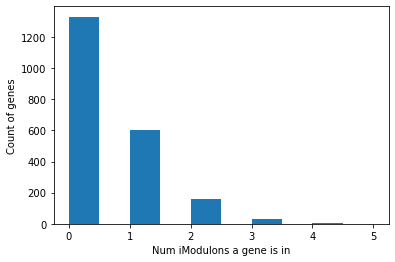

In [8]:
# distribution of ecoli genes and how many iMods they are in
plt.hist([sum(XYb.iloc[i][imods]) for i in range(XYb.shape[0])])
plt.xlabel("Num iModulons a gene is in")
plt.ylabel("Count of genes")
plt.show()

## Filter out uninformative iModulons (and genes?)
* Some iModulons have too few genes to learn from. Get rid of any less than 5. (after filtering out for genes in operons)
* Some genes aren't in any iModulons. Are those worth excluding too?

In [9]:
# make a list of imodulons above a certain threshold
thresh = 4
#mbc = dict([(Mb.iloc[i].name,sum(Mb.iloc[i])) for i in range(Mb.shape[0])])
XYim = XYb[imods]
mbc = dict([(XYim.T.iloc[i].name,sum(XYim.T.iloc[i])) for i in range(XYim.shape[1])])
imods_filt = [x for x in mbc if mbc[x]>thresh]
print("num iMods that pass:",len(imods_filt))

num iMods that pass: 58


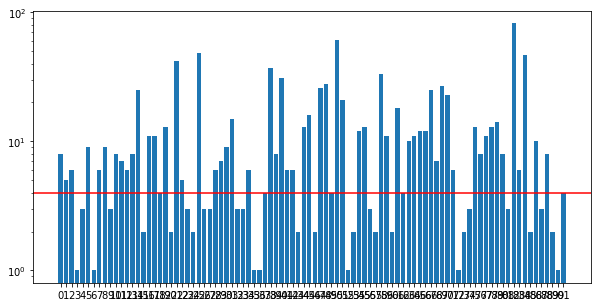

In [10]:
figure = plt.figure(figsize=(10,5))
plt.bar(imods,[mbc[x] for x in imods])
plt.axhline(thresh,c='r')
plt.yscale("log")

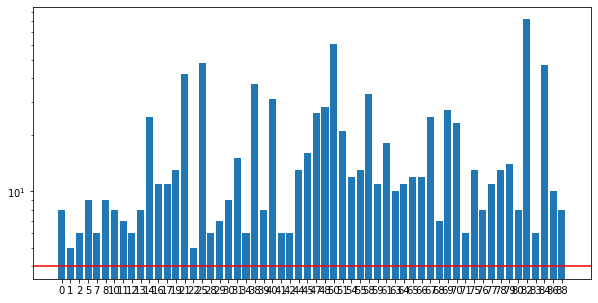

In [11]:
figure = plt.figure(figsize=(10,5))
plt.bar(imods_filt,[mbc[x] for x in imods_filt])
plt.axhline(thresh,c='r')
plt.yscale("log")


In [12]:
# these iMods seem too small to meaningfully try to predict
# (some are single-gene iMods)
imods_exclude = [x for x in mbc if mbc[x]<=thresh]
print(f"num iMods filtered out b/c fewer than {thresh} genes: {len(imods_exclude)}")

num iMods filtered out b/c fewer than 4 genes: 34


In [13]:
# drop excluded iMods and keep binary labels
XY = XYb.drop(imods_exclude,axis=1)
XY

locus_tag  gene                                          product type  \
0        b0005  yaaX           DUF2502 domain-containing protein YaaX  CDS   
1        b0007  yaaJ                        putative transporter YaaJ  CDS   
2        b0008  talB                                  transaldolase B  CDS   
3        b0009   mog                molybdopterin adenylyltransferase  CDS   
4        b0010  satP                 acetate/succinate:H(+) symporter  CDS   
...        ...   ...                                              ...  ...   
2124     b4395  ytjC                             putative phosphatase  CDS   
2125     b4396   rob   DNA-binding transcriptional dual regulator Rob  CDS   
2126     b4397  creA                      PF05981 family protein CreA  CDS   
2127     b4401  arcA  DNA-binding transcriptional dual regulator ArcA  CDS   
2128     b4403  yjtD        putative tRNA/rRNA methyltransferase YjtD  CDS   

      strand    start                                    upstream_region  0  \
0          1     5233  GGCAGAACGTGCTGATTTACCCTTGCTTTCACATAATCTGCCCGCC...  0   
1         -1     6528  AGGGAGGTCAATTTGTCCGTCATGATAGTATTTCTCTTTAAACAGC...  0   
2          1     8237  ATGAAGGAGAAAAAATCTGGCATGCATATCCCTCTTATTGCCGGTC...  0   
3          1     9305  AGGGGCTATCGAACGTAAACTGTCTTACACCGGCGAAGTGAAAGCG...  0   
4         -1     9927  CATGGTTTGCTGCGCGGCGCGGGGCTGGGAGGCCCTGTAGGTGCGG...  0   
...      ...      ...                                                ... ..   
2124       1  4633796  TGCTGTCACCATCGATGCCAGCTTCAATCGCCACCCAAAAATCAGC...  0   
2125      -1  4634440  ATACGGTGTCGACCGAACCAATCTCTTCTGCATGAGCCAATGGCCC...  0   
2126       1  4635520  CTTTCGCCGCTACATTGTCGAGCGACAGGGGCTGATCCAGATGACC...  0   
2127      -1  4639589  ACAATTGAACTTGATATATGTCAACGAAGCGTAGTTTTATTGGGTG...  0   
2128       1  4640941  TAAATGCTAGCTTTCGTCACATTATTTTAATAATCCAACTAGTTGC...  0   

      1  2  ...  76  77  78  79  80  82  83  84  86  88  
0     0  0  ...   0   0   0   0   0   0   0   0   0   0  
1     0  0  ...   0   0   0   0   0   0   0   0   0   0  
2     0  0  ...   0   0   0   0   0   0   0   0   0   0  
3     0  0  ...   0   0   0   0   0   0   0   0   0   0  
4     0  0  ...   0   0   0   0   0   0   0   0   0   0  
...  .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  
2124  0  0  ...   0   0   0   0   0   0   0   0   0   0  
2125  0  0  ...   0   0   0   0   0   0   0   0   0   0  
2126  0  0  ...   0   0   0   0   0   0   0   0   0   0  
2127  0  0  ...   0   0   0   0   0   0   0   0   0   0  
2128  0  0  ...   0   0   0   0   0   0   0   0   0   0  

[2129 rows x 65 columns]

## stratified splitting

In [14]:
def count_imod_train_test_labels(imods,ytr,yte):
    '''
    Given a train and test set of y labels, count how many trues
    are in each imodulon for each split
    '''
    # loop through each train example and count True labels for each imodulon
    imc_train = torch.tensor([0 for x in range(ytr.shape[1])])
    for s in ytr:
        imc_train += s.long()

    # loop through each test example and count True labels for each imodulon
    imc_test = torch.tensor([0 for x in range(yte.shape[1])])
    for s in yte:
        imc_test += s.long()
    
    # print warning for missing examples
    for i,im in enumerate(imods):
        if imc_train[i] == 0:
            print(f"WARNING: iMod {im} train set missing True example.")
        if imc_test[i] == 0:
            print(f"WARNING: iMod {im} test set missing True example.")
            
    # make sure the len of these imod vectors is the same
    assert len(imc_train) == len(imc_test) == len(imods)

    # stack into a pandas df, melt it, plot it
    ts = np.array(torch.stack((torch.tensor([int(x) for x in imods]), imc_train, imc_test)).T)
    imc_df = pd.DataFrame(data=ts,columns=['imod','train_count','test_count'])
    imc_df_melt = imc_df.melt(id_vars=['imod'],value_vars=['train_count','test_count'],var_name='split',value_name='count')
    
    # plot stuff
    plt.figure(figsize=(20,5))
    sns.barplot(data=imc_df_melt, x='imod', y='count', hue='split')
    #plt.yscale('log')
    
    #return imc_df_melt

def make_mt_skorch_dfs(df,seq_col='seq',target_cols=['highCu','noCu']):
    '''
    Make multi-task X,y matrix,vec for skorch fit() loop.
    '''
    seqs = list(df[seq_col].values)        
    ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in seqs])

    # number of labels = len(target_cols)
    labels = torch.tensor(list(df[target_cols].values))
    # bad dimension? fixed in model.forward for now
    
    return ohe_seqs.float(), labels.float()

In [15]:
X, y = make_mt_skorch_dfs(XY, seq_col="upstream_region",target_cols=imods_filt)
print("\nX:",X.shape)
print("y:",y.shape)


X: torch.Size([2129, 300, 4])
y: torch.Size([2129, 58])


In [16]:
from skmultilearn.model_selection import iterative_train_test_split


In [17]:
def augment_mutate(df,n,seq_col='upstream_region',mutation_rate=0.1):
    '''
    Given a dataframe of training data, augment it by adding 
    mutated versions back into the data frame
    '''
    mutation_dict = {
        'A':['C','G','T'],
        'C':['G','T','A'],
        'G':['T','A','C'],
        'T':['A','C','G']
    }
    new_rows = []
    # for each row in the original df
    for i,row in df.iterrows():
        seq = row[seq_col]
                
        # generate n mutants
        for j in range(n):
            new_row = copy.deepcopy(row)
            new_seq = list(seq)
            mutate_vec = [random.random() for x in range(len(seq))]
            
            # loop through mutation values along length of the seq
            for k in range(len(seq)):
                # if random value is below mutation rate, then make a change
                if mutate_vec[k] < mutation_rate:
                    cur_base = seq[k]
                    # select new base randomly
                    new_base = random.choice(mutation_dict[cur_base])
                    new_seq[k] = new_base
            
            new_row[seq_col] = ''.join(new_seq)
            new_row['seq_version'] = j+1
            new_rows.append(new_row.values)

    # put new rows into a df
    new_rows = pd.DataFrame(new_rows,columns=new_row.index)
    # add version to og df 
    df['seq_version'] = 0
    
    return pd.concat([df,new_rows])

def augment_only_imod_genes(df,n,imod_cols,seq_col='upstream_region',mutation_rate=0.1):
    '''
    Given a dataframe of genes to augments, selectively augment only datapoints where 
    the gene is in at least 1 iModulon. Don't both augmenting stuff that is just more
    empty examples
    '''
    df['no_imods'] = df.apply(lambda row: False if sum(row[imod_cols].values) > 0 else True,axis=1)
    
    augmented_df = augment_mutate(df[df['no_imods']==False],n,seq_col=seq_col, mutation_rate=mutation_rate)
    remaining_df = df[df['no_imods']==True]
    remaining_df['seq_version'] = 0
    
    return pd.concat([augmented_df,remaining_df])

In [18]:
# https://github.com/scikit-multilearn/scikit-multilearn/issues/206
def iterative_train_test_split_dataframe(X, y, test_size):
    # use iterative split but pass X as a df. Y is still an array?
    df_index = np.expand_dims(X.index.to_numpy(), axis=1)
    X_train, y_train, X_test, y_test = iterative_train_test_split(df_index, y, test_size = test_size)
    X_train = X.loc[X_train[:,0]]
    X_test = X.loc[X_test[:,0]]
    return X_train, y_train, X_test, y_test

In [19]:
# make n diff train test splits

def make_n_strat_splits(XYdf, ylabel, n, k, imod_cols):
    splits = {}
    # create n splits
    for i in range(n): 
        print("Creating split",i)
        # use DF form of XY
        Xfull_train_df, yfull_train, Xtest_df, ytest = iterative_train_test_split_dataframe(XYdf, ylabel, test_size = 0.2)
        Xtrain_df, ytrain, Xval_df, yval = iterative_train_test_split_dataframe(Xfull_train_df, yfull_train, test_size = 0.2)

        # augment the train set with k more samples per gene
        #Xtrain_df_aug = augment_mutate(Xtrain_df,k)
        Xtrain_df_aug = augment_only_imod_genes(Xtrain_df,k,imod_cols)

        # augment the val set with k more samples per gene
        #Xval_df_aug = augment_mutate(Xval_df,k)
        Xval_df_aug = augment_only_imod_genes(Xval_df,k,imod_cols)

        # combine train and val augmented into full train augmented (for later)
        Xfull_train_df_aug = pd.concat([Xtrain_df_aug, Xval_df_aug])

        # make into tensors
        Xfull_train,yfull_train = make_mt_skorch_dfs(Xfull_train_df, seq_col="upstream_region",target_cols=imod_cols)
        Xtest,ytest             = make_mt_skorch_dfs(Xtest_df, seq_col="upstream_region",target_cols=imod_cols)
        Xtrain, ytrain          = make_mt_skorch_dfs(Xtrain_df, seq_col="upstream_region",target_cols=imod_cols)
        Xtrain_aug, ytrain_aug  = make_mt_skorch_dfs(Xtrain_df_aug, seq_col="upstream_region",target_cols=imod_cols)
        Xval, yval              = make_mt_skorch_dfs(Xval_df, seq_col="upstream_region",target_cols=imod_cols)

        Xfull_train_aug,yfull_train_aug = make_mt_skorch_dfs(Xfull_train_df_aug, seq_col="upstream_region",target_cols=imod_cols)

        split = {
            'Xfull_train':Xfull_train,
            'yfull_train':yfull_train,
            'Xtest':Xtest,
            'ytest':ytest,
            'Xtrain':Xtrain,
            'ytrain':ytrain,
            'Xtrain_aug':Xtrain_aug,
            'ytrain_aug':ytrain_aug,
            'Xval':Xval,
            'yval':yval,
            'Xfull_train_aug':Xfull_train_aug,
            'yfull_train_aug':yfull_train_aug,
        }

        splits[i] = split
        
    return splits


In [20]:
splits = make_n_strat_splits(XY, y, 3, 10, imods_filt)

Creating split 0


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Creating split 1


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Creating split 2


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [21]:
splits[0]['Xfull_train_aug'].shape

torch.Size([7463, 300, 4])

In [22]:
splits[0]['Xfull_train'].shape

torch.Size([1703, 300, 4])

In [23]:
# pick first split for now
s = splits[0]

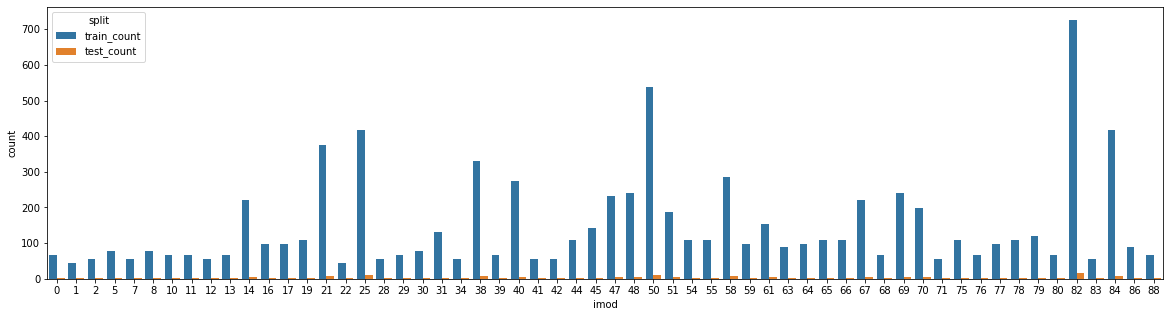

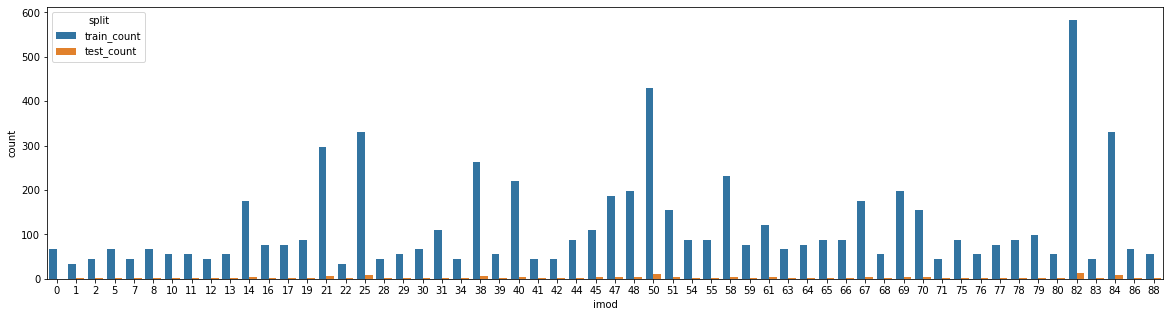

In [24]:
count_imod_train_test_labels(imods_filt,s['yfull_train_aug'],s['ytest'])
count_imod_train_test_labels(imods_filt,s['ytrain_aug'],s['yval'])

## pick some params

In [25]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [26]:
from skorch.dataset import ValidSplit

# Viz model results

In [41]:
def sk_loss_plot(nets,yscaler=5):
    '''
    Draw the train/val losses from a skorch net
    '''
    # train loss plot
    fig = plt.figure(figsize=(10,5))
    smallest_val = 999
    for i,(net,name) in enumerate(nets):
        # plot net_regr's loss trace
        train_loss = net.history[:, 'train_loss']
        valid_loss = net.history[:, 'valid_loss']
        valid_acc = net.history[:, 'valid_acc']
        
        plt.plot(train_loss,'-',color=f"C{i}", label=f"{name} Train",linewidth=1.0,alpha=0.5)
        plt.plot(valid_loss,'-',color=f"C{i}", label=f"{name} Val",linewidth=3.0,alpha=0.5)
        
        
        val_min_ep,val_min = min(enumerate(valid_loss),key = lambda t: t[1])
        plt.axhline(val_min,linestyle='--',c=f"C{i}",linewidth=0.5)
        plt.axvline(val_min_ep,linestyle='--',c=f"C{i}",linewidth=0.5)
        #plt.axhline(5,c='k')
        
        if val_min < smallest_val:
            smallest_val = val_min

    plt.ylim(0,smallest_val*yscaler)
    plt.xlabel("Epoch",fontsize=14)
    plt.ylabel("MSE Loss",fontsize=14)
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()
    
    # val acc plot
    fig2 = plt.figure(figsize=(10,2))
    for i,(net,name) in enumerate(nets):
        # plot net_regr's loss trace
        valid_acc = net.history[:, 'valid_acc']
        plt.plot(valid_acc,'--',color=f"C{i}", label=f"{name} Val Acc")
    
    plt.ylim(0,1)
    plt.xlabel("Epoch",fontsize=14)
    plt.ylabel("Valid Accuracy",fontsize=14)
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()
    
#def plot_confusion_multi(models,genes,oracle,objs):
def plot_confusion_multi(models,Xs,ys,imods):
    '''Get class predictions and plot confusion matrix'''

    for sk_model,model_name in models:
        #model.eval()
        print(f"Running {model_name}")
        
        y_preds = sk_model.predict(Xs)
        
        confs = multilabel_confusion_matrix(ys, y_preds)

        # display the matrix
        #for i in range(y_preds.shape[1]):
        for i,imod in enumerate(imods):
            mats = []
            c = confs[i]
            mats.append((c,f"raw counts"))
            # get the normalized confusino matrix
            cp = np.zeros(c.shape)
            for i,row in enumerate(c):
                rowsum = sum(row)
                for j,item in enumerate(row):
                    val = item/rowsum
                    cp[i][j] = val

            mats.append((cp,f"normed counts"))
            #print(mats)
            
            f, axes = plt.subplots(1, 2, figsize=(5, 3))#, sharey='row')
            axes = list(axes)
            #axes_list = [item for sublist in axes for item in sublist]
            
            for i,(mat,title) in enumerate(mats):
                disp = ConfusionMatrixDisplay(confusion_matrix=mat)
                #disp.plot(ax=axes_list.pop(0))
                disp.plot(ax=axes.pop(0))
                disp.ax_.set_title(title)
            
            f.suptitle(f"{model_name}, iMod {imod}",fontsize=20)
            #plt.title(f"{model_name}, iMod {imod}")
            plt.tight_layout()
            # plt.show()
        
#    return dfs


def alt_cls_summary(df):
    heat = alt.Chart(df).mark_rect().encode(
        x=alt.X('imod:O'),
        y=alt.Y('metric:O'),
        color='score:Q',
        tooltip=['metric:N','score:Q']
    ).properties(width=600)

    support = alt.Chart(df).mark_circle().encode(
        x=alt.X('imod:O',title='',axis=alt.Axis(labels=False)),
        color=alt.Color('support:Q', legend=None,scale=alt.Scale(scheme='greys')),
        size='support:Q',
        tooltip=['support']
    ).properties(width=600)

    return alt.vconcat(support,heat
        ).resolve_scale(color='independent'
        ).configure_concat(
            spacing=0
        )

def alt_cls_summary2(df):
    heat = alt.Chart(df).mark_rect().encode(
        x=alt.X('imod:O'),
        y=alt.Y('metric:O'),
        color=alt.Color('score:Q',scale=alt.Scale(domain=(0.0,1.0))),
        tooltip=['metric:N','score:Q']
    ).properties(width=600)

    support = alt.Chart(df).mark_bar().encode(
        x=alt.X('imod:O',title='',axis=alt.Axis(labels=False)),
        color=alt.Color('support:Q', legend=None,scale=alt.Scale(scheme='greys')),
        y='support:Q',
        tooltip=['support']
    ).properties(width=600,height=50)

    return alt.vconcat(support,heat
        ).resolve_scale(color='independent'
        ).configure_concat(
            spacing=0
        )

def view_cls_report(sk_model,Xs,ys,imods):
    '''
    For a given model and set of X,y examples, save and display 
    a summary of the primary classification metrics
    '''
    # get the predictions and classification report
    y_preds = sk_model.predict(Xs)
    cls_rep = classification_report(ys, y_preds,target_names=imods,output_dict=True)
    
    # conver the dict into a df for viewing
    cls_df = pd.DataFrame.from_dict(cls_rep,orient='index')
    cls_df.index.name='imod'
    cls_df = cls_df.reset_index()
    
    # drop the micro/macro average colums
    cls_df = cls_df.drop(cls_df[~cls_df['imod'].isin(imods)].index)
    # convert to int for sorting
    cls_df['imod'] = cls_df['imod'].apply(lambda x: int(x))
    
    # melt the df for altair
    cls_melt = cls_df.melt(
        id_vars=['imod','support'],
        value_vars=['precision','recall','f1-score'],
        var_name='metric',
        value_name='score')
    
    #alt_cls_summary(cls_melt)
    display(alt_cls_summary2(cls_melt))

    return cls_df
    
    
    
    

In [28]:
# nets = [
#     (net_strat_val,'Net strat with val'),
# ]

# sk_loss_plot(nets)

In [29]:
#plot_confusion_multi(nets, Xval_strat,yval_strat,imods_filt)

In [30]:
# cls_full_train_df = view_cls_report(net_strat_val,Xtrain_strat,ytrain_strat,imods_filt)
# cls_test_df = view_cls_report(net_strat_val,Xval_strat,yval_strat,imods_filt)

## BCEwithlogitsloss reweighting?

In [31]:
def get_class_counts(ys):
    y_sum = torch.tensor(np.zeros(ys.shape[1]))
    for ex in ys:
        y_sum += ex

    return y_sum

# https://discuss.pytorch.org/t/weights-in-bcewithlogitsloss/27452/11?u=crypdick
def get_pos_weights(ys):
    class_counts = get_class_counts(ys)
    pos_weights = np.ones_like(class_counts)
    neg_counts = [len(ys)-pos_count for pos_count in class_counts]  # <-- HERE 
    
    for cdx, (pos_count, neg_count) in enumerate(zip(class_counts,  neg_counts)):
        print(f"{cdx}| pos:{pos_count}  neg:{neg_count}")
        print("val:", neg_count / (pos_count + 1e-5))
        pos_weights[cdx] = neg_count / (pos_count + 1e-5)
        

    return torch.as_tensor(pos_weights, dtype=torch.float)

In [37]:
# apparently i think DNA_2CNN_2FC_Multi should still work for multi-label classification
valid_ds = Dataset(s['Xval'], s['yval'])
# weight by the distribution of examples in non-augmented training set?
bce_pos_weights = get_pos_weights(s['ytrain'])

net = NeuralNetClassifier(
    m.DNA_2CNN_2FC_Multi, # my pytorch model
    criterion=torch.nn.BCEWithLogitsLoss(pos_weight=bce_pos_weights),
    train_split=predefined_split(valid_ds), # stratified =True
    module__seq_len=300, # pass arg to pytorch model
    module__n_tasks=y.shape[1],
    module__num_filters1=128,
    module__num_filters2=64,
    module__kernel_size1=8,
    module__kernel_size2=8,
    module__conv_pool_size1=3, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 100,
    module__fc_node_num2 = 100,
    module__dropout1 = 0.2,
    module__dropout2 = 0.2,
    max_epochs=2000,
    lr=0.001,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         EarlyStopping(patience=100),
         #Checkpoint(load_best=True),
         GradientNormClipping()
     ],
    optimizer=torch.optim.Adam,
    #optimizer=torch.optim.SGD,
    iterator_train__shuffle=True,
    #train_split=predefined_split(valid_ds)
    #train_split=None
)

0| pos:6.0  neg:1356.0
val: tensor(225.9996, dtype=torch.float64)
1| pos:3.0  neg:1359.0
val: tensor(452.9985, dtype=torch.float64)
2| pos:4.0  neg:1358.0
val: tensor(339.4992, dtype=torch.float64)
3| pos:6.0  neg:1356.0
val: tensor(225.9996, dtype=torch.float64)
4| pos:4.0  neg:1358.0
val: tensor(339.4992, dtype=torch.float64)
5| pos:6.0  neg:1356.0
val: tensor(225.9996, dtype=torch.float64)
6| pos:5.0  neg:1357.0
val: tensor(271.3995, dtype=torch.float64)
7| pos:5.0  neg:1357.0
val: tensor(271.3995, dtype=torch.float64)
8| pos:4.0  neg:1358.0
val: tensor(339.4992, dtype=torch.float64)
9| pos:5.0  neg:1357.0
val: tensor(271.3995, dtype=torch.float64)
10| pos:16.0  neg:1346.0
val: tensor(84.1249, dtype=torch.float64)
11| pos:7.0  neg:1355.0
val: tensor(193.5712, dtype=torch.float64)
12| pos:7.0  neg:1355.0
val: tensor(193.5712, dtype=torch.float64)
13| pos:8.0  neg:1354.0
val: tensor(169.2498, dtype=torch.float64)
14| pos:27.0  neg:1335.0
val: tensor(49.4444, dtype=torch.float64)
15| p

In [38]:
# train with non-augmented train set
net.fit(s['Xtrain'], s['ytrain'])


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3808       0.0000        1.3519  0.2932
      2        1.3767       0.0000        1.3519  0.1589
      3        1.3766       0.0000        1.3518  0.1434
      4        1.3763       0.0000        1.3521  0.1406
      5        1.3775       0.0000        1.3519  0.1401
      6        1.3752       0.0000        1.3520  0.1396
      7        1.3740       0.0000        1.3526  0.1399
      8        1.3714       0.0000        1.3523  0.1387
      9        1.3660       0.0000        1.3532  0.1387
     10        1.3516       0.0000        1.3534  0.1387
     11        1.3258       0.0000        1.3665  0.1388
     12        1.2891       0.0000        1.4050  0.1388
     13        1.2121       0.0000        1.4050  0.1387
     14        1.1046       0.0000        1.5387  0.1394
     15        1.0284       0.0000        1.7084  0.1390
     16        0.9112       0.0

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=DNA_2CNN_2FC_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 8), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(128, 64, kernel_size=(1, 8), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.2, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=5760, out_features=100, bias=True)
      (9): ReLU()
      (10): Linear(in_features=100, out_features=100, bias=True)
      (11): ReLU()
      (12): Linear(in_features=100, out_features=58, bias=True)
    )
  ),
)

In [39]:
print("Xtrain",s["Xtrain"].shape)
print("ytrain",s["ytrain"].shape)
print("Xval",s["Xval"].shape)
print("yval",s["yval"].shape)

Xtrain torch.Size([1362, 300, 4])
ytrain torch.Size([1362, 58])
Xval torch.Size([341, 300, 4])
yval torch.Size([341, 58])


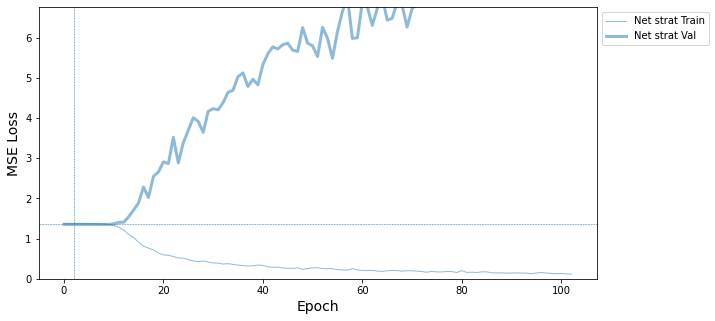

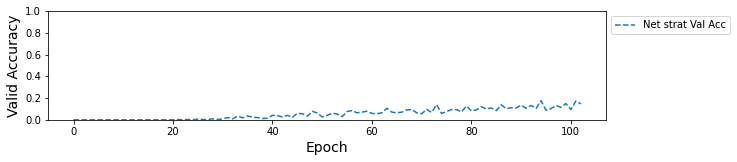

In [43]:
nets = [
    (net,'Net strat'),
    #(net_strat_bcew,'Net strat with BCE loss weights')
]

sk_loss_plot(nets)

In [44]:
cls_full_train_df = view_cls_report(net,s['Xtrain'],s['ytrain'],imods_filt)
cls_test_df = view_cls_report(net,s['Xval'],s['yval'],imods_filt)

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


alt.VConcatChart(...)

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


alt.VConcatChart(...)

# now run same params but with data augmented

In [53]:
# apparently i think DNA_2CNN_2FC_Multi should still work for multi-label classification
valid_ds = Dataset(s['Xval'], s['yval'])
# weight by the distribution of examples in AUGmented training set?
bce_pos_weights = get_pos_weights(s['ytrain_aug'])

net_da = NeuralNetClassifier(
    m.DNA_2CNN_2FC_Multi, # my pytorch model
    criterion=torch.nn.BCEWithLogitsLoss(pos_weight=bce_pos_weights),
    train_split=predefined_split(valid_ds), # stratified =True
    module__seq_len=300, # pass arg to pytorch model
    module__n_tasks=y.shape[1],
    module__num_filters1=128,
    module__num_filters2=64,
    module__kernel_size1=8,
    module__kernel_size2=8,
    module__conv_pool_size1=3, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 100,
    module__fc_node_num2 = 100,
    module__dropout1 = 0.2,
    module__dropout2 = 0.2,
    max_epochs=8000,
    lr=0.001,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         #EarlyStopping(patience=300),
         EarlyStopping(patience=3000,monitor='valid_acc',lower_is_better=False),
         #Checkpoint(load_best=True,monitor='valid_acc_best'),
         Checkpoint(monitor='valid_acc_best'),
         GradientNormClipping()
     ],
    optimizer=torch.optim.Adam,
    #optimizer=torch.optim.SGD,
    iterator_train__shuffle=True,
    #train_split=predefined_split(valid_ds)
    #train_split=None
)

0| pos:66.0  neg:5616.0
val: tensor(85.0909, dtype=torch.float64)
1| pos:33.0  neg:5649.0
val: tensor(171.1818, dtype=torch.float64)
2| pos:44.0  neg:5638.0
val: tensor(128.1363, dtype=torch.float64)
3| pos:66.0  neg:5616.0
val: tensor(85.0909, dtype=torch.float64)
4| pos:44.0  neg:5638.0
val: tensor(128.1363, dtype=torch.float64)
5| pos:66.0  neg:5616.0
val: tensor(85.0909, dtype=torch.float64)
6| pos:55.0  neg:5627.0
val: tensor(102.3091, dtype=torch.float64)
7| pos:55.0  neg:5627.0
val: tensor(102.3091, dtype=torch.float64)
8| pos:44.0  neg:5638.0
val: tensor(128.1363, dtype=torch.float64)
9| pos:55.0  neg:5627.0
val: tensor(102.3091, dtype=torch.float64)
10| pos:176.0  neg:5506.0
val: tensor(31.2841, dtype=torch.float64)
11| pos:77.0  neg:5605.0
val: tensor(72.7922, dtype=torch.float64)
12| pos:77.0  neg:5605.0
val: tensor(72.7922, dtype=torch.float64)
13| pos:88.0  neg:5594.0
val: tensor(63.5682, dtype=torch.float64)
14| pos:297.0  neg:5385.0
val: tensor(18.1313, dtype=torch.float

In [54]:
net_da.fit(s['Xtrain_aug'], s['ytrain_aug'])


  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        1.3503       0.0000        0.9310     +  0.7252
      2        1.0813       0.0000        1.0197        0.5591
      3        0.6212       0.0000        1.3615        0.5570
      4        0.4131       0.0029        1.7650     +  0.5571
      5        0.2864       0.0059        2.1955     +  0.5580
      6        0.2221       0.0205        2.1278     +  0.5573
      7        0.1813       0.0352        2.4229     +  0.5569
      8        0.1497       0.0235        2.7683        0.5600
      9        0.1210       0.0704        3.1364     +  0.5611
     10        0.0997       0.0821        3.1897     +  0.5611
     11        0.0841       0.0587        3.2581        0.5613
     12        0.0746       0.1584        3.9557     +  0.5589
     13        0.0628       0.1554        4.0727        0.5606
     14        0.0527       0.1613        4.2014     + 

    121        0.0087       0.3695        8.4960        0.5572
    122        0.0118       0.3109        7.9842        0.5576
    123        0.0059       0.3519        8.8671        0.5583
    124        0.0067       0.3460        8.3015        0.5581
    125        0.0052       0.4311        9.1687        0.5592
    126        0.0040       0.4223        9.5554        0.5586
    127        0.0032       0.4194        9.6159        0.5588
    128        0.0021       0.4047        9.9908        0.5577
    129        0.0034       0.3930        9.4506        0.5597
    130        0.0022       0.4516       10.3115        0.5590
    131        0.0036       0.4282        9.5014        0.5580
    132        0.0022       0.4223       10.0561        0.5601
    133        0.0018       0.4545       10.5994        0.5584
    134        0.0028       0.4047       10.4601        0.5584
    135        0.0029       0.4399       10.1833        0.5565
    136        0.0024       0.4047       10.2998       

    251        0.0019       0.4223       11.1084        0.5576
    252        0.0018       0.3871       10.7763        0.5571
    253        0.0059       0.3930       10.3660        0.5577
    254        0.0022       0.4106       10.8325        0.5566
    255        0.0032       0.3930       10.9643        0.5577
    256        0.0064       0.3519        9.8009        0.5577
    257        0.0077       0.3402        9.6944        0.5568
    258        0.0071       0.2903        9.3405        0.5570
    259        0.0043       0.4370       10.1175        0.5577
    260        0.0033       0.4223       10.2241        0.5593
    261        0.0038       0.3578       10.0829        0.5600
    262        0.0034       0.4311       10.1769        0.5595
    263        0.0022       0.3930       10.1138        0.5599
    264        0.0033       0.4047       10.6132        0.5601
    265        0.0122       0.2991        9.4351        0.5584
    266        0.0064       0.3871        9.4942       

    381        0.0029       0.4164       12.0923        0.5569
    382        0.0015       0.4575       12.7690        0.5552
    383        0.0026       0.4370       12.6191        0.5585
    384        0.0044       0.4604       12.7601        0.5566
    385        0.0018       0.4194       12.6603        0.5566
    386        0.0013       0.4399       13.4589        0.5579
    387        0.0023       0.4311       13.2872        0.5582
    388        0.0017       0.4399       13.7868        0.5574
    389        0.0007       0.4809       14.2220     +  0.5577
    390        0.0012       0.4399       13.6883        0.5577
    391        0.0019       0.4370       13.4238        0.5569
    392        0.0036       0.4516       13.0289        0.5572
    393        0.0041       0.4516       12.9576        0.5558
    394        0.0015       0.4780       13.5023        0.5575
    395        0.0021       0.4340       13.1660        0.5580
    396        0.0029       0.4047       13.5549       

    511        0.0020       0.4311       17.1863        0.5595
    512        0.0011       0.4340       17.2083        0.5597
    513        0.0020       0.4282       16.8642        0.5582
    514        0.0010       0.4399       17.5266        0.5574
    515        0.0018       0.4282       17.5970        0.5593
    516        0.0025       0.4340       17.0747        0.5602
    517        0.0013       0.4282       17.0014        0.5604
    518        0.0019       0.4399       17.3598        0.5591
    519        0.0042       0.4370       17.4019        0.5600
    520        0.0016       0.4164       16.4173        0.5599
    521        0.0051       0.3871       15.4069        0.5590
    522        0.0012       0.4311       16.5352        0.5567
    523        0.0013       0.4370       16.0506        0.5605
    524        0.0011       0.4311       16.4181        0.5603
    525        0.0011       0.4135       15.8523        0.5624
    526        0.0012       0.4340       16.8955       

    641        0.0016       0.4194       19.1901        0.5579
    642        0.0010       0.4516       19.3996        0.5586
    643        0.0038       0.3666       18.9582        0.5581
    644        0.0015       0.4076       19.3311        0.5578
    645        0.0048       0.3900       18.3883        0.5568
    646        0.0052       0.4106       18.7656        0.5573
    647        0.0021       0.4164       18.8118        0.5598
    648        0.0028       0.4018       19.2830        0.5602
    649        0.0065       0.4106       19.0271        0.5588
    650        0.0045       0.3754       19.2591        0.5609
    651        0.0027       0.4223       20.2961        0.5587
    652        0.0020       0.4135       19.0309        0.5590
    653        0.0033       0.3900       18.3187        0.5585
    654        0.0044       0.3988       17.9835        0.5598
    655        0.0028       0.4194       18.8545        0.5591
    656        0.0021       0.3959       17.7037       

    772        0.0051       0.3842       20.6684        0.5540
    773        0.0030       0.3783       20.2142        0.5553
    774        0.0109       0.3754       20.1390        0.5524
    775        0.0121       0.3519       19.1562        0.5544
    776        0.0051       0.3988       20.8284        0.5531
    777        0.0098       0.3343       18.6005        0.5529
    778        0.0044       0.3871       20.1412        0.5533
    779        0.0027       0.3695       20.1821        0.5534
    780        0.0020       0.3959       21.1375        0.5527
    781        0.0020       0.4106       21.4904        0.5527
    782        0.0011       0.4047       22.0450        0.5539
    783        0.0010       0.4194       21.9915        0.5542
    784        0.0016       0.4018       22.0510        0.5546
    785        0.0022       0.3842       21.9699        0.5550
    786        0.0009       0.4018       22.6578        0.5552
    787        0.0073       0.4252       24.4661       

    903        0.0056       0.3812       20.8475        0.5540
    904        0.0020       0.3871       21.5675        0.5533
    905        0.0016       0.3959       22.5599        0.5551
    906        0.0032       0.4076       22.7884        0.5535
    907        0.0051       0.4194       22.5164        0.5541
    908        0.0031       0.4135       23.8028        0.5530
    909        0.0126       0.3783       21.4929        0.5534
    910        0.0083       0.3636       19.5915        0.5534
    911        0.0042       0.3695       19.9906        0.5537
    912        0.0015       0.4106       21.8266        0.5545
    913        0.0017       0.3842       21.4416        0.5549
    914        0.0028       0.3724       20.6247        0.5545
    915        0.0020       0.3959       21.9123        0.5527
    916        0.0024       0.4018       22.3028        0.5541
    917        0.0086       0.3666       20.4964        0.5519
    918        0.0048       0.3871       19.8866       

   1034        0.0029       0.4194       29.4502        0.5539
   1035        0.0026       0.4663       31.2823        0.5544
   1036        0.0020       0.4428       30.5978        0.5536
   1037        0.0042       0.4604       31.0478        0.5549
   1038        0.0024       0.4487       29.9944        0.5536
   1039        0.0015       0.4516       31.4787        0.5554
   1040        0.0017       0.4780       32.2287        0.5535
   1041        0.0013       0.4633       31.0559        0.5652
   1042        0.0040       0.4457       29.5335        0.5588
   1043        0.0033       0.4311       27.7974        0.5541
   1044        0.0032       0.4164       28.0395        0.5551
   1045        0.0052       0.4223       28.6872        0.5535
   1046        0.0042       0.4457       30.8969        0.5546
   1047        0.0023       0.4370       31.4378        0.5553
   1048        0.0023       0.4252       31.0063        0.5598
   1049        0.0022       0.4399       30.2440       

   1165        0.0030       0.3988       29.1263        0.5567
   1166        0.0094       0.3871       28.4345        0.5583
   1167        0.0021       0.4223       29.6007        0.5605
   1168        0.0013       0.4311       31.6446        0.5599
   1169        0.0024       0.4282       32.2585        0.5586
   1170        0.0026       0.4252       30.9086        0.5577
   1171        0.0035       0.4076       30.7655        0.5580
   1172        0.0017       0.4164       31.5411        0.5586
   1173        0.0030       0.3695       29.5469        0.5589
   1174        0.0027       0.4018       31.0907        0.5571
   1175        0.0089       0.3988       32.5377        0.5589
   1176        0.0209       0.3490       24.8554        0.5572
   1177        0.0039       0.4106       27.9405        0.5603
   1178        0.0042       0.4194       28.4613        0.5571
   1179        0.0018       0.4516       29.5273        0.5573
   1180        0.0030       0.4282       30.7269       

   1296        0.0070       0.4076       41.9070        0.5577
   1297        0.0086       0.4135       39.6946        0.5597
   1298        0.0060       0.4076       38.4314        0.5574
   1299        0.0034       0.3959       40.1671        0.5592
   1300        0.0045       0.3754       40.7927        0.5574
   1301        0.0014       0.4340       43.8156        0.5568
   1302        0.0033       0.4428       43.0722        0.5564
   1303        0.0136       0.4047       38.3649        0.5568
   1304        0.0039       0.3900       36.3853        0.5592
   1305        0.0066       0.4164       36.1651        0.5605
   1306        0.0125       0.3372       32.4938        0.5599
   1307        0.0145       0.3519       35.1726        0.5586
   1308        0.0049       0.4164       38.7199        0.5605
   1309        0.0043       0.3959       39.3314        0.5588
   1310        0.0075       0.3988       39.8955        0.5572
   1311        0.0022       0.4076       40.8516       

   1427        0.0013       0.4340       43.4982        0.5571
   1428        0.0020       0.4076       40.4975        0.5564
   1429        0.0026       0.4018       42.3660        0.5571
   1430        0.0020       0.4399       46.3380        0.5576
   1431        0.0018       0.4604       48.9758        0.5576
   1432        0.0041       0.4340       46.4209        0.5559
   1433        0.0071       0.3607       37.2910        0.5579
   1434        0.0037       0.4252       42.8691        0.5577
   1435        0.0019       0.4399       45.5915        0.5568
   1436        0.0044       0.4311       43.8526        0.5595
   1437        0.0079       0.4047       38.9761        0.5568
   1438        0.0042       0.3754       38.9430        0.5583
   1439        0.0049       0.4457       45.7001        0.5560
   1440        0.0182       0.3783       38.1165        0.5556
   1441        0.0061       0.3754       37.4893        0.5554
   1442        0.0061       0.3871       38.2410       

   1558        0.0044       0.3930       46.4157        0.5629
   1559        0.0069       0.4340       52.3567        0.5591
   1560        0.0030       0.4282       56.1451        0.5606
   1561        0.0038       0.4106       52.4140        0.5584
   1562        0.0034       0.3988       51.9557        0.5603
   1563        0.0023       0.4106       54.8254        0.5614
   1564        0.0095       0.3842       49.9861        0.5603
   1565        0.0105       0.3812       47.6105        0.5621
   1566        0.0052       0.3900       47.7581        0.5598
   1567        0.0080       0.4047       46.7504        0.5620
   1568        0.0028       0.4106       51.5577        0.5600
   1569        0.0025       0.4282       54.1394        0.5590
   1570        0.0018       0.4370       54.3996        0.5594
   1571        0.0081       0.3578       45.6826        0.5611
   1572        0.0149       0.3666       43.2898        0.5609
   1573        0.0102       0.3460       40.2147       

   1689        0.0076       0.3607       50.1349        0.5598
   1690        0.0084       0.3959       55.2526        0.5598
   1691        0.0086       0.3783       52.7563        0.5590
   1692        0.0060       0.3519       47.4106        0.5585
   1693        0.0033       0.3783       51.4644        0.5594
   1694        0.0024       0.3988       54.9075        0.5592
   1695        0.0033       0.4282       57.3714        0.5608
   1696        0.0021       0.4340       58.7446        0.5614
   1697        0.0026       0.4076       60.1847        0.5600
   1698        0.0022       0.4076       61.1417        0.5581
   1699        0.0029       0.4018       55.8901        0.5605
   1700        0.0024       0.4106       59.3893        0.5610
   1701        0.0023       0.4164       60.2029        0.5593
   1702        0.0026       0.4399       61.8200        0.5622
   1703        0.0084       0.4106       57.1656        0.5599
   1704        0.0015       0.4164       60.3041       

   1820        0.0408       0.3607       55.4400        0.5608
   1821        0.0413       0.2610       40.4316        0.5595
   1822        0.0128       0.3284       48.8615        0.5580
   1823        0.0133       0.3636       48.8671        0.5607
   1824        0.0176       0.3490       52.4182        0.5607
   1825        0.0130       0.3578       53.5365        0.5600
   1826        0.0046       0.3842       58.3646        0.5596
   1827        0.0064       0.3988       62.4142        0.5572
   1828        0.0171       0.3812       58.1065        0.5582
   1829        0.0131       0.3812       55.6830        0.5592
   1830        0.0058       0.3871       55.0550        0.5651
   1831        0.0072       0.3109       45.2842        0.5611
   1832        0.0167       0.3343       50.8108        0.5582
   1833        0.0100       0.3548       54.1394        0.5569
   1834        0.0085       0.3519       57.9101        0.5583
   1835        0.0068       0.3871       64.5568       

   1951        0.0053       0.4076       60.4441        0.5639
   1952        0.0251       0.3167       43.8968        0.5637
   1953        0.0057       0.3783       53.0658        0.5643
   1954        0.0050       0.3988       59.2195        0.5635
   1955        0.0148       0.3988       56.5525        0.5623
   1956        0.0127       0.3724       50.9300        0.5638
   1957        0.0215       0.2522       42.9867        0.5631
   1958        0.0132       0.3402       50.9279        0.5644
   1959        0.0252       0.2786       44.9759        0.5648
   1960        0.0228       0.2874       39.6891        0.5646
   1961        0.0168       0.3226       45.5056        0.5626
   1962        0.0156       0.3255       49.8284        0.5670
   1963        0.0146       0.3402       46.1527        0.5637
   1964        0.0105       0.3343       48.1517        0.5649
   1965        0.0074       0.3578       49.7399        0.5652
   1966        0.0081       0.3284       49.8073       

   2082        0.0105       0.4018       62.5658        0.5599
   2083        0.0202       0.3167       48.4333        0.5611
   2084        0.0131       0.3402       54.9134        0.5602
   2085        0.0080       0.3783       59.8591        0.5608
   2086        0.0040       0.4047       63.7135        0.5607
   2087        0.0024       0.3959       62.8986        0.5597
   2088        0.0124       0.3871       53.7316        0.5589
   2089        0.0209       0.4047       65.4574        0.5594
   2090        0.0123       0.3783       62.2989        0.5638
   2091        0.0127       0.3226       48.7149        0.5622
   2092        0.0206       0.3490       51.8633        0.5625
   2093        0.0144       0.3754       51.1189        0.5612
   2094        0.0187       0.2933       41.2110        0.5604
   2095        0.0097       0.3754       53.6249        0.5589
   2096        0.0087       0.3607       53.9652        0.5588
   2097        0.0038       0.3754       59.9709       

   2213        0.0139       0.3578       60.4920        0.5593
   2214        0.0246       0.3109       50.6625        0.5591
   2215        0.0053       0.3607       62.7353        0.5588
   2216        0.0042       0.3695       62.4667        0.5600
   2217        0.0044       0.4223       71.2549        0.5585
   2218        0.0138       0.3607       63.4686        0.5590
   2219        0.0094       0.3930       71.0111        0.5626
   2220        0.0035       0.3871       69.0124        0.5600
   2221        0.0605       0.2581       37.8912        0.5593
   2222        0.0191       0.3079       53.5946        0.5587
   2223        0.0147       0.3167       59.3391        0.5589
   2224        0.0114       0.3109       56.8367        0.5589
   2225        0.0494       0.1965       37.4556        0.5588
   2226        0.0208       0.3109       52.1750        0.5582
   2227        0.0090       0.2874       45.3205        0.5593
   2228        0.0391       0.3607       55.0864       

   2344        0.0071       0.3930       69.6929        0.5596
   2345        0.0055       0.3724       64.2995        0.5594
   2346        0.0368       0.3050       51.8360        0.5594
   2347        0.0092       0.3372       58.1267        0.5605
   2348        0.0060       0.3724       62.9959        0.5600
   2349        0.0117       0.3343       55.1966        0.5595
   2350        0.0316       0.2405       39.4601        0.5604
   2351        0.0319       0.3490       53.0114        0.5594
   2352        0.0148       0.3167       54.4119        0.5591
   2353        0.0090       0.3431       58.2349        0.5595
   2354        0.0041       0.3695       63.2824        0.5594
   2355        0.0052       0.3695       64.5603        0.5608
   2356        0.0135       0.3109       48.6005        0.5611
   2357        0.0170       0.3636       59.8638        0.5615
   2358        0.0096       0.3343       53.5259        0.5607
   2359        0.0133       0.2933       47.3105       

   2475        0.0133       0.3636       66.6956        0.5602
   2476        0.0147       0.3695       65.8771        0.5601
   2477        0.0085       0.4047       73.5871        0.5597
   2478        0.0087       0.4047       81.2133        0.5595
   2479        0.0227       0.2874       48.1809        0.5607
   2480        0.0122       0.3431       60.2777        0.5596
   2481        0.0170       0.2639       50.5639        0.5601
   2482        0.0152       0.3226       62.6942        0.5597
   2483        0.0115       0.3842       66.2399        0.5597
   2484        0.0363       0.3196       44.6790        0.5598
   2485        0.0234       0.3431       59.4207        0.5606
   2486        0.0090       0.2434       51.3604        0.5602
   2487        0.0304       0.3372       58.2794        0.5603
   2488        0.0180       0.3167       61.9267        0.5600
   2489        0.0064       0.3460       69.9945        0.5598
   2490        0.0968       0.2933       49.5893       

   2606        0.0131       0.3079       51.3594        0.5600
   2607        0.0144       0.3255       54.8038        0.5602
   2608        0.0219       0.2493       45.8089        0.5603
   2609        0.0156       0.2815       52.2606        0.5607
   2610        0.0116       0.3167       53.5011        0.5605
   2611        0.0072       0.3666       61.6993        0.5610
   2612        0.0037       0.3988       68.4961        0.5606
   2613        0.0138       0.2610       39.5995        0.5606
   2614        0.0169       0.3900       55.7865        0.5606
   2615        0.0244       0.1994       38.7228        0.5607
   2616        0.0138       0.3519       62.6857        0.5605
   2617        0.0260       0.3021       52.4989        0.5618
   2618        0.0089       0.3695       61.2786        0.5613
   2619        0.0102       0.3666       59.8620        0.5607
   2620        0.0185       0.3666       53.3111        0.5613
   2621        0.0075       0.3783       57.3454       

   2737        0.0171       0.3226       43.2537        0.5600
   2738        0.0459       0.3167       38.8288        0.5603
   2739        0.0259       0.3431       45.4352        0.5606
   2740        0.0148       0.3196       36.6574        0.5606
   2741        0.0122       0.3460       41.5938        0.5611
   2742        0.0281       0.3314       39.8273        0.5609
   2743        0.0107       0.3314       39.7308        0.5607
   2744        0.0122       0.3988       45.6222        0.5608
   2745        0.0097       0.3959       45.3771        0.5612
   2746        0.0154       0.3842       44.0122        0.5614
   2747        0.0066       0.4076       45.9366        0.5621
   2748        0.0182       0.3284       34.9296        0.5614
   2749        0.0126       0.3460       35.8497        0.5628
   2750        0.0078       0.3900       41.1614        0.5621
   2751        0.0156       0.3578       44.2553        0.5614
   2752        0.0081       0.3959       51.9142       

   2868        0.0115       0.3724       33.9102        0.5622
   2869        0.0397       0.2815       31.9814        0.5620
   2870        0.0120       0.3519       34.9554        0.5615
   2871        0.0091       0.4076       42.5296        0.5620
   2872        0.0171       0.3636       21.3023        0.5615
   2873        0.0305       0.4106       28.5671        0.5617
   2874        0.0198       0.4223       30.1555        0.5618
   2875        0.0185       0.4018       29.7467        0.5621
   2876        0.0230       0.4018       32.1331        0.5615
   2877        0.0075       0.4282       37.8043        0.5616
   2878        0.0176       0.3519       24.5067        0.5617
   2879        0.0170       0.3695       29.3345        0.5612
   2880        0.0152       0.3724       33.2460        0.5620
   2881        0.0175       0.3754       34.7026        0.5620
   2882        0.0223       0.3636       27.3730        0.5622
   2883        0.0175       0.3548       24.0012       

   2999        0.0111       0.4106       31.9476        0.5626
   3000        0.0233       0.4135       25.8939        0.5646
   3001        0.0404       0.4076       22.7373        0.5619
   3002        0.0225       0.4194       25.0139        0.5615
   3003        0.0301       0.4340       19.1799        0.5614
   3004        0.0215       0.3636       27.5137        0.5617
   3005        0.0290       0.4106       34.2694        0.5615
   3006        0.0417       0.3636       22.5263        0.5620
   3007        0.0668       0.4076       27.6414        0.5623
   3008        0.0486       0.4516       20.4408        0.5617
   3009        0.0154       0.4751       27.7557        0.5622
   3010        0.0121       0.4428       28.5242        0.5623
   3011        0.0231       0.4223       25.2231        0.5618
   3012        0.0128       0.4164       29.0620        0.5625
   3013        0.0106       0.4516       31.9552        0.5620
   3014        0.0135       0.4575       29.8493       

   3129        0.0128       0.4751       31.0475        0.5566
   3130        0.0576       0.4897       25.7710        0.5577
   3131        0.0244       0.4721       29.3538        0.5568
   3132        0.0335       0.3988       32.7950        0.5592
   3133        0.0570       0.4370       29.1267        0.5578
   3134        0.0662       0.4663       18.9795        0.5557
   3135        0.0196       0.4751       24.3129        0.5556
   3136        0.0201       0.3460       23.8210        0.5556
   3137        0.0254       0.4076       21.8126        0.5558
   3138        0.0581       0.4868       20.4376        0.5556
   3139        0.0211       0.5132       23.8097     +  0.5564
   3140        0.0537       0.4340       19.5609        0.5583
   3141        0.0285       0.4311       25.2553        0.5567
   3142        0.0600       0.4780       17.2975        0.5567
   3143        0.0631       0.4252       19.3168        0.5581
   3144        0.0281       0.4106       21.6200       

   3259        0.0366       0.4692       17.6176        0.5564
   3260        0.0282       0.5367       21.5724     +  0.5565
   3261        0.0247       0.4399       16.0425        0.5585
   3262        0.0206       0.4780       19.4791        0.5571
   3263        0.0130       0.4721       21.9072        0.5566
   3264        0.0633       0.3783       19.9207        0.5575
   3265        0.0315       0.4106       24.1921        0.5564
   3266        0.0486       0.4370       16.9540        0.5565
   3267        0.0183       0.4897       23.8230        0.5568
   3268        0.0251       0.4018       15.5193        0.5574
   3269        0.0275       0.4370       16.8900        0.5565
   3270        0.0293       0.4545       19.5458        0.5563
   3271        0.0720       0.4839       17.1254        0.5570
   3272        0.0440       0.4370       16.6024        0.5566
   3273        0.0565       0.5073       20.7515        0.5579
   3274        0.0178       0.5132       19.8213       

   3389        0.0414       0.4692       19.4000        0.5574
   3390        0.0187       0.5103       23.1802        0.5577
   3391        0.0618       0.4047       13.1237        0.5572
   3392        0.0383       0.4663       12.4646        0.5573
   3393        0.0500       0.5337       15.3168        0.5565
   3394        0.0318       0.5161       17.4982        0.5570
   3395        0.0199       0.5191       15.9769        0.5569
   3396        0.0179       0.5249       19.0807        0.5567
   3397        0.0203       0.5425       18.8835        0.5567
   3398        0.0080       0.5396       20.1944        0.5567
   3399        0.0177       0.5132       18.7020        0.5577
   3400        0.0262       0.5103       18.1996        0.5571
   3401        0.0203       0.5103       16.6985        0.5566
   3402        0.0174       0.5015       16.7293        0.5569
   3403        0.0441       0.5103       17.1753        0.5574
   3404        0.0185       0.4927       16.7599       

   3519        0.0774       0.5191       15.5705        0.5641
   3520        0.0450       0.5220       17.5850        0.5640
   3521        0.0401       0.4897       15.9774        0.5648
   3522        0.0119       0.5073       19.1577        0.5641
   3523        0.0145       0.5367       19.1592        0.5659
   3524        0.0134       0.5484       21.0666        0.5643
   3525        0.0419       0.4927       14.7817        0.5647
   3526        0.0510       0.5455       17.2948        0.5649
   3527        0.0566       0.4839       14.1624        0.5656
   3528        0.0267       0.5367       16.8631        0.5656
   3529        0.0247       0.4927       18.2271        0.5655
   3530        0.0067       0.5220       20.7188        0.5645
   3531        0.0603       0.5279       15.8059        0.5639
   3532        0.0164       0.5073       18.1553        0.5642
   3533        0.0092       0.5337       21.3115        0.5643
   3534        0.0671       0.5220       16.2490       

   3650        0.0173       0.5367       17.6325        0.5644
   3651        0.0176       0.5073       15.9780        0.5639
   3652        0.0206       0.5191       16.5575        0.5640
   3653        0.0085       0.5308       18.6330        0.5639
   3654        0.0257       0.5191       15.7932        0.5636
   3655        0.0812       0.4751       10.5840        0.5639
   3656        0.0277       0.5308       16.8138        0.5634
   3657        0.0100       0.5572       19.1156        0.5634
   3658        0.0228       0.5367       16.7964        0.5642
   3659        0.1128       0.5220       11.1736        0.5640
   3660        0.0620       0.5396       20.1098        0.5641
   3661        0.0529       0.5249       14.9263        0.5629
   3662        0.0382       0.5161       14.4160        0.5640
   3663        0.2644       0.3783        5.7769        0.5643
   3664        0.1382       0.5161       10.3483        0.5641
   3665        0.0848       0.5279       11.6048       

   3780        0.0322       0.5249       15.7306        0.5614
   3781        0.0148       0.5484       19.1426        0.5613
   3782        0.0613       0.5249       16.1801        0.5612
   3783        0.0949       0.5191       12.9250        0.5612
   3784        0.0563       0.5484       15.9949        0.5618
   3785        0.0328       0.4751       11.9576        0.5615
   3786        0.0324       0.4575       12.3935        0.5617
   3787        0.0579       0.5630       17.4819        0.5614
   3788        0.0188       0.5572       19.9588        0.5620
   3789        0.0234       0.5572       15.3977        0.5618
   3790        0.0196       0.5572       17.5449        0.5617
   3791        0.0118       0.5513       20.0587        0.5615
   3792        0.1179       0.4663        9.3280        0.5633
   3793        0.1212       0.5191       16.7792        0.5622
   3794        0.0438       0.5015       15.7819        0.5625
   3795        0.0244       0.5249       17.7524       

   3910        0.5973       0.5630        5.1633        0.5617
   3911        0.1680       0.5132       16.0819        0.5621
   3912        0.0872       0.5513       14.2260        0.5618
   3913        0.1129       0.5279       11.7269        0.5612
   3914        0.0384       0.5367       16.8689        0.5615
   3915        0.0894       0.5425       11.3464        0.5617
   3916        0.1492       0.5249        6.9989        0.5616
   3917        0.0829       0.5132        8.5657        0.5619
   3918        0.0248       0.5543       16.7902        0.5616
   3919        0.0332       0.5689       18.9593        0.5617
   3920        0.0846       0.5455        7.9196        0.5623
   3921        0.0766       0.5601       13.3722        0.5613
   3922        0.0620       0.5513        2.7715        0.5631
   3923        0.0692       0.5425       13.0940        0.5617
   3924        0.0323       0.5455       18.0068        0.5613
   3925        0.0236       0.5161       14.9356       

   4041        0.0448       0.3754        9.8720        0.5626
   4042        0.0896       0.2669        6.1619        0.5617
   4043        0.0563       0.5367       13.4978        0.5619
   4044        0.0778       0.3196        5.8696        0.5618
   4045        0.0433       0.5073       11.8687        0.5619
   4046        0.0217       0.3754        8.5481        0.5623
   4047        0.0438       0.5073       12.0927        0.5623
   4048        0.0186       0.5103       12.4695        0.5630
   4049        0.0199       0.5073       13.4073        0.5621
   4050        0.0264       0.4956       10.5872        0.5620
   4051        0.0397       0.3284        5.6977        0.5624
   4052        0.0609       0.4516       10.4725        0.5620
   4053        0.0291       0.5308       14.4124        0.5614
   4054        0.0325       0.4604       12.3042        0.5615
   4055        0.0484       0.3724        6.2577        0.5616
   4056        0.0537       0.5367       13.7979       

   4171        0.0566       0.0293       15.5737        0.5629
   4172        0.0989       0.5073       12.0743        0.5635
   4173        0.1357       0.0674        1.5891        0.5626
   4174        0.0630       0.2757       10.0107        0.5629
   4175        0.1175       0.3871        7.5289        0.5621
   4176        0.0670       0.4370       12.0008        0.5631
   4177        0.0910       0.4076        7.3543        0.5636
   4178        0.1686       0.0264        7.3995        0.5624
   4179        0.0451       0.0352        9.0205        0.5623
   4180        0.0881       0.2375        5.0360        0.5627
   4181        0.0928       0.2551        6.7847        0.5657
   4182        0.0538       0.5132       16.0075        0.5652
   4183        0.1286       0.2111        5.4997        0.5649
   4184        0.1078       0.3988       11.1567        0.5666
   4185        0.0281       0.3607        9.6532        0.5668
   4186        0.0658       0.4604       11.5288       

   4302        0.0474       0.4370       12.2564        0.5652
   4303        0.0950       0.3842        9.9873        0.5658
   4304        0.0390       0.3871        9.7926        0.5652
   4305        0.1316       0.4487       11.3145        0.5658
   4306        0.1130       0.1408        5.5891        0.5656
   4307        0.1434       0.3724       12.4799        0.5654
   4308        0.0495       0.4340       12.5786        0.5655
   4309        0.0785       0.2023        4.3978        0.5658
   4310        0.1592       0.2287        4.3641        0.5655
   4311        0.0868       0.4692       14.9394        0.5662
   4312        0.0748       0.2610        8.6254        0.5656
   4313        0.0357       0.3988       13.9839        0.5656
   4314        0.0401       0.3314       10.0928        0.5664
   4315        0.0308       0.4252       14.9593        0.5652
   4316        0.0840       0.2581        5.4675        0.5676
   4317        0.1130       0.1144        3.0774       

   4433        0.1163       0.5103        4.9619        0.5657
   4434        0.0422       0.3548       15.1599        0.5665
   4435        0.0458       0.5249        5.6880        0.5654
   4436        0.1471       0.5601        5.0413        0.5653
   4437        0.0718       0.5367        7.5167        0.5648
   4438        0.0535       0.5543       10.3024        0.5655
   4439        0.0513       0.5484        3.9975        0.5662
   4440        0.0550       0.5484        9.6551        0.5669
   4441        0.0366       0.5279       16.8905        0.5657
   4442        0.0372       0.5337       15.1455        0.5660
   4443        0.0601       0.5630       10.0263        0.5668
   4444        0.0567       0.5601        9.9526        0.5683
   4445        0.0386       0.5543        6.6525        0.5738
   4446        0.3419       0.5748        1.0279        0.5802
   4447        0.2709       0.5484        2.4544        0.5657
   4448        0.0840       0.5161        4.4088       

   4563        0.0276       0.3724       16.4351        0.5627
   4564        0.1709       0.1877        4.6810        0.5637
   4565        0.1168       0.1613        8.5443        0.5630
   4566        0.0655       0.2287        8.2698        0.5638
   4567        0.1221       0.2669        9.9046        0.5638
   4568        0.0456       0.4018       15.8335        0.5636
   4569        0.0376       0.3490       14.1693        0.5634
   4570        0.1010       0.0411        1.1450        0.5630
   4571        0.1463       0.0499        1.1958        0.5638
   4572        0.0969       0.1613        5.4241        0.5643
   4573        0.1572       0.0528        2.1808        0.5647
   4574        0.0726       0.1496        5.6377        0.5643
   4575        0.0682       0.0645        2.3021        0.5645
   4576        0.0368       0.1642        6.2283        0.5631
   4577        0.0393       0.1232        4.4339        0.5633
   4578        0.0364       0.1935        5.6089       

   4694        0.2294       0.5425        3.4266        0.5643
   4695        0.6923       0.5777        1.1379        0.5650
   4696        1.3578       0.0323        1.1159        0.5637
   4697        0.4771       0.0323        1.1223        0.5649
   4698        0.2232       0.0352        1.1758        0.5645
   4699        0.1427       0.0323        1.1686        0.5636
   4700        0.2456       0.0323        1.2003        0.5644
   4701        0.1653       0.0323        1.1010        0.5643
   4702        0.0995       0.0323        1.1054        0.5641
   4703        0.1045       0.0323        1.1057        0.5634
   4704        0.0904       0.0323        1.1454        0.5639
   4705        0.0795       0.0323        1.2340        0.5642
   4706        0.0658       0.0323        1.3107        0.5639
   4707        0.0480       0.0323        1.3084        0.5651
   4708        0.0519       0.0323        1.2239        0.5643
   4709        0.0791       0.0323        1.1278       

   4825        0.1323       0.5777        1.1725        0.5646
   4826        0.0703       0.5689        1.2768        0.5652
   4827        0.0674       0.5660        1.1763        0.5660
   4828        0.0516       0.5630        1.1927        0.5642
   4829        0.0797       0.5689        1.1728        0.5639
   4830        0.0557       0.5513        1.2433        0.5643
   4831        0.0614       0.5718        1.1758        0.5641
   4832        0.0780       0.5513        1.3503        0.5645
   4833        0.1273       0.5718        1.1764        0.5645
   4834        0.0699       0.5601        1.2105        0.5641
   4835        0.0379       0.5513        1.2345        0.5645
   4836        0.0805       0.5513        1.2618        0.5644
   4837        0.6350       0.5748        1.1939        0.5647
   4838        0.2942       0.5718        1.1902        0.5643
   4839        0.2118       0.5660        1.1840        0.5643
   4840        0.1408       0.5630        1.1725       

   4955        0.0658       0.0323        2.8646        0.5659
   4956        0.1158       0.0323        1.5397        0.5669
   4957        0.1227       0.0352        1.4481        0.5687
   4958        0.0549       0.0323        2.5661        0.5687
   4959        0.2620       0.0323        1.2455        0.5685
   4960        0.1442       0.0323        1.5450        0.5683
   4961        0.2874       0.0352        1.2447        0.5685
   4962        0.2376       0.0323        1.4434        0.5688
   4963        0.0972       0.0323        1.8313        0.5688
   4964        0.1171       0.0323        1.6200        0.5673
   4965        0.0654       0.0323        1.8836        0.5677
   4966        0.0565       0.0352        2.3395        0.5685
   4967        0.0557       0.0323        1.6975        0.5676
   4968        0.0438       0.0323        1.9088        0.5678
   4969        0.1029       0.0352        1.3133        0.5693
   4970        0.0517       0.5660        1.3303       

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=DNA_2CNN_2FC_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 8), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(128, 64, kernel_size=(1, 8), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.2, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=5760, out_features=100, bias=True)
      (9): ReLU()
      (10): Linear(in_features=100, out_features=100, bias=True)
      (11): ReLU()
      (12): Linear(in_features=100, out_features=58, bias=True)
    )
  ),
)

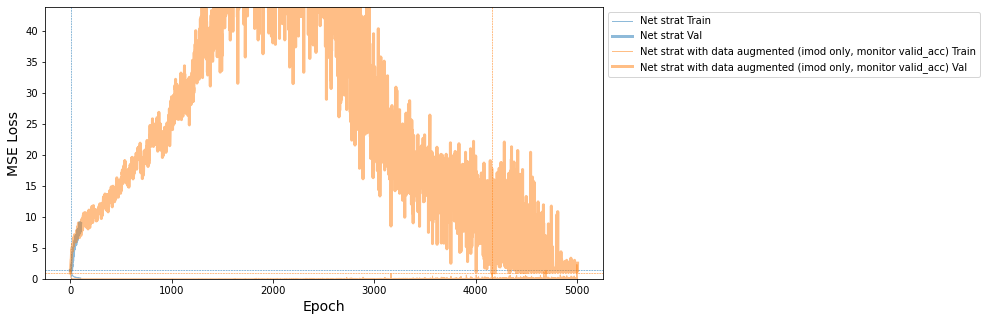

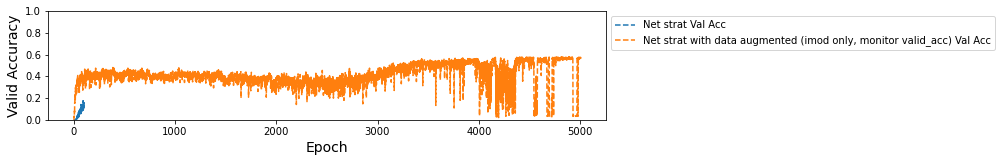

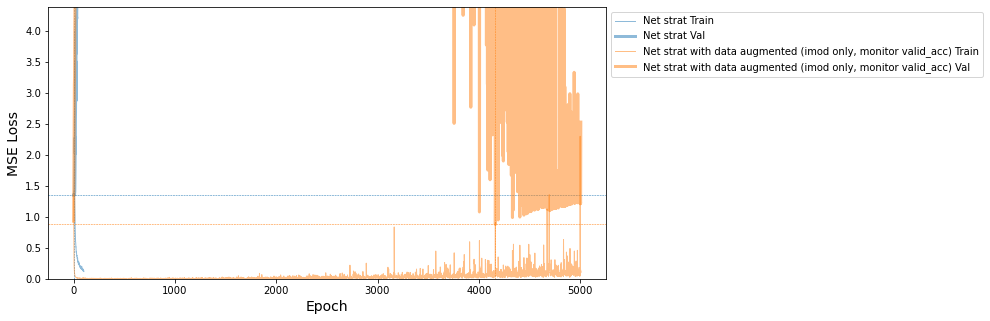

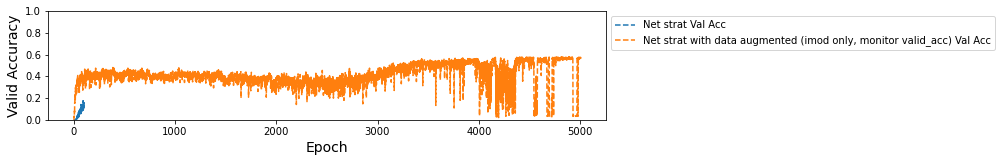

In [58]:
nets = [
    (net,'Net strat'),
    #(net_da,'Net strat with data augmented (imod only)'),
    (net_da,'Net strat with data augmented (imod only, monitor valid_acc)')
]

sk_loss_plot(nets,yscaler=50)
sk_loss_plot(nets,yscaler=5)

In [59]:
cls_full_train_df = view_cls_report(net_da,s['Xtrain_aug'],s['ytrain_aug'],imods_filt)
cls_test_df = view_cls_report(net_da,s['Xval'],s['yval'],imods_filt)

alt.VConcatChart(...)

alt.VConcatChart(...)

In [60]:
# keep going....?
net_da.partial_fit(s['Xtrain_aug'], s['ytrain_aug'], epochs=1000)


   5010        0.0675       0.5630        2.1703        0.7090
   5011        0.0904       0.5601        1.6786        0.5654
   5012        0.8856       0.5718        1.2256        0.5677
   5013        0.3667       0.5718        1.2270        0.5641
   5014        0.2043       0.5748        1.2276        0.5656
   5015        0.1748       0.0323        1.2425        0.5643
   5016        0.1360       0.0352        1.2450        0.5632
   5017        0.1265       0.0352        1.2424        0.5634
   5018        0.0896       0.0323        1.2418        0.5637
   5019        0.1074       0.0352        1.2665        0.5644
   5020        0.1041       0.0352        1.2378        0.5644
   5021        0.1066       0.0323        1.2320        0.5654
   5022        0.0985       0.0323        1.2346        0.5652
   5023        0.0823       0.0323        1.2341        0.5642
   5024        0.2032       0.0323        1.2329        0.5659
   5025        0.1485       0.0323        1.2340       

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=DNA_2CNN_2FC_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 8), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(128, 64, kernel_size=(1, 8), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.2, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=5760, out_features=100, bias=True)
      (9): ReLU()
      (10): Linear(in_features=100, out_features=100, bias=True)
      (11): ReLU()
      (12): Linear(in_features=100, out_features=58, bias=True)
    )
  ),
)

In [61]:
cls_full_train_df = view_cls_report(net_da,s['Xtrain_aug'],s['ytrain_aug'],imods_filt)
cls_test_df = view_cls_report(net_da,s['Xval'],s['yval'],imods_filt)

alt.VConcatChart(...)

alt.VConcatChart(...)

In [62]:
# keep going....?
net_da.partial_fit(s['Xtrain_aug'], s['ytrain_aug'], epochs=1000)


   5037        0.1312       0.0323        1.2447        0.7090
   5038        0.1280       0.0323        1.2504        0.5648
   5039        0.0932       0.0323        1.2442        0.5631
   5040        0.0821       0.0323        1.3367        0.5638
   5041        0.0968       0.0323        1.6194        0.5657
   5042        0.0649       0.0323        1.8867        0.5640
   5043        0.1045       0.0323        1.4175        0.5634
   5044        0.0855       0.0323        1.2361        0.5634
   5045        0.0665       0.0352        1.2382        0.5635
   5046        0.0561       0.0323        1.2743        0.5642
   5047        0.1301       0.0323        1.2755        0.5649
   5048        0.1235       0.0323        1.2474        0.5654
   5049        0.1896       0.0323        1.2464        0.5650
   5050        0.1707       0.0352        1.6639        0.5642
   5051        0.0842       0.0323        2.3623        0.5643
   5052        0.1200       0.0323        1.2478       

   5168        0.0568       0.0352        1.6079        0.5644
   5169        0.2891       0.0323        1.2826        0.5643
   5170        0.0689       0.0323        1.2991        0.5643
   5171        0.1376       0.0323        1.2916        0.5641
   5172        0.0620       0.0293        1.8239        0.5645
   5173        0.1052       0.0323        1.3002        0.5650
   5174        0.0585       0.0323        1.3802        0.5641
   5175        0.1077       0.0323        1.2906        0.5643
   5176        0.0745       0.0323        2.1315        0.5647
   5177        0.0869       0.0323        1.8421        0.5671
   5178        0.1180       0.0352        1.5081        0.5691
   5179        0.0863       0.0323        1.5028        0.5695
   5180        0.0619       0.0293        1.2980        0.5691
   5181        0.1251       0.0293        1.7837        0.5680
   5182        0.1364       0.0323        1.2932        0.5686
   5183        0.2051       0.0323        1.5528       

   5299        0.0671       0.0323        1.5487        0.5662
   5300        0.3506       0.0323        1.3055        0.5661
   5301        0.2320       0.0293        1.3090        0.5662
   5302        0.1703       0.0323        1.3021        0.5660
   5303        0.1247       0.0293        1.3045        0.5655
   5304        0.0680       0.0323        1.3727        0.5650
   5305        0.1086       0.0323        1.3389        0.5652
   5306        0.1212       0.0323        1.3010        0.5655
   5307        0.1781       0.0323        1.2906        0.5689
   5308        0.1310       0.0323        1.2849        0.5681
   5309        0.1473       0.0323        1.3252        0.5668
   5310        0.1714       0.0323        1.3011        0.5666
   5311        0.1523       0.0323        1.2843        0.5678
   5312        0.1304       0.0323        1.2868        0.5711
   5313        0.0851       0.0323        1.2876        0.5660
   5314        0.1583       0.0323        1.6656       

   5430        0.0626       0.0323        1.3098        0.5633
   5431        0.0571       0.0323        1.3123        0.5630
   5432        0.0540       0.0323        1.8448        0.5635
   5433        0.0941       0.0323        1.7590        0.5630
   5434        0.0504       0.0323        2.3711        0.5628
   5435        0.1207       0.0323        2.2106        0.5628
   5436        0.1638       0.0323        1.3154        0.5632
   5437        0.0822       0.0323        1.3331        0.5628
   5438        0.0537       0.0323        1.3002        0.5635
   5439        0.0585       0.0323        1.3372        0.5628
   5440        0.0479       0.0323        1.4984        0.5627
   5441        0.0462       0.0323        1.3150        0.5628
   5442        0.0777       0.0323        1.3295        0.5634
   5443        0.1650       0.0323        1.3231        0.5627
   5444        0.0649       0.0323        1.3267        0.5627
   5445        0.0447       0.0323        1.3106       

   5561        0.1155       0.0323        1.3040        0.5640
   5562        0.0873       0.0323        1.4716        0.5625
   5563        0.0733       0.0323        1.6453        0.5673
   5564        0.0724       0.0323        1.3073        0.5660
   5565        0.1766       0.0323        1.3059        0.5659
   5566        0.4271       0.0323        1.3046        0.5667
   5567        0.1918       0.0323        1.3119        0.5661
   5568        0.1250       0.0323        1.3099        0.5662
   5569        0.0751       0.0323        1.3089        0.5664
   5570        0.0634       0.0323        1.3107        0.5663
   5571        0.0829       0.0323        1.3061        0.5664
   5572        0.1760       0.0323        1.3056        0.5664
   5573        0.4363       0.0323        1.3024        0.5666
   5574        0.3365       0.0323        1.3015        0.5659
   5575        0.2379       0.0323        1.5488        0.5656
   5576        0.1362       0.0323        1.3056       

   5692        0.1754       0.0323        1.2910        0.5662
   5693        0.1206       0.0323        1.2936        0.5660
   5694        0.0645       0.0323        1.2941        0.5668
   5695        0.1100       0.0323        1.5140        0.5664
   5696        0.0952       0.0323        1.3195        0.5662
   5697        0.1155       0.0323        1.2966        0.5668
   5698        0.0878       0.0323        1.5764        0.5665
   5699        0.0670       0.0323        2.0606        0.5665
   5700        0.2891       0.0323        1.3013        0.5668
   5701        0.1747       0.0323        1.3086        0.5661
   5702        0.1019       0.0323        1.3432        0.5674
   5703        0.1156       0.0323        1.3053        0.5664
   5704        0.0585       0.0323        1.2911        0.5657
   5705        0.0704       0.0323        1.5439        0.5663
   5706        0.0685       0.0323        1.3370        0.5661
   5707        0.0951       0.0323        1.4952       

   5823        0.1519       0.0323        1.3296        0.5668
   5824        0.1296       0.0323        1.6565        0.5672
   5825        0.1264       0.0323        1.2991        0.5665
   5826        0.1849       0.0323        2.1244        0.5675
   5827        0.1395       0.0323        1.7797        0.5670
   5828        0.1226       0.0323        1.6966        0.5673
   5829        0.1354       0.0323        1.3151        0.5667
   5830        0.0829       0.0323        1.3015        0.5686
   5831        0.2493       0.0323        1.3030        0.5683
   5832        0.1406       0.0323        1.2998        0.5675
   5833        0.1282       0.0323        1.3001        0.5667
   5834        0.0860       0.0323        1.3201        0.5688
   5835        0.0685       0.0029        1.3030        0.5666
   5836        0.0991       0.0029        1.3041        0.5674
   5837        0.1021       0.0029        1.3083        0.5668
   5838        0.0521       0.0029        2.1595       

   5954        0.1630       0.0323        1.2880        0.5673
   5955        0.1062       0.0029        1.2869        0.5667
   5956        0.1415       0.0029        1.2871        0.5670
   5957        0.2489       0.0029        1.8089        0.5678
   5958        0.0957       0.0029        2.6842        0.5668
   5959        0.1444       0.0029        2.0522        0.5672
   5960        0.0796       0.0029        3.2087        0.5681
   5961        0.1160       0.0029        2.3759        0.5679
   5962        0.0718       0.0029        4.1130        0.5680
   5963        0.1305       0.0029        1.2925        0.5678
   5964        0.0973       0.0029        1.2903        0.5684
   5965        0.3359       0.0029        1.2861        0.5680
   5966        0.1148       0.0029        1.3479        0.5674
   5967        0.0944       0.0029        1.3262        0.5682
   5968        0.1693       0.0029        1.2866        0.5664
   5969        0.2029       0.0029        1.3008       

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=DNA_2CNN_2FC_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 8), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(128, 64, kernel_size=(1, 8), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.2, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=5760, out_features=100, bias=True)
      (9): ReLU()
      (10): Linear(in_features=100, out_features=100, bias=True)
      (11): ReLU()
      (12): Linear(in_features=100, out_features=58, bias=True)
    )
  ),
)

In [63]:
cls_full_train_df = view_cls_report(net_da,s['Xtrain_aug'],s['ytrain_aug'],imods_filt)
cls_test_df = view_cls_report(net_da,s['Xval'],s['yval'],imods_filt)

alt.VConcatChart(...)

alt.VConcatChart(...)

In [64]:
# apparently i think DNA_2CNN_2FC_Multi should still work for multi-label classification
valid_ds = Dataset(s['Xval'], s['yval'])
# weight by the distribution of examples in AUGmented training set?
bce_pos_weights = get_pos_weights(s['ytrain_aug'])

net_da2 = NeuralNetClassifier(
    m.DNA_2CNN_2FC_Multi, # my pytorch model
    criterion=torch.nn.BCEWithLogitsLoss(pos_weight=bce_pos_weights),
    train_split=predefined_split(valid_ds), # stratified =True
    module__seq_len=300, # pass arg to pytorch model
    module__n_tasks=y.shape[1],
    module__num_filters1=64,
    module__num_filters2=32,
    module__kernel_size1=8,
    module__kernel_size2=4,
    module__conv_pool_size1=3, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 50,
    module__fc_node_num2 = 100,
    module__dropout1 = 0.2,
    module__dropout2 = 0.2,
    max_epochs=8000,
    lr=0.0001,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         #EarlyStopping(patience=300),
         EarlyStopping(patience=3000,monitor='valid_acc',lower_is_better=False),
         #Checkpoint(load_best=True,monitor='valid_acc_best'),
         Checkpoint(monitor='valid_acc_best'),
         GradientNormClipping()
     ],
    optimizer=torch.optim.Adam,
    #optimizer=torch.optim.SGD,
    iterator_train__shuffle=True,
    #train_split=predefined_split(valid_ds)
    #train_split=None
)

0| pos:66.0  neg:5616.0
val: tensor(85.0909, dtype=torch.float64)
1| pos:33.0  neg:5649.0
val: tensor(171.1818, dtype=torch.float64)
2| pos:44.0  neg:5638.0
val: tensor(128.1363, dtype=torch.float64)
3| pos:66.0  neg:5616.0
val: tensor(85.0909, dtype=torch.float64)
4| pos:44.0  neg:5638.0
val: tensor(128.1363, dtype=torch.float64)
5| pos:66.0  neg:5616.0
val: tensor(85.0909, dtype=torch.float64)
6| pos:55.0  neg:5627.0
val: tensor(102.3091, dtype=torch.float64)
7| pos:55.0  neg:5627.0
val: tensor(102.3091, dtype=torch.float64)
8| pos:44.0  neg:5638.0
val: tensor(128.1363, dtype=torch.float64)
9| pos:55.0  neg:5627.0
val: tensor(102.3091, dtype=torch.float64)
10| pos:176.0  neg:5506.0
val: tensor(31.2841, dtype=torch.float64)
11| pos:77.0  neg:5605.0
val: tensor(72.7922, dtype=torch.float64)
12| pos:77.0  neg:5605.0
val: tensor(72.7922, dtype=torch.float64)
13| pos:88.0  neg:5594.0
val: tensor(63.5682, dtype=torch.float64)
14| pos:297.0  neg:5385.0
val: tensor(18.1313, dtype=torch.float

In [65]:
net_da2.fit(s['Xtrain_aug'], s['ytrain_aug'])


  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        1.3581       0.0000        0.9352     +  0.5108
      2        1.3552       0.0000        0.9347        0.3763
      3        1.3495       0.0000        0.9335        0.3764
      4        1.3383       0.0000        0.9311        0.3758
      5        1.3210       0.0000        0.9263        0.3759
      6        1.2903       0.0000        0.9177        0.3757
      7        1.2415       0.0000        0.8998        0.3750
      8        1.1698       0.0000        0.8815        0.3744
      9        1.0721       0.0000        0.8734        0.3743
     10        0.9718       0.0000        0.8779        0.3743
     11        0.8712       0.0029        0.8900     +  0.3744
     12        0.7889       0.0029        0.9143        0.3744
     13        0.7156       0.0029        0.9458        0.3744
     14        0.6572       0.0029        0.9763       

    110        0.0422       0.1848        3.7921        0.3752
    111        0.0406       0.2287        3.9607     +  0.3748
    112        0.0412       0.1730        3.8956        0.3752
    113        0.0400       0.1906        3.8970        0.3759
    114        0.0395       0.2141        3.9906        0.3737
    115        0.0394       0.1906        3.9643        0.3745
    116        0.0376       0.1994        4.0704        0.3739
    117        0.0368       0.2375        4.0632     +  0.3732
    118        0.0372       0.1906        4.0050        0.3728
    119        0.0346       0.2258        4.1471        0.3727
    120        0.0346       0.2434        4.1227     +  0.3743
    121        0.0347       0.2493        4.1501     +  0.3755
    122        0.0349       0.2405        4.1925        0.3743
    123        0.0322       0.2581        4.1980     +  0.3747
    124        0.0310       0.2170        4.2151        0.3747
    125        0.0331       0.2346        4.1984       

    230        0.0059       0.3754        6.0209        0.3743
    231        0.0061       0.4194        6.0235     +  0.3756
    232        0.0054       0.3636        6.0162        0.3761
    233        0.0057       0.4164        6.1466        0.3753
    234        0.0049       0.4047        6.1265        0.3754
    235        0.0052       0.4106        6.1883        0.3755
    236        0.0062       0.4076        6.1422        0.3755
    237        0.0049       0.4223        6.2125     +  0.3756
    238        0.0052       0.3959        6.1628        0.3756
    239        0.0043       0.3842        6.2477        0.3758
    240        0.0044       0.4252        6.2991     +  0.3753
    241        0.0044       0.4047        6.3375        0.3755
    242        0.0046       0.4047        6.1914        0.3746
    243        0.0052       0.4106        6.1681        0.3742
    244        0.0041       0.4252        6.3372        0.3756
    245        0.0044       0.3900        6.2684       

    355        0.0014       0.4692        7.5568        0.3758
    356        0.0018       0.4809        7.5538     +  0.3759
    357        0.0014       0.4721        7.5295        0.3767
    358        0.0014       0.4663        7.5052        0.3761
    359        0.0013       0.4751        7.5416        0.3760
    360        0.0014       0.4663        7.5354        0.3759
    361        0.0014       0.4633        7.4816        0.3761
    362        0.0013       0.4604        7.5500        0.3759
    363        0.0014       0.4604        7.6528        0.3754
    364        0.0014       0.4721        7.5601        0.3749
    365        0.0014       0.4516        7.5662        0.3757
    366        0.0013       0.4839        7.6806     +  0.3754
    367        0.0012       0.4545        7.5752        0.3754
    368        0.0010       0.4780        7.6396        0.3754
    369        0.0011       0.4751        7.7242        0.3755
    370        0.0010       0.4633        7.6871       

    483        0.0006       0.4751        8.3918        0.3762
    484        0.0007       0.4516        8.3352        0.3761
    485        0.0006       0.4663        8.4431        0.3764
    486        0.0008       0.4604        8.2479        0.3764
    487        0.0005       0.4721        8.5269        0.3766
    488        0.0005       0.4809        8.5120        0.3764
    489        0.0007       0.4692        8.4381        0.3769
    490        0.0007       0.4692        8.3108        0.3766
    491        0.0007       0.4663        8.3573        0.3764
    492        0.0008       0.4516        8.2478        0.3766
    493        0.0006       0.4780        8.3078        0.3762
    494        0.0005       0.4927        8.4848        0.3760
    495        0.0005       0.4780        8.4212        0.3752
    496        0.0007       0.4692        8.5174        0.3754
    497        0.0010       0.4927        8.4047        0.3754
    498        0.0007       0.4633        8.2836       

    612        0.0003       0.4839        9.1180        0.3759
    613        0.0004       0.4839        9.0576        0.3760
    614        0.0003       0.4751        9.1153        0.3751
    615        0.0003       0.4809        9.0081        0.3753
    616        0.0003       0.4956        9.2135        0.3758
    617        0.0005       0.4575        9.0532        0.3753
    618        0.0005       0.4897        8.8997        0.3753
    619        0.0006       0.4721        8.7968        0.3756
    620        0.0004       0.4839        8.9859        0.3757
    621        0.0003       0.4927        9.1077        0.3754
    622        0.0003       0.4897        9.1366        0.3753
    623        0.0002       0.4809        9.1353        0.3754
    624        0.0007       0.4575        8.9107        0.3757
    625        0.0003       0.4692        8.9545        0.3759
    626        0.0005       0.4575        8.9545        0.3755
    627        0.0004       0.4956        9.1010       

    742        0.0002       0.4897        9.6477        0.3754
    743        0.0006       0.4956        9.4674        0.3759
    744        0.0003       0.4985        9.5849        0.3756
    745        0.0002       0.4985        9.5787        0.3762
    746        0.0004       0.4985        9.4598        0.3753
    747        0.0002       0.4956        9.5011        0.3754
    748        0.0003       0.5073        9.5689        0.3755
    749        0.0002       0.5073        9.6417        0.3754
    750        0.0005       0.4927        9.3280        0.3760
    751        0.0003       0.5015        9.3666        0.3759
    752        0.0002       0.5132        9.6157        0.3758
    753        0.0003       0.4839        9.4336        0.3754
    754        0.0002       0.5132        9.6877        0.3759
    755        0.0002       0.5073        9.5882        0.3764
    756        0.0001       0.5132        9.7585        0.3759
    757        0.0001       0.5103        9.7127       

    872        0.0001       0.5279       10.1110     +  0.3760
    873        0.0001       0.5220       10.1583        0.3778
    874        0.0003       0.4985       10.0290        0.3766
    875        0.0002       0.4956       10.0371        0.3761
    876        0.0003       0.5044       10.0469        0.3762
    877        0.0002       0.5191       10.0598        0.3760
    878        0.0002       0.5161       10.0672        0.3773
    879        0.0003       0.5191        9.9920        0.3771
    880        0.0001       0.5103        9.9449        0.3778
    881        0.0002       0.4985        9.8131        0.3776
    882        0.0002       0.5132       10.1685        0.3772
    883        0.0004       0.4809        9.8624        0.3769
    884        0.0004       0.4927        9.9281        0.3773
    885        0.0005       0.4927        9.9092        0.3773
    886        0.0001       0.5161        9.9973        0.3778
    887        0.0001       0.5132       10.0635       

   1002        0.0001       0.5132       10.4789        0.3750
   1003        0.0001       0.5132       10.5435        0.3749
   1004        0.0001       0.5191       10.6828        0.3756
   1005        0.0001       0.5220       10.7120        0.3750
   1006        0.0001       0.4985       10.5475        0.3746
   1007        0.0001       0.5279       10.5918        0.3754
   1008        0.0005       0.5161       10.1709        0.3750
   1009        0.0001       0.5161       10.2280        0.3753
   1010        0.0001       0.5132       10.3246        0.3753
   1011        0.0001       0.5015       10.3508        0.3754
   1012        0.0001       0.5308       10.5088        0.3752
   1013        0.0001       0.5337       10.6307     +  0.3751
   1014        0.0002       0.5073       10.5024        0.3780
   1015        0.0002       0.5132       10.5372        0.3767
   1016        0.0003       0.5103       10.5712        0.3768
   1017        0.0002       0.5279       10.4343       

   1132        0.0001       0.5220       10.6646        0.3763
   1133        0.0001       0.5220       10.7361        0.3755
   1134        0.0001       0.5161       10.5998        0.3752
   1135        0.0001       0.5132       10.6493        0.3755
   1136        0.0001       0.5015       10.5751        0.3755
   1137        0.0002       0.5103       10.7775        0.3755
   1138        0.0001       0.5132       10.7832        0.3755
   1139        0.0001       0.5132       10.7329        0.3750
   1140        0.0001       0.5132       10.7758        0.3751
   1141        0.0001       0.5044       10.9180        0.3758
   1142        0.0001       0.5044       10.7645        0.3757
   1143        0.0001       0.5161       10.6916        0.3753
   1144        0.0001       0.5161       10.8203        0.3760
   1145        0.0001       0.5191       10.9823        0.3763
   1146        0.0001       0.5191       11.0171        0.3764
   1147        0.0001       0.5220       11.0791       

   1262        0.0001       0.5279       10.8459        0.3764
   1263        0.0002       0.5337       10.8444        0.3762
   1264        0.0000       0.5337       10.9516        0.3757
   1265        0.0002       0.5279       10.8628        0.3777
   1266        0.0001       0.5367       10.9833        0.3760
   1267        0.0001       0.5249       10.7304        0.3766
   1268        0.0001       0.5367       10.8160        0.3768
   1269        0.0001       0.5396       10.7006        0.3771
   1270        0.0003       0.5396       10.7886        0.3766
   1271        0.0002       0.4897       10.6251        0.3763
   1272        0.0002       0.5308       10.7577        0.3757
   1273        0.0001       0.5337       10.8003        0.3758
   1274        0.0001       0.5249       10.6881        0.3766
   1275        0.0002       0.5308       10.7475        0.3759
   1276        0.0000       0.5396       10.8749        0.3773
   1277        0.0001       0.5220       10.8687       

   1392        0.0001       0.5279       11.0655        0.3769
   1393        0.0001       0.5220       11.0887        0.3768
   1394        0.0000       0.5279       11.1557        0.3768
   1395        0.0001       0.5220       11.1391        0.3760
   1396        0.0001       0.5367       11.2291        0.3767
   1397        0.0000       0.5308       11.1940        0.3769
   1398        0.0001       0.5249       11.2090        0.3766
   1399        0.0001       0.5249       11.3257        0.3803
   1400        0.0001       0.5249       11.3638        0.3762
   1401        0.0001       0.5132       11.1458        0.3759
   1402        0.0000       0.5308       11.3567        0.3763
   1403        0.0000       0.5308       11.4543        0.3767
   1404        0.0001       0.5220       11.2667        0.3786
   1405        0.0001       0.5279       11.1790        0.3775
   1406        0.0001       0.5103       11.1828        0.3776
   1407        0.0001       0.5103       11.0269       

   1522        0.0001       0.5308       11.4663        0.3784
   1523        0.0000       0.5279       11.4932        0.3784
   1524        0.0001       0.4809       11.3112        0.3782
   1525        0.0001       0.5015       11.4100        0.3782
   1526        0.0001       0.5279       11.5446        0.3781
   1527        0.0001       0.5249       11.5098        0.3777
   1528        0.0000       0.5367       11.5062        0.3778
   1529        0.0000       0.5308       11.5631        0.3780
   1530        0.0000       0.5249       11.5899        0.3779
   1531        0.0002       0.5249       11.3553        0.3780
   1532        0.0001       0.5308       11.3512        0.3788
   1533        0.0000       0.5279       11.4752        0.3778
   1534        0.0001       0.5191       11.4655        0.3789
   1535        0.0002       0.5308       11.5935        0.3799
   1536        0.0001       0.5161       11.5313        0.3793
   1537        0.0000       0.5308       11.5135       

   1652        0.0000       0.5367       11.9333        0.3788
   1653        0.0002       0.5249       11.7423        0.3782
   1654        0.0001       0.5367       11.9128        0.3790
   1655        0.0000       0.5455       12.0464        0.3782
   1656        0.0001       0.5337       11.9251        0.3788
   1657        0.0000       0.5396       12.1390        0.3783
   1658        0.0000       0.5337       12.1359        0.3784
   1659        0.0002       0.5308       11.8970        0.3784
   1660        0.0001       0.5220       11.8546        0.3785
   1661        0.0000       0.5161       11.8185        0.3790
   1662        0.0000       0.5367       12.0287        0.3806
   1663        0.0001       0.5103       11.7739        0.3799
   1664        0.0001       0.5103       11.6626        0.3788
   1665        0.0002       0.5015       11.6094        0.3803
   1666        0.0001       0.5308       11.8054        0.3796
   1667        0.0001       0.5161       11.7345       

   1783        0.0000       0.5396       12.5259        0.3794
   1784        0.0000       0.5367       12.5834        0.3800
   1785        0.0000       0.5308       12.5129        0.3795
   1786        0.0000       0.5337       12.5611        0.3798
   1787        0.0002       0.5220       12.1932        0.3797
   1788        0.0001       0.5367       12.3753        0.3794
   1789        0.0003       0.5191       12.0269        0.3794
   1790        0.0001       0.5249       12.1271        0.3795
   1791        0.0001       0.5308       12.2527        0.3793
   1792        0.0000       0.5308       12.1704        0.3805
   1793        0.0000       0.5337       12.3174        0.3797
   1794        0.0001       0.5396       12.3550        0.3795
   1795        0.0000       0.5220       12.3411        0.3795
   1796        0.0000       0.5308       12.3481        0.3802
   1797        0.0000       0.5279       12.4003        0.3792
   1798        0.0005       0.4927       11.9318       

   1913        0.0003       0.5308       12.0647        0.3801
   1914        0.0001       0.4897       11.7939        0.3805
   1915        0.0002       0.5249       11.8576        0.3798
   1916        0.0001       0.5308       11.7967        0.3805
   1917        0.0000       0.5279       11.8069        0.3797
   1918        0.0001       0.5161       11.8022        0.3803
   1919        0.0000       0.5367       11.9946        0.3797
   1920        0.0000       0.5425       12.0446        0.3802
   1921        0.0000       0.5396       12.1206        0.3799
   1922        0.0001       0.5220       12.1622        0.3808
   1923        0.0000       0.5337       12.3245        0.3799
   1924        0.0001       0.5367       12.3251        0.3803
   1925        0.0001       0.5367       12.3372        0.3808
   1926        0.0000       0.5308       12.1850        0.3805
   1927        0.0002       0.5308       12.1963        0.3808
   1928        0.0001       0.5220       12.3259       

   2044        0.0000       0.5103       12.3449        0.3810
   2045        0.0002       0.5044       12.3083        0.3815
   2046        0.0001       0.5220       12.3465        0.3813
   2047        0.0000       0.5220       12.4547        0.3802
   2048        0.0000       0.5220       12.4744        0.3804
   2049        0.0000       0.5279       12.5023        0.3810
   2050        0.0001       0.5103       12.3342        0.3808
   2051        0.0000       0.5279       12.5103        0.3806
   2052        0.0000       0.5396       12.5648        0.3809
   2053        0.0001       0.5367       12.4554        0.3802
   2054        0.0000       0.5425       12.5797        0.3798
   2055        0.0001       0.5103       12.3339        0.3799
   2056        0.0001       0.5308       12.4883        0.3804
   2057        0.0003       0.5220       12.2826        0.3813
   2058        0.0000       0.5308       12.4567        0.3809
   2059        0.0001       0.5308       12.4210       

   2175        0.0000       0.5249       12.6356        0.3815
   2176        0.0000       0.5073       12.6059        0.3808
   2177        0.0000       0.5220       12.6986        0.3808
   2178        0.0001       0.5015       12.5949        0.3810
   2179        0.0000       0.5249       12.6986        0.3808
   2180        0.0000       0.5249       12.7305        0.3805
   2181        0.0000       0.5249       12.6621        0.3808
   2182        0.0003       0.5396       12.6221        0.3813
   2183        0.0000       0.5337       12.5652        0.3811
   2184        0.0002       0.5249       12.4512        0.3807
   2185        0.0000       0.5396       12.4937        0.3813
   2186        0.0001       0.5161       12.4852        0.3819
   2187        0.0001       0.5337       12.5018        0.3815
   2188        0.0001       0.5308       12.6319        0.3807
   2189        0.0000       0.5279       12.6814        0.3813
   2190        0.0000       0.5132       12.7257       

   2306        0.0000       0.5396       12.9684        0.3815
   2307        0.0002       0.5249       12.6079        0.3808
   2308        0.0001       0.5249       12.8372        0.3814
   2309        0.0001       0.5161       12.7414        0.3815
   2310        0.0001       0.5220       12.7813        0.3809
   2311        0.0000       0.5308       12.9172        0.3812
   2312        0.0000       0.5220       12.9000        0.3812
   2313        0.0000       0.5249       12.8889        0.3818
   2314        0.0000       0.5249       12.9079        0.3816
   2315        0.0000       0.5220       12.8286        0.3822
   2316        0.0001       0.5279       12.9932        0.3821
   2317        0.0000       0.5279       13.0536        0.3837
   2318        0.0000       0.5367       13.1062        0.3823
   2319        0.0000       0.5279       13.0441        0.3809
   2320        0.0000       0.5308       13.0652        0.3811
   2321        0.0000       0.5367       13.0796       

   2436        0.0000       0.5279       13.4979        0.3822
   2437        0.0000       0.5308       13.5071        0.3824
   2438        0.0000       0.5337       13.5733        0.3826
   2439        0.0000       0.5337       13.6254        0.3822
   2440        0.0000       0.5220       13.5480        0.3815
   2441        0.0000       0.5396       13.6808        0.3823
   2442        0.0000       0.5367       13.7101        0.3817
   2443        0.0002       0.5015       13.3502        0.3818
   2444        0.0003       0.4956       12.9642        0.3823
   2445        0.0001       0.5367       13.1053        0.3820
   2446        0.0000       0.5455       13.2960        0.3814
   2447        0.0002       0.5161       13.0177        0.3817
   2448        0.0000       0.5425       13.1215        0.3817
   2449        0.0000       0.5425       13.1863        0.3817
   2450        0.0001       0.4956       13.0580        0.3814
   2451        0.0001       0.5367       13.1828       

   2567        0.0002       0.5220       12.5770        0.3816
   2568        0.0002       0.5308       12.7140        0.3817
   2569        0.0000       0.5279       12.8405        0.3816
   2570        0.0000       0.5308       12.8747        0.3814
   2571        0.0004       0.5191       12.7065        0.3813
   2572        0.0000       0.5308       12.8918        0.3815
   2573        0.0001       0.5337       12.8732        0.3819
   2574        0.0000       0.5337       12.8253        0.3824
   2575        0.0000       0.5337       12.8970        0.3821
   2576        0.0000       0.5367       12.9105        0.3820
   2577        0.0000       0.5337       12.8604        0.3825
   2578        0.0001       0.5396       12.8734        0.3820
   2579        0.0000       0.5367       12.8582        0.3827
   2580        0.0000       0.5337       12.9335        0.3817
   2581        0.0000       0.5337       13.0158        0.3815
   2582        0.0001       0.5337       13.0041       

   2697        0.0000       0.5455       13.5739        0.3838
   2698        0.0000       0.5220       13.4921        0.3830
   2699        0.0001       0.5367       13.2673        0.3824
   2700        0.0000       0.5513       13.3358        0.3829
   2701        0.0000       0.5513       13.4785        0.3827
   2702        0.0001       0.5425       13.3952        0.3843
   2703        0.0001       0.5367       13.3557        0.3835
   2704        0.0000       0.5425       13.4770        0.3824
   2705        0.0000       0.5513       13.5763        0.3826
   2706        0.0001       0.5396       13.5167        0.3828
   2707        0.0000       0.5513       13.5111        0.3828
   2708        0.0000       0.5513       13.5458        0.3833
   2709        0.0000       0.5455       13.5786        0.3827
   2710        0.0001       0.5337       13.5809        0.3839
   2711        0.0000       0.5337       13.5835        0.3841
   2712        0.0000       0.5425       13.6904       

   3063        0.0000       0.5455       14.0294        0.3838
   3064        0.0000       0.5484       14.0951        0.3836
   3065        0.0000       0.5513       14.1211        0.3841
   3066        0.0000       0.5455       14.0436        0.3832
   3067        0.0000       0.5484       14.1934        0.3833
   3068        0.0001       0.5308       14.0262        0.3831
   3069        0.0000       0.5396       14.2528        0.3836
   3070        0.0000       0.5455       14.3952        0.3833
   3071        0.0000       0.5455       14.4017        0.3844
   3072        0.0000       0.5367       14.3428        0.3835
   3073        0.0000       0.5367       14.3150        0.3841
   3074        0.0000       0.5308       14.2234        0.3835
   3075        0.0000       0.5396       14.3089        0.3835
   3076        0.0000       0.5337       14.1957        0.3838
   3077        0.0001       0.5249       14.0641        0.3835
   3078        0.0000       0.5367       14.1917       

   3193        0.0001       0.5249       14.1060        0.3839
   3194        0.0004       0.5279       13.9149        0.3837
   3195        0.0003       0.5396       14.0343        0.3839
   3196        0.0001       0.5425       13.9613        0.3836
   3197        0.0000       0.5103       13.8773        0.3843
   3198        0.0001       0.5337       13.9651        0.3838
   3199        0.0000       0.5367       14.0576        0.3839
   3200        0.0000       0.5337       14.1197        0.3837
   3201        0.0000       0.5367       14.1703        0.3833
   3202        0.0000       0.5425       14.1592        0.3834
   3203        0.0000       0.5396       14.1082        0.3837
   3204        0.0001       0.5279       14.1189        0.3835
   3205        0.0000       0.5249       14.0959        0.3846
   3206        0.0001       0.4956       14.0088        0.3841
   3207        0.0002       0.5279       13.9558        0.3853
   3208        0.0001       0.5279       13.9230       

   3324        0.0000       0.5484       14.9507        0.3845
   3325        0.0000       0.5396       14.5053        0.3863
   3326        0.0000       0.5308       14.5173        0.3847
   3327        0.0000       0.5396       14.4084        0.3877
   3328        0.0000       0.5455       14.3454        0.3851
   3329        0.0000       0.5484       14.4863        0.3852
   3330        0.0000       0.5484       14.6621        0.3852
   3331        0.0000       0.5455       14.7390        0.3850
   3332        0.0000       0.5367       14.7398        0.3843
   3333        0.0001       0.5455       14.7514        0.3870
   3334        0.0000       0.5396       14.7303        0.3843
   3335        0.0000       0.5396       14.7069        0.3856
   3336        0.0000       0.5455       14.8062        0.3854
   3337        0.0000       0.5308       14.5665        0.3867
   3338        0.0000       0.5425       14.6430        0.3857
   3339        0.0000       0.5455       14.6527       

   3454        0.0000       0.5513       14.9870        0.3845
   3455        0.0000       0.5513       14.9893        0.3852
   3456        0.0000       0.5513       15.0008        0.3844
   3457        0.0000       0.5513       14.9467        0.3848
   3458        0.0000       0.5543       14.9201        0.3842
   3459        0.0000       0.5513       14.7906        0.3846
   3460        0.0000       0.5513       14.7321        0.3843
   3461        0.0000       0.5484       14.7609        0.3857
   3462        0.0000       0.5455       14.7499        0.3850
   3463        0.0000       0.5425       14.7565        0.3851
   3464        0.0000       0.5396       14.7886        0.3857
   3465        0.0000       0.5484       14.8669        0.3853
   3466        0.0000       0.5455       14.8946        0.3848
   3467        0.0000       0.5455       14.8523        0.3860
   3468        0.0000       0.5484       14.8346        0.3850
   3469        0.0000       0.5396       14.8926       

   3585        0.0000       0.5337       14.1335        0.3836
   3586        0.0001       0.5367       14.0259        0.3847
   3587        0.0000       0.5337       14.1554        0.3852
   3588        0.0000       0.5367       14.2030        0.3840
   3589        0.0000       0.5425       14.2610        0.3882
   3590        0.0001       0.5425       14.2607        0.3864
   3591        0.0002       0.5367       14.2801        0.3879
   3592        0.0001       0.5337       14.1172        0.3863
   3593        0.0000       0.5279       14.0185        0.3853
   3594        0.0000       0.5279       14.0402        0.3861
   3595        0.0000       0.5161       13.9677        0.3873
   3596        0.0000       0.5249       14.1046        0.3869
   3597        0.0000       0.5308       14.2667        0.3861
   3598        0.0000       0.5279       14.3693        0.3860
   3599        0.0001       0.5015       14.2884        0.3864
   3600        0.0001       0.5132       14.1863       

   3716        0.0000       0.5513       15.2670        0.3898
   3717        0.0000       0.5572       15.3356        0.3911
   3718        0.0000       0.5513       15.2995        0.3910
   3719        0.0000       0.5367       15.3159        0.3909
   3720        0.0001       0.5161       15.1112        0.3898
   3721        0.0001       0.5543       15.1176        0.3871
   3722        0.0000       0.5513       15.1065        0.3891
   3723        0.0000       0.5543       15.2101        0.3889
   3724        0.0000       0.5455       15.1179        0.3875
   3725        0.0000       0.5484       15.2413        0.3879
   3726        0.0000       0.5455       15.1708        0.3871
   3727        0.0000       0.5484       14.9460        0.3884
   3728        0.0000       0.5572       14.9325        0.3889
   3729        0.0000       0.5484       14.8413        0.3885
   3730        0.0001       0.5308       14.7924        0.3896
   3731        0.0001       0.5425       15.0007       

   3847        0.0000       0.5484       15.3008        0.3861
   3848        0.0000       0.5513       15.3002        0.3872
   3849        0.0000       0.5220       14.9923        0.3873
   3850        0.0000       0.5484       15.1299        0.3862
   3851        0.0000       0.5513       15.1063        0.3871
   3852        0.0001       0.5425       15.1072        0.3861
   3853        0.0000       0.5484       15.0906        0.3859
   3854        0.0000       0.5513       15.1107        0.3856
   3855        0.0000       0.5543       15.1212        0.3864
   3856        0.0000       0.5543       15.1469        0.3864
   3857        0.0000       0.5543       15.1992        0.3866
   3858        0.0000       0.5543       15.2798        0.3865
   3859        0.0000       0.5543       15.2986        0.3862
   3860        0.0000       0.5572       15.2449        0.3858
   3861        0.0000       0.5513       15.1564        0.3857
   3862        0.0001       0.5455       14.9684       

   3977        0.0000       0.5572       14.8013        0.3885
   3978        0.0000       0.5513       14.8450        0.3880
   3979        0.0000       0.5513       14.9169        0.3885
   3980        0.0000       0.5543       14.9239        0.3872
   3981        0.0000       0.5543       14.9296        0.3867
   3982        0.0001       0.5161       14.4714        0.3872
   3983        0.0001       0.5161       14.3391        0.3878
   3984        0.0000       0.5308       14.4413        0.3880
   3985        0.0000       0.5308       14.4983        0.3883
   3986        0.0000       0.5337       14.4470        0.3876
   3987        0.0000       0.5367       14.5622        0.3867
   3988        0.0000       0.5308       14.5824        0.3870
   3989        0.0000       0.5455       14.8301        0.3882
   3990        0.0000       0.5513       14.8242        0.3871
   3991        0.0000       0.5513       14.8899        0.3869
   3992        0.0000       0.5513       14.9681       

   4108        0.0000       0.5543       15.1974        0.3869
   4109        0.0000       0.5543       15.2495        0.3877
   4110        0.0000       0.5455       14.9895        0.3874
   4111        0.0000       0.5425       14.9002        0.3871
   4112        0.0000       0.5337       14.9662        0.3862
   4113        0.0000       0.5396       15.2466        0.3872
   4114        0.0000       0.5484       15.3308        0.3868
   4115        0.0000       0.5455       15.2109        0.3868
   4116        0.0000       0.5455       15.3135        0.3867
   4117        0.0000       0.5484       15.3679        0.3865
   4118        0.0000       0.5425       15.4258        0.3874
   4119        0.0001       0.5337       15.1674        0.3874
   4120        0.0000       0.5513       15.5748        0.3877
   4121        0.0000       0.5425       15.3172        0.3866
   4122        0.0000       0.5484       15.3600        0.3865
   4123        0.0000       0.5455       15.4087       

   4239        0.0000       0.5279       15.3180        0.3868
   4240        0.0000       0.5367       15.5138        0.3864
   4241        0.0001       0.5220       15.1189        0.3870
   4242        0.0001       0.5337       15.3009        0.3867
   4243        0.0000       0.5543       15.4294        0.3873
   4244        0.0000       0.5484       15.4579        0.3859
   4245        0.0002       0.5220       15.3648        0.3862
   4246        0.0000       0.5455       15.4687        0.3868
   4247        0.0000       0.5455       15.4844        0.3874
   4248        0.0000       0.5455       15.4818        0.3869
   4249        0.0003       0.5455       15.3340        0.3869
   4250        0.0000       0.5455       15.3382        0.3864
   4251        0.0000       0.5367       15.4208        0.3862
   4252        0.0000       0.5425       15.5086        0.3862
   4253        0.0000       0.5484       15.6263        0.3862
   4254        0.0000       0.5161       15.3761       

   4369        0.0000       0.5484       15.2259        0.3897
   4370        0.0000       0.5513       15.3181        0.3903
   4371        0.0000       0.5513       15.4488        0.3921
   4372        0.0000       0.5543       15.3508        0.3901
   4373        0.0000       0.5543       15.3284        0.3914
   4374        0.0000       0.5513       15.4677        0.3910
   4375        0.0000       0.5484       15.5777        0.3910
   4376        0.0000       0.5543       15.7104        0.3903
   4377        0.0000       0.5543       15.7178        0.3917
   4378        0.0000       0.5543       15.7886        0.3903
   4379        0.0000       0.5543       15.8744        0.3900
   4380        0.0000       0.5543       15.8922        0.3884
   4381        0.0000       0.5543       15.9142        0.3877
   4382        0.0000       0.5601       15.9081        0.3875
   4383        0.0000       0.5630       15.7700        0.3875
   4384        0.0000       0.5660       15.6465       

   4500        0.0000       0.5455       15.2421        0.3891
   4501        0.0000       0.5455       15.2556        0.3885
   4502        0.0000       0.5543       15.3833        0.3888
   4503        0.0000       0.5513       15.3827        0.3883
   4504        0.0000       0.5513       15.4800        0.3890
   4505        0.0000       0.5513       15.4815        0.3889
   4506        0.0000       0.5543       15.5243        0.3892
   4507        0.0000       0.5513       15.6552        0.3891
   4508        0.0000       0.5513       15.6861        0.3887
   4509        0.0000       0.5513       15.6791        0.3890
   4510        0.0000       0.5513       15.6843        0.3890
   4511        0.0000       0.5513       15.6721        0.3887
   4512        0.0004       0.5132       14.8121        0.3890
   4513        0.0001       0.5279       14.9094        0.3880
   4514        0.0000       0.5279       14.9318        0.3887
   4515        0.0000       0.5308       14.9857       

   4631        0.0000       0.5455       15.3672        0.3881
   4632        0.0001       0.5308       15.2990        0.3886
   4633        0.0000       0.5455       15.5606        0.3888
   4634        0.0000       0.5484       15.6622        0.3882
   4635        0.0000       0.5425       15.4073        0.3889
   4636        0.0001       0.5308       15.4461        0.3886
   4637        0.0000       0.5572       15.7023        0.3877
   4638        0.0000       0.5484       15.6786        0.3881
   4639        0.0000       0.5572       15.7173        0.3879
   4640        0.0001       0.5279       15.2373        0.3888
   4641        0.0000       0.5484       15.0121        0.3889
   4642        0.0000       0.5543       15.0757        0.3886
   4643        0.0000       0.5513       15.3806        0.3885
   4644        0.0000       0.5513       15.3354        0.3876
   4645        0.0000       0.5513       15.3813        0.3867
   4646        0.0000       0.5513       15.3527       

   4761        0.0000       0.5425       15.2138        0.3902
   4762        0.0001       0.5425       15.1350        0.3893
   4763        0.0001       0.5484       14.9764        0.3889
   4764        0.0000       0.5513       15.0590        0.3898
   4765        0.0001       0.5308       14.8119        0.3894
   4766        0.0000       0.5396       14.8839        0.3898
   4767        0.0000       0.5455       14.9911        0.3891
   4768        0.0000       0.5396       14.9378        0.3895
   4769        0.0000       0.5513       15.0315        0.3887
   4770        0.0000       0.5455       15.0294        0.3898
   4771        0.0000       0.5425       15.0812        0.3889
   4772        0.0001       0.5513       15.1183        0.3884
   4773        0.0000       0.5484       15.1302        0.3891
   4774        0.0000       0.5513       15.1801        0.3896
   4775        0.0000       0.5513       15.2614        0.3898
   4776        0.0000       0.5543       15.3141       

   4892        0.0000       0.5455       15.5750        0.3903
   4893        0.0000       0.5425       15.4591        0.3902
   4894        0.0000       0.5455       15.4716        0.3896
   4895        0.0000       0.5367       15.2844        0.3898
   4896        0.0000       0.5308       15.2848        0.3897
   4897        0.0000       0.5337       15.3433        0.3894
   4898        0.0000       0.5220       15.3960        0.3890
   4899        0.0000       0.5279       15.4826        0.3895
   4900        0.0000       0.5337       15.5382        0.3895
   4901        0.0000       0.5367       15.4332        0.3899
   4902        0.0001       0.5249       15.4017        0.3886
   4903        0.0000       0.5367       15.2339        0.3905
   4904        0.0000       0.5337       15.2021        0.3891
   4905        0.0000       0.5367       15.2811        0.3894
   4906        0.0000       0.5484       15.5361        0.3891
   4907        0.0001       0.5513       15.4124       

   5023        0.0000       0.5337       16.5087        0.3914
   5024        0.0000       0.5337       16.4031        0.3902
   5025        0.0000       0.5396       16.4840        0.3912
   5026        0.0001       0.5015       15.7521        0.3898
   5027        0.0001       0.5249       16.0046        0.3898
   5028        0.0000       0.5249       15.9358        0.3900
   5029        0.0001       0.5279       15.6064        0.3904
   5030        0.0000       0.5367       15.7927        0.3908
   5031        0.0000       0.5425       15.8922        0.3901
   5032        0.0000       0.5396       15.8378        0.3903
   5033        0.0000       0.5396       15.8957        0.3895
   5034        0.0000       0.5337       15.8965        0.3903
   5035        0.0001       0.5308       15.9438        0.3906
   5036        0.0000       0.5279       16.1301        0.3899
   5037        0.0000       0.5279       16.2071        0.3909
   5038        0.0002       0.5249       15.8326       

   5154        0.0001       0.5367       15.7204        0.3890
   5155        0.0000       0.5249       15.4798        0.3895
   5156        0.0000       0.5367       15.5315        0.3889
   5157        0.0002       0.4780       15.4803        0.3889
   5158        0.0001       0.5191       15.4434        0.3892
   5159        0.0000       0.5308       15.5579        0.3883
   5160        0.0000       0.5279       15.6436        0.3887
   5161        0.0000       0.5337       15.6407        0.3889
   5162        0.0000       0.5425       15.7505        0.3890
   5163        0.0000       0.5367       15.6987        0.3888
   5164        0.0004       0.5132       15.4162        0.3883
   5165        0.0002       0.5308       15.4707        0.3889
   5166        0.0001       0.5132       15.3240        0.3897
   5167        0.0001       0.5220       15.3092        0.3890
   5168        0.0000       0.5308       15.4033        0.3895
   5169        0.0000       0.5337       15.5184       

   5285        0.0000       0.5455       16.4626        0.3906
   5286        0.0000       0.5279       16.2497        0.3919
   5287        0.0000       0.5279       16.1647        0.3916
   5288        0.0000       0.5425       16.3432        0.3920
   5289        0.0000       0.5455       16.3461        0.3924
   5290        0.0000       0.5425       16.2719        0.3907
   5291        0.0000       0.5337       16.2086        0.3912
   5292        0.0000       0.5337       16.2454        0.3917
   5293        0.0000       0.5337       16.2084        0.3923
   5294        0.0001       0.5279       15.7115        0.3919
   5295        0.0000       0.5308       15.7871        0.3925
   5296        0.0000       0.5279       15.8788        0.3920
   5297        0.0001       0.5249       15.6237        0.3919
   5298        0.0002       0.5367       15.6134        0.3911
   5299        0.0000       0.5367       15.9432        0.3918
   5300        0.0000       0.5337       15.9110       

   5416        0.0003       0.5396       16.3269        0.3912
   5417        0.0000       0.5367       16.4789        0.3907
   5418        0.0003       0.4721       15.6073        0.3916
   5419        0.0001       0.5220       16.0532        0.3914
   5420        0.0000       0.5161       16.1341        0.3920
   5421        0.0000       0.5279       16.1904        0.3912
   5422        0.0000       0.5367       16.2323        0.3913
   5423        0.0000       0.5367       16.3780        0.3917
   5424        0.0000       0.5367       16.4601        0.3914
   5425        0.0000       0.5279       16.3469        0.3924
   5426        0.0000       0.5132       16.0788        0.3915
   5427        0.0001       0.5337       16.1393        0.3916
   5428        0.0000       0.5337       16.3350        0.3916
   5429        0.0000       0.5396       16.2156        0.3911
   5430        0.0001       0.5367       16.0091        0.3910
   5431        0.0000       0.5337       15.9612       

   5547        0.0000       0.5337       16.8628        0.3927
   5548        0.0000       0.5367       16.8380        0.3929
   5549        0.0000       0.5367       16.8935        0.3926
   5550        0.0000       0.5396       16.9044        0.3922
   5551        0.0000       0.5396       16.8600        0.3918
   5552        0.0000       0.5249       16.7490        0.3922
   5553        0.0000       0.5220       16.6506        0.3928
   5554        0.0000       0.5308       16.7788        0.3925
   5555        0.0000       0.5220       16.6118        0.3924
   5556        0.0000       0.5337       17.0210        0.3918
   5557        0.0003       0.5191       16.5436        0.3920
   5558        0.0000       0.5337       16.7269        0.3922
   5559        0.0000       0.5308       16.7594        0.3927
   5560        0.0001       0.4839       16.5020        0.3926
   5561        0.0000       0.5249       16.7902        0.3925
   5562        0.0000       0.5249       16.9172       

   5678        0.0000       0.5396       16.9963        0.3944
   5679        0.0000       0.5367       17.1373        0.3956
   5680        0.0000       0.5396       17.1844        0.3938
   5681        0.0000       0.5367       17.1857        0.3934
   5682        0.0001       0.5396       16.8102        0.4073
   5683        0.0000       0.5396       17.0552        0.4107
   5684        0.0000       0.5337       16.8532        0.3996
   5685        0.0000       0.5337       16.8845        0.3938
   5686        0.0000       0.5425       16.9666        0.3935
   5687        0.0000       0.5425       17.0044        0.3934
   5688        0.0000       0.5396       16.9766        0.3940
   5689        0.0000       0.5367       17.0942        0.3931
   5690        0.0000       0.5367       17.0688        0.3927
   5691        0.0000       0.5425       17.1756        0.3940
   5692        0.0000       0.5367       17.1264        0.3932
   5693        0.0000       0.5367       17.2009       

   5809        0.0000       0.5367       16.2171        0.3928
   5810        0.0000       0.5484       16.3288        0.3927
   5811        0.0000       0.5484       16.3280        0.3940
   5812        0.0000       0.5484       16.3486        0.3940
   5813        0.0002       0.5161       16.0600        0.3945
   5814        0.0001       0.5455       16.2661        0.3934
   5815        0.0001       0.5279       16.0837        0.3935
   5816        0.0000       0.5455       16.1803        0.3926
   5817        0.0000       0.5455       16.3165        0.3937
   5818        0.0001       0.5191       16.3813        0.3933
   5819        0.0000       0.5191       16.3235        0.3932
   5820        0.0000       0.5279       16.2914        0.3947
   5821        0.0000       0.5367       16.3578        0.3933
   5822        0.0000       0.5337       16.4347        0.3940
   5823        0.0000       0.5367       16.4580        0.3945
   5824        0.0000       0.5396       16.5312       

   5940        0.0000       0.5367       15.7400        0.3936
   5941        0.0000       0.5425       15.9122        0.3928
   5942        0.0000       0.5484       15.9428        0.3935
   5943        0.0000       0.5484       15.9616        0.3932
   5944        0.0000       0.5484       16.0007        0.3935
   5945        0.0000       0.5513       16.0850        0.3936
   5946        0.0000       0.5484       16.2774        0.3929
   5947        0.0000       0.5455       16.1783        0.3926
   5948        0.0000       0.5367       16.0394        0.3942
   5949        0.0000       0.5396       16.1249        0.3945
   5950        0.0000       0.5455       16.2231        0.3942
   5951        0.0000       0.5425       16.2865        0.3939
   5952        0.0003       0.5425       16.4210        0.3943
   5953        0.0001       0.5455       16.4134        0.3936
   5954        0.0000       0.5220       16.2219        0.3938
   5955        0.0001       0.5249       15.9432       

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



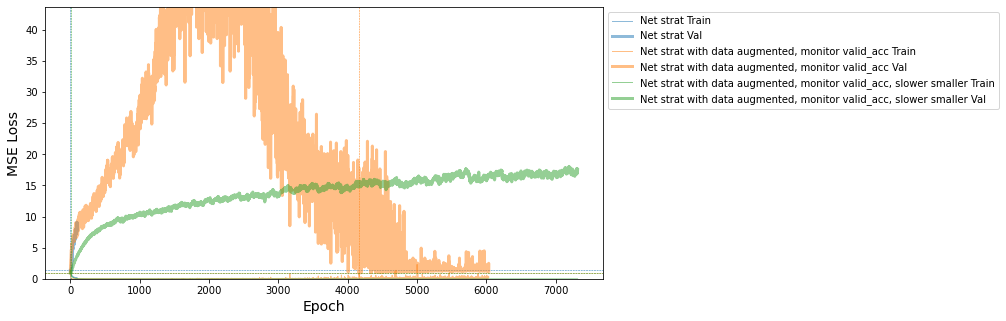

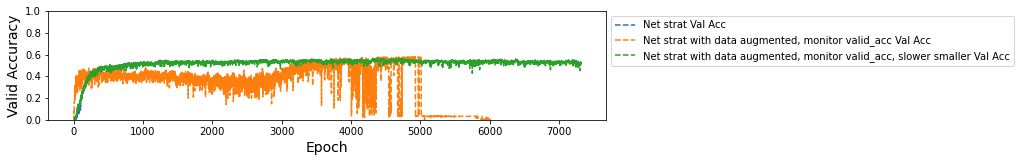

In [66]:
nets = [
    (net,'Net strat'),
    (net_da,'Net strat with data augmented, monitor valid_acc'),
    (net_da2,'Net strat with data augmented, monitor valid_acc, slower smaller')
]

sk_loss_plot(nets,yscaler=50)

In [67]:
cls_full_train_df = view_cls_report(net_da2,s['Xtrain_aug'],s['ytrain_aug'],imods_filt)
cls_test_df = view_cls_report(net_da2,s['Xval'],s['yval'],imods_filt)

alt.VConcatChart(...)

alt.VConcatChart(...)

In [ ]:
# longer training time to see if it comes down, monitor valid_acc

In [171]:
# keep going....?
net_da.partial_fit(s['Xtrain_aug'], s['ytrain_aug'], epochs=1000)


Re-initializing module because the following parameters were re-set: conv_pool_size1, conv_pool_size2, dropout1, dropout2, fc_node_num1, fc_node_num2, kernel_size1, kernel_size2, n_tasks, num_filters1, num_filters2, seq_len.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3584       0.0000        0.9328  0.6999
      2        1.3309       0.0000        0.9045  0.5534
      3        0.9989       0.0000        0.9658  0.5512
      4        0.6216       0.0000        1.2848  0.5515
      5        0.4493       0.0000        1.6411  0.5502
      6        0.3500       0.0147        1.9036  0.5513
      7        0.2834       0.0117        2.1834  0.5503
      8        0.2501       0.0205        2.2225  0.5506
      9        0.2110       0.0293        2.4778  0.5507
     10        0.1858       0.0528        2.6610  0.5511
     11        0.1633       0.0352   

    126        0.0157       0.2903        6.9028  0.5570
    127        0.0184       0.3138        6.9138  0.5571
    128        0.0139       0.3021        6.9177  0.5581
    129        0.0186       0.2874        6.7234  0.5573
    130        0.0200       0.2493        6.1470  0.5577
    131        0.0205       0.2815        6.6101  0.5553
    132        0.0157       0.2639        6.3806  0.5531
    133        0.0132       0.2962        7.4089  0.5528
    134        0.0146       0.3314        6.8818  0.5527
    135        0.0162       0.2815        6.7121  0.5532
    136        0.0116       0.3519        7.0924  0.5534
    137        0.0101       0.2698        7.5313  0.5540
    138        0.0145       0.2786        6.7188  0.5529
    139        0.0135       0.2933        6.9309  0.5540
    140        0.0113       0.3490        7.5404  0.5527
    141        0.0160       0.2639        6.8790  0.5539
    142        0.0169       0.2639        6.8650  0.5555
    143        0.0116       0.3

    268        0.0054       0.3783        8.6634  0.5520
    269        0.0069       0.3578        8.6543  0.5516
    270        0.0135       0.3050        7.4646  0.5545
    271        0.0087       0.3109        7.2749  0.5552
    272        0.0072       0.3167        8.2008  0.5579
    273        0.0078       0.3343        8.2148  0.5581
    274        0.0055       0.3109        8.6116  0.5578
    275        0.0091       0.3519        7.9011  0.5577
    276        0.0051       0.3050        8.2662  0.5549
    277        0.0045       0.4018        9.0088  0.5601
    278        0.0065       0.4018        9.1078  0.5595
    279        0.0089       0.3372        8.8675  0.5559
    280        0.0050       0.3519        9.1914  0.5617
    281        0.0048       0.3548        9.4448  0.5586
    282        0.0068       0.3314        8.6804  0.5515
    283        0.0082       0.3783        8.8225  0.5510
    284        0.0097       0.3138        8.1922  0.5510
    285        0.0079       0.3

    412        0.0061       0.3724        9.6974  0.5590
    413        0.0059       0.3460       10.0064  0.5593
    414        0.0033       0.4135       10.6660  0.5579
    415        0.0042       0.3959       10.2246  0.5618
    416        0.0036       0.3636       10.3508  0.5588
    417        0.0082       0.3548        9.7164  0.5588
    418        0.0085       0.3255        9.0913  0.5592
    419        0.0046       0.4194       10.0275  0.5595
    420        0.0036       0.4370       10.4305  0.5603
    421        0.0062       0.3871       10.2133  0.5559
    422        0.0059       0.3636        9.6401  0.5582
    423        0.0039       0.4370       10.4373  0.5561
    424        0.0046       0.3959       10.2168  0.5596
    425        0.0027       0.4428       10.7092  0.5588
    426        0.0037       0.4047       10.5789  0.5541
    427        0.0044       0.3812       10.2824  0.5519
    428        0.0046       0.4018       10.5391  0.5527
    429        0.0034       0.3

    555        0.0067       0.3842       11.6430  0.5609
    556        0.0055       0.3724       11.6955  0.5590
    557        0.0071       0.3930       11.6995  0.5597
    558        0.0028       0.3754       11.8745  0.5580
    559        0.0057       0.3842       11.8130  0.5578
    560        0.0033       0.3607       12.1093  0.5620
    561        0.0061       0.3695       11.8713  0.5634
    562        0.0090       0.3372       11.5534  0.5583
    563        0.0050       0.3695       11.3558  0.5604
    564        0.0037       0.3695       11.4259  0.5590
    565        0.0048       0.3724       11.8377  0.5599
    566        0.0029       0.3842       11.9579  0.5636
    567        0.0044       0.4135       11.8003  0.5600
    568        0.0043       0.3930       11.8924  0.5602
    569        0.0047       0.3871       11.7560  0.5620
    570        0.0037       0.3226       10.7319  0.5563
    571        0.0064       0.3519       10.0040  0.5636
    572        0.0060       0.3

    699        0.0062       0.3402       12.4279  0.5591
    700        0.0036       0.3754       12.2809  0.5601
    701        0.0051       0.3812       12.2527  0.5537
    702        0.0021       0.4340       13.1683  0.5523
    703        0.0050       0.3402       12.4196  0.5574
    704        0.0056       0.3607       12.0923  0.5607
    705        0.0064       0.3636       13.9508  0.5560
    706        0.0084       0.3754       12.3718  0.5530
    707        0.0089       0.3548       12.3216  0.5536
    708        0.0039       0.3548       12.2707  0.5537
    709        0.0038       0.3255       11.7597  0.5533
    710        0.0063       0.3343       12.4940  0.5530
    711        0.0061       0.3314       12.3572  0.5527
    712        0.0078       0.3900       12.4054  0.5530
    713        0.0034       0.3871       12.8137  0.5533
    714        0.0065       0.3871       12.0810  0.5535
    715        0.0039       0.3783       11.8843  0.5568
    716        0.0046       0.3

    843        0.0035       0.3783       14.6240  0.5583
    844        0.0033       0.3519       14.1397  0.5575
    845        0.0023       0.4047       15.0659  0.5578
    846        0.0136       0.3431       13.0350  0.5583
    847        0.0105       0.3519       13.8096  0.5581
    848        0.0049       0.3783       13.9222  0.5620
    849        0.0035       0.3490       14.3953  0.5623
    850        0.0052       0.3812       15.0493  0.5633
    851        0.0055       0.3372       14.2536  0.5585
    852        0.0051       0.3754       14.7605  0.5559
    853        0.0021       0.4194       15.4742  0.5572
    854        0.0023       0.4018       15.4397  0.5587
    855        0.0024       0.4223       15.8159  0.5562
    856        0.0072       0.3490       14.3401  0.5562
    857        0.0038       0.3666       14.9729  0.5585
    858        0.0030       0.3490       15.0669  0.5566
    859        0.0028       0.3871       15.5888  0.5568
    860        0.0025       0.4

    987        0.0016       0.4340       16.5546  0.5614
    988        0.0018       0.4399       16.7192  0.5610
    989        0.0038       0.4018       15.8160  0.5603
    990        0.0019       0.4399       17.0818  0.5604
    991        0.0021       0.4370       16.5645  0.5618
    992        0.0049       0.3842       15.8515  0.5615
    993        0.0029       0.4076       16.2815  0.5595
    994        0.0027       0.4399       16.4631  0.5628
    995        0.0014       0.4663       17.8221  0.5656
    996        0.0032       0.4428       16.8721  0.5650
    997        0.0033       0.4047       17.0345  0.5691
    998        0.0053       0.3695       16.0900  0.5638
    999        0.0046       0.4076       17.8284  0.5611
   1000        0.0039       0.4311       17.5833  0.5591


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=DNA_2CNN_2FC_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 8), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(128, 64, kernel_size=(1, 8), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.2, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=5760, out_features=100, bias=True)
      (9): ReLU()
      (10): Linear(in_features=100, out_features=100, bias=True)
      (11): ReLU()
      (12): Linear(in_features=100, out_features=58, bias=True)
    )
  ),
)

In [175]:
net_da2.partial_fit(s['Xtrain_aug'], s['ytrain_aug'], epochs=100)


    102        0.0090       0.3490        7.9144  0.6922
    103        0.0156       0.3021        7.6148  0.5549
    104        0.0159       0.2815        7.6667  0.5568
    105        0.0106       0.3314        7.9514  0.5560
    106        0.0099       0.3460        7.9627  0.5547
    107        0.0123       0.3402        7.8531  0.5537
    108        0.0134       0.3196        7.7053  0.5587
    109        0.0096       0.3812        8.5232  0.5666
    110        0.0099       0.3138        7.8587  0.5626


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=DNA_2CNN_2FC_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 8), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(128, 64, kernel_size=(1, 8), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.2, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=5760, out_features=100, bias=True)
      (9): ReLU()
      (10): Linear(in_features=100, out_features=100, bias=True)
      (11): ReLU()
      (12): Linear(in_features=100, out_features=58, bias=True)
    )
  ),
)

Running net da


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


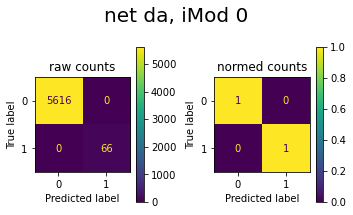

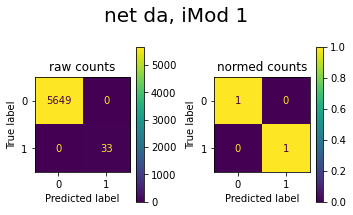

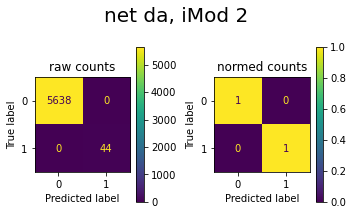

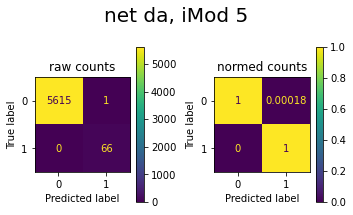

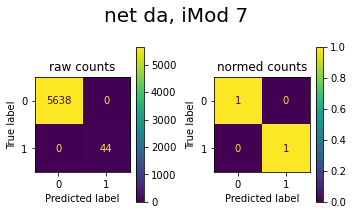

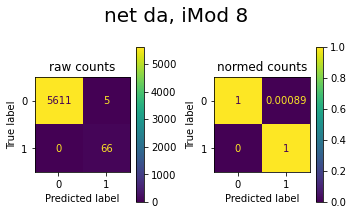

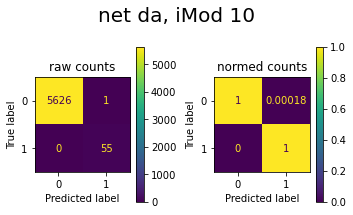

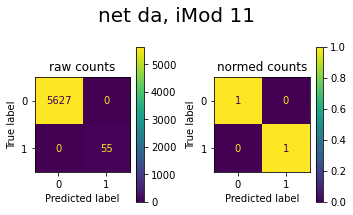

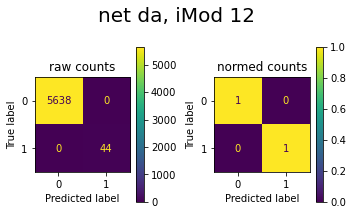

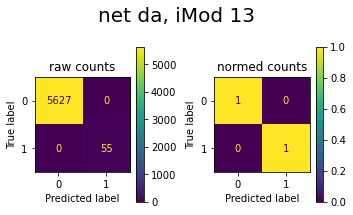

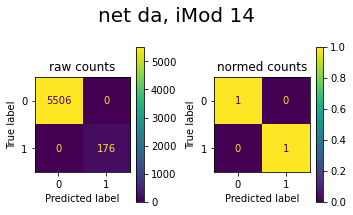

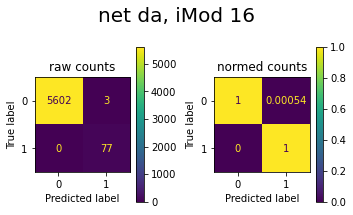

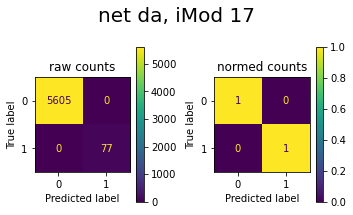

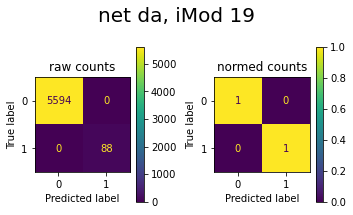

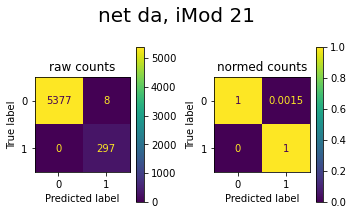

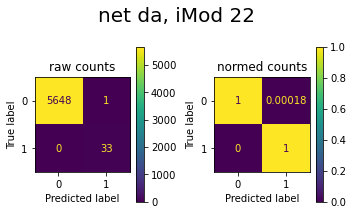

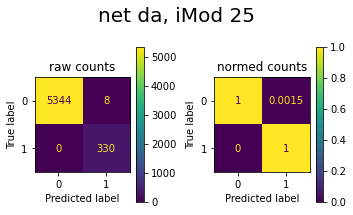

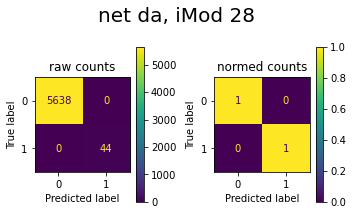

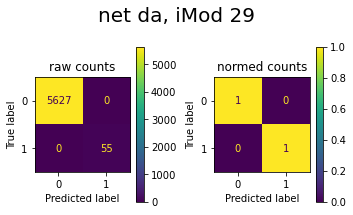

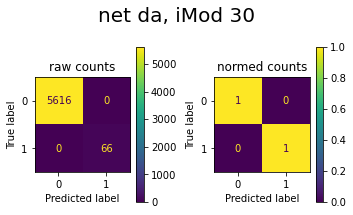

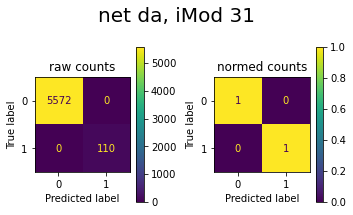

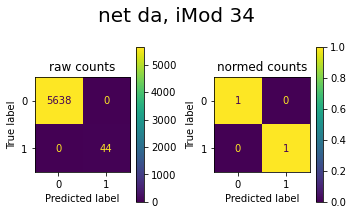

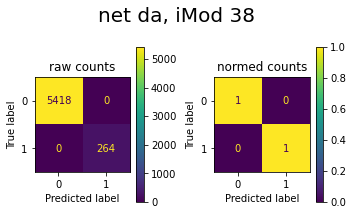

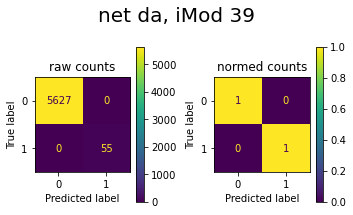

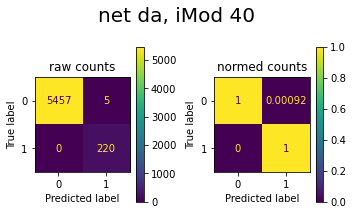

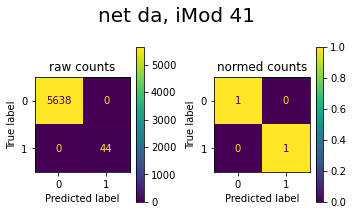

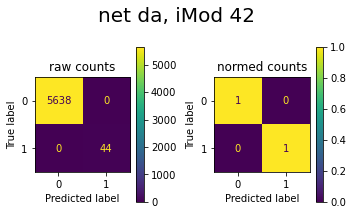

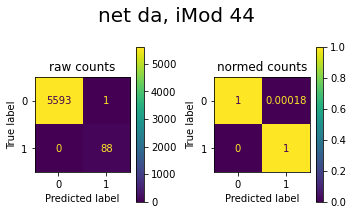

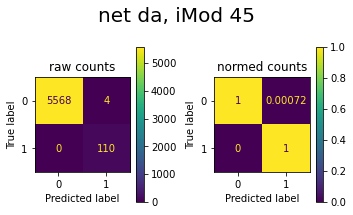

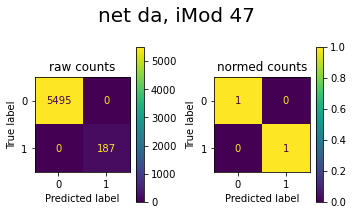

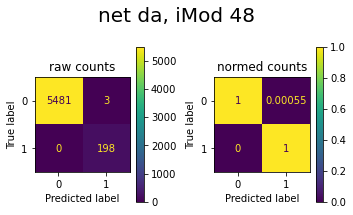

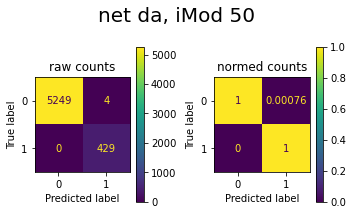

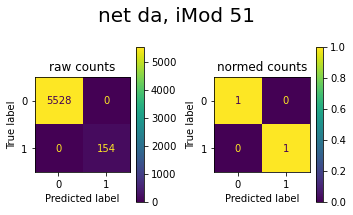

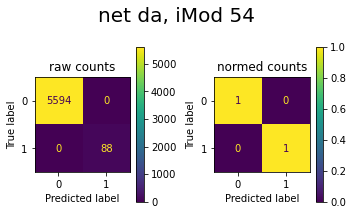

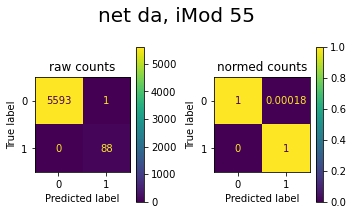

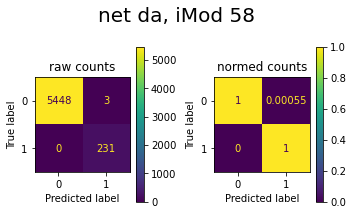

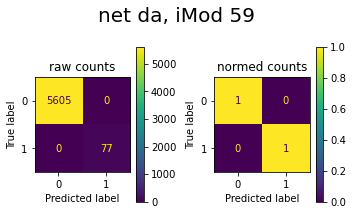

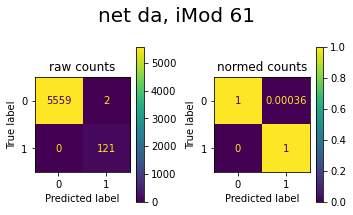

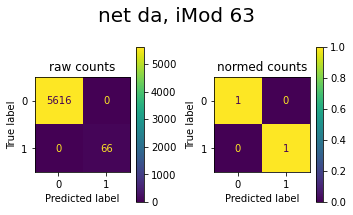

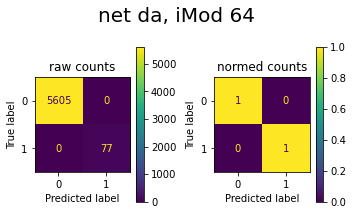

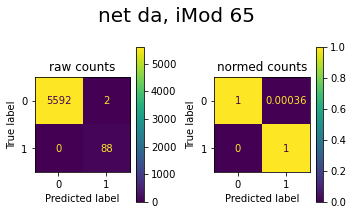

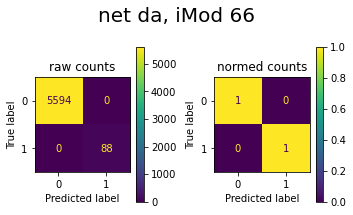

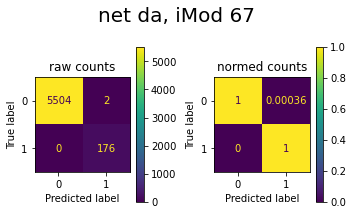

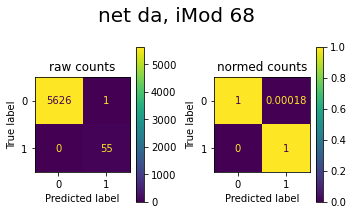

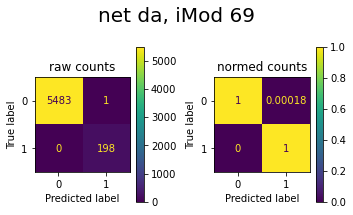

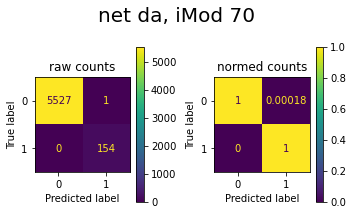

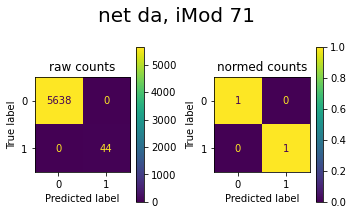

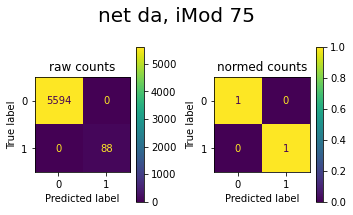

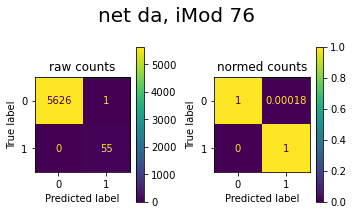

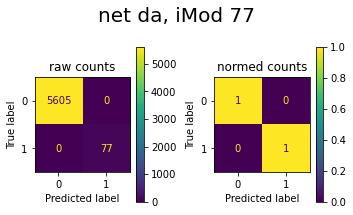

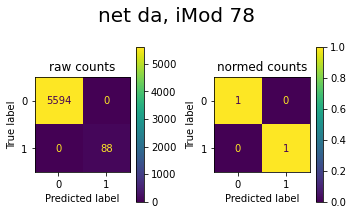

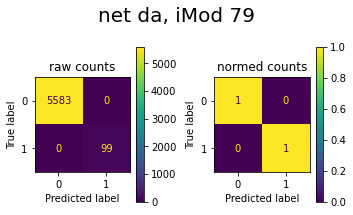

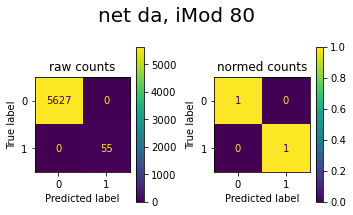

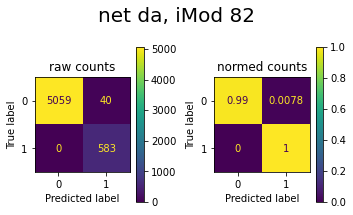

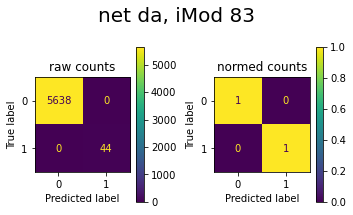

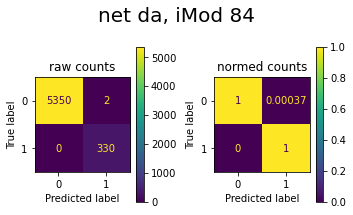

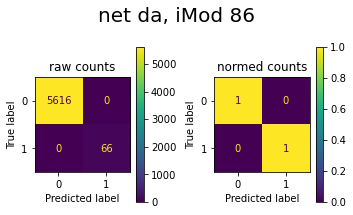

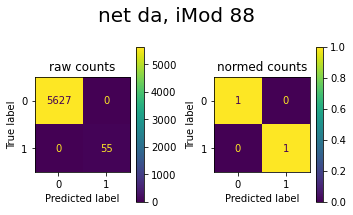

In [149]:
plot_confusion_multi([(net_da,'net da')], s['Xtrain_aug'],s['ytrain_aug'],imods_filt)

Running net da


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


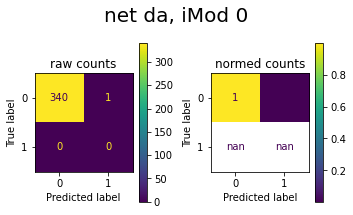

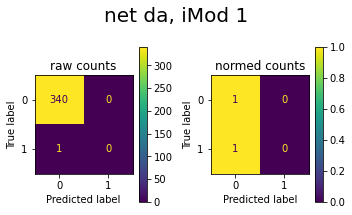

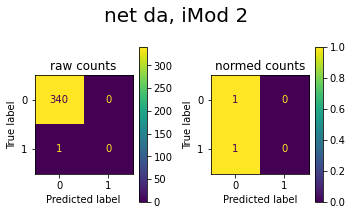

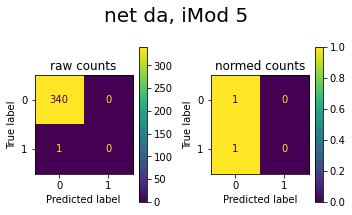

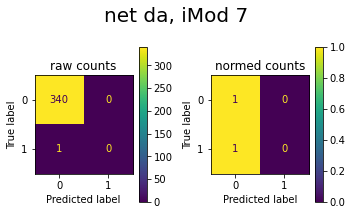

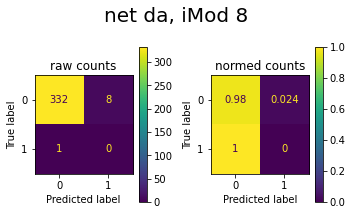

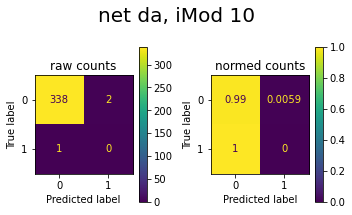

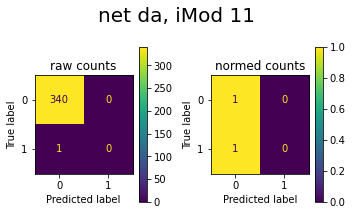

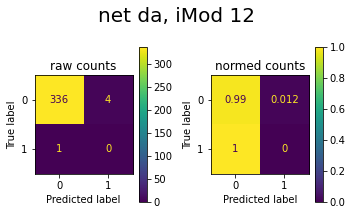

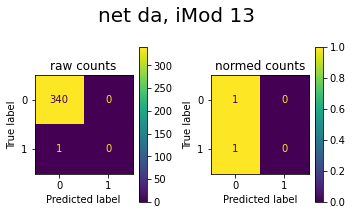

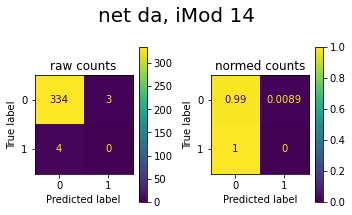

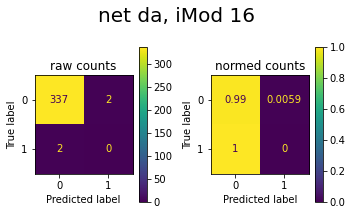

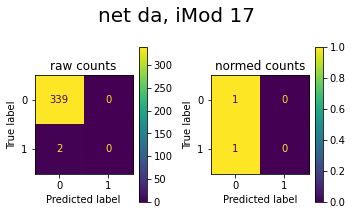

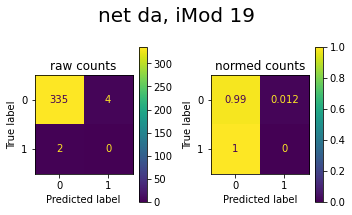

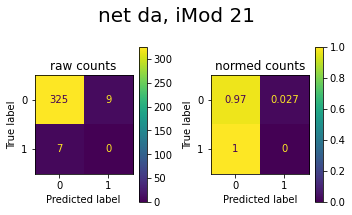

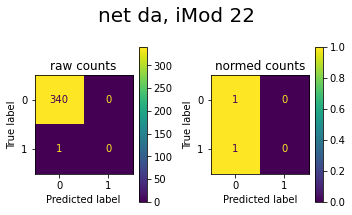

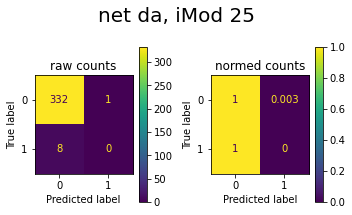

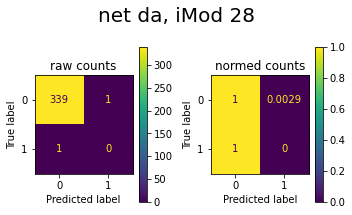

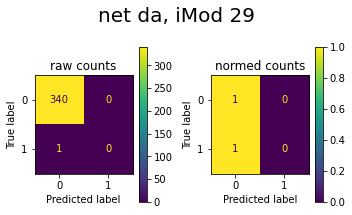

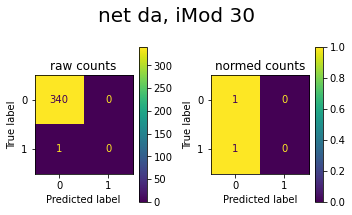

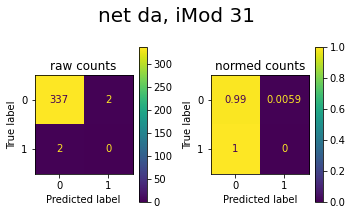

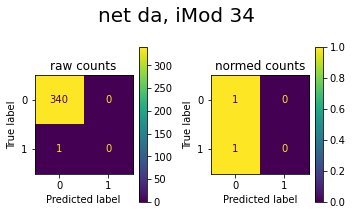

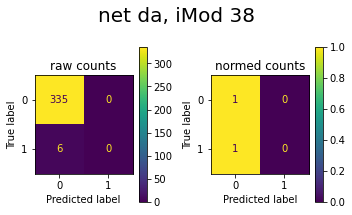

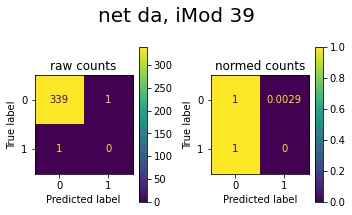

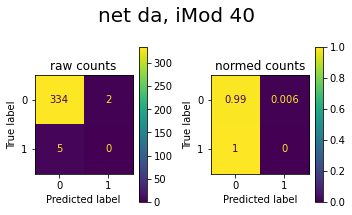

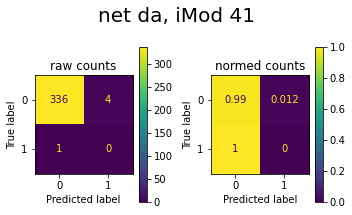

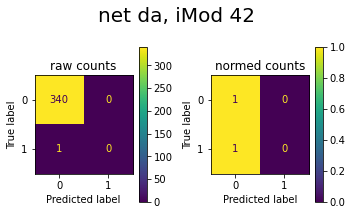

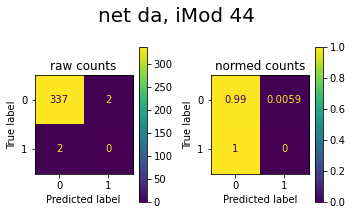

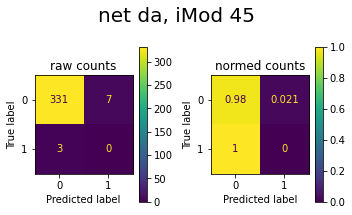

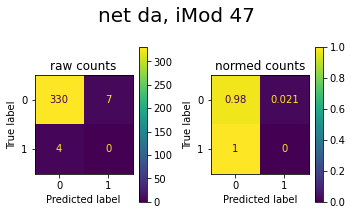

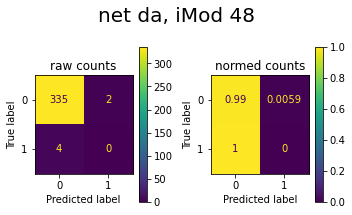

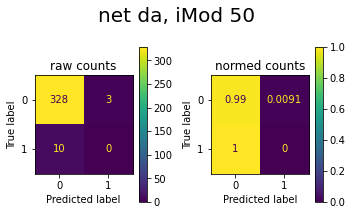

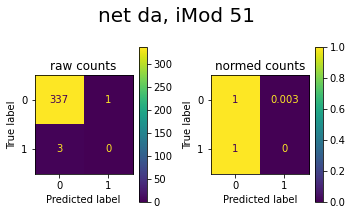

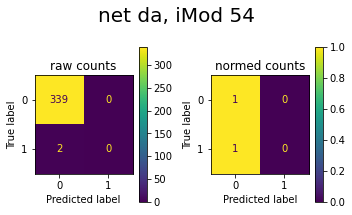

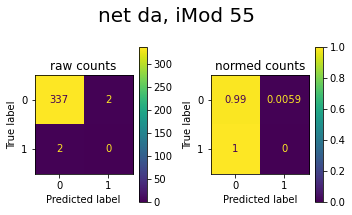

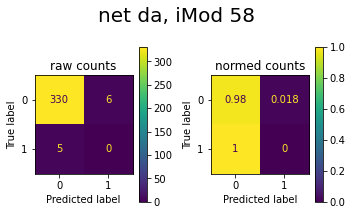

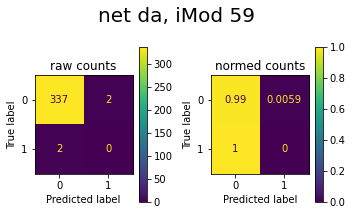

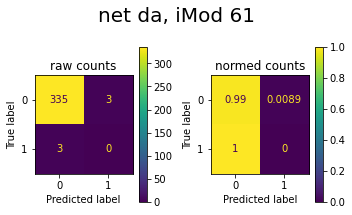

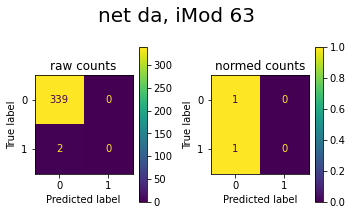

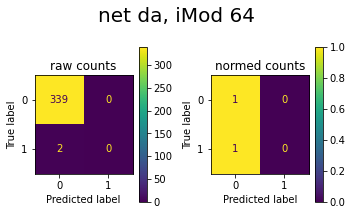

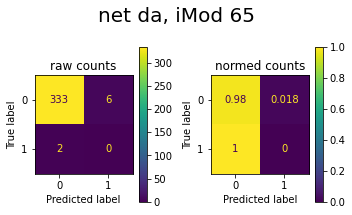

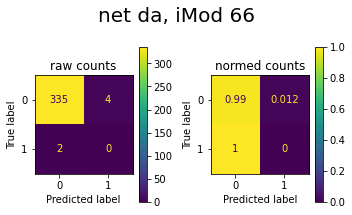

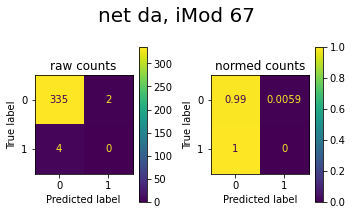

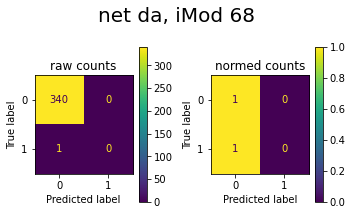

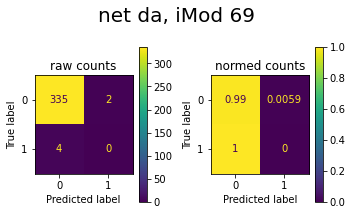

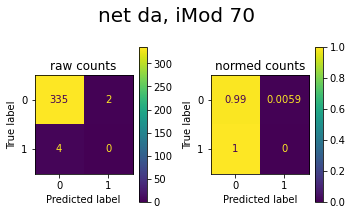

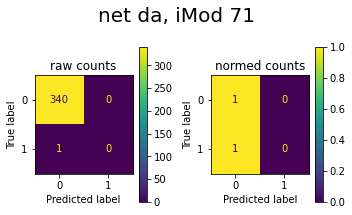

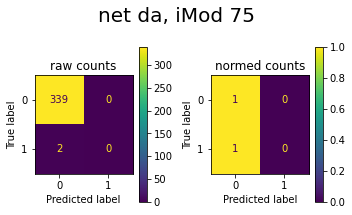

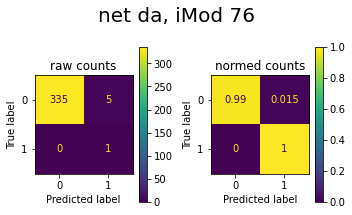

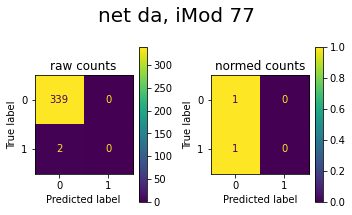

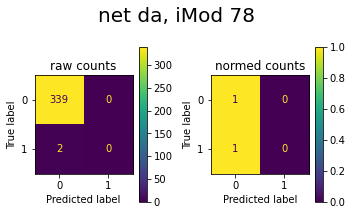

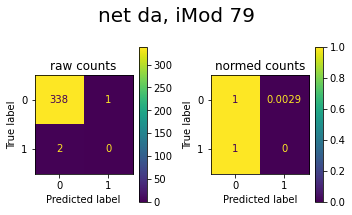

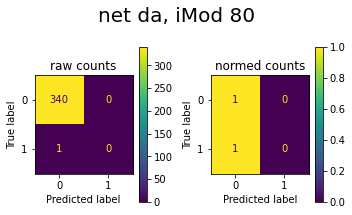

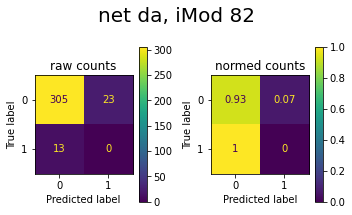

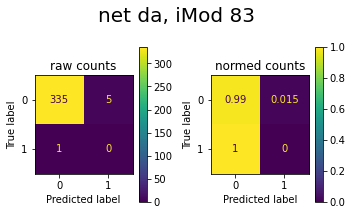

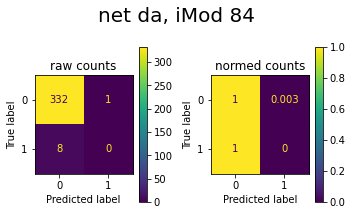

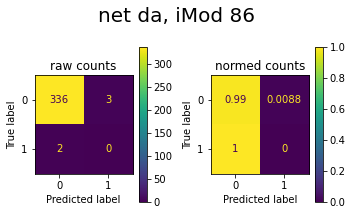

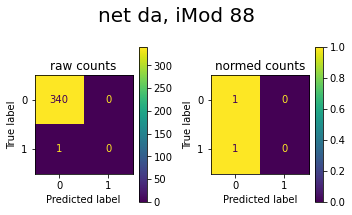

In [152]:
plot_confusion_multi([(net_da,'net da')], s['Xval'],s['yval'],imods_filt)

In [150]:
# trying with monitoring valid acc

In [151]:
1+1

2

## fiddle with params with bce weights

In [36]:
# apparently i think DNA_2CNN_2FC_Multi should still work for multi-label classification
valid_ds = Dataset(Xval_strat, yval_strat)

net_strat_bcew_tink5 = NeuralNetClassifier(
    m.DNA_2CNN_2FC_Multi, # my pytorch model
    criterion=torch.nn.BCEWithLogitsLoss(pos_weight=bce_pos_weights),
    train_split=predefined_split(valid_ds), # stratified =True
    module__seq_len=300, # pass arg to pytorch model
    module__n_tasks=y.shape[1],
    module__num_filters1=64,
    module__num_filters2=8,
    module__kernel_size1=8,
    module__kernel_size2=3,
    module__conv_pool_size1=3, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 50,
    module__fc_node_num2 = 50,
    module__dropout1 = 0.2,
    module__dropout2 = 0.4,
    max_epochs=2000,
    lr=0.0001,
    batch_size=256,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         EarlyStopping(patience=1000),
         #Checkpoint(load_best=True),
         GradientNormClipping()
     ],
    optimizer=torch.optim.AdamW,
    optimizer__weight_decay=1e-3,
    #optimizer=torch.optim.SGD,
    iterator_train__shuffle=True,
    #train_split=predefined_split(valid_ds)
    #train_split=None
)

In [37]:
net_strat_bcew_tink5.fit(Xtrain_strat,ytrain_strat)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3846       0.0000        1.3554  0.1788
      2        1.3844       0.0000        1.3554  0.1199
      3        1.3848       0.0000        1.3554  0.1027
      4        1.3844       0.0000        1.3554  0.0898
      5        1.3837       0.0000        1.3553  0.0883
      6        1.3836       0.0000        1.3553  0.0880
      7        1.3836       0.0000        1.3554  0.0879
      8        1.3835       0.0000        1.3554  0.0876
      9        1.3841       0.0000        1.3555  0.0877
     10        1.3844       0.0000        1.3555  0.0876
     11        1.3837       0.0000        1.3555  0.0880
     12        1.3830       0.0000        1.3555  0.0880
     13        1.3829       0.0000        1.3555  0.0877
     14        1.3830       0.0000        1.3556  0.0892
     15        1.3828       0.0000        1.3556  0.0879
     16        1.3826       0.0

    129        1.0254       0.0000        1.5327  0.0901
    130        1.0328       0.0000        1.5337  0.0892
    131        1.0176       0.0000        1.5313  0.0889
    132        1.0262       0.0000        1.5209  0.0888
    133        1.0258       0.0000        1.5276  0.0891
    134        1.0223       0.0000        1.5327  0.0890
    135        1.0191       0.0000        1.5537  0.0890
    136        1.0100       0.0000        1.5521  0.0888
    137        0.9803       0.0000        1.5861  0.0890
    138        0.9910       0.0000        1.5824  0.0890
    139        0.9940       0.0000        1.5866  0.0895
    140        0.9776       0.0000        1.6033  0.0893
    141        0.9632       0.0000        1.6157  0.0890
    142        0.9541       0.0000        1.6203  0.0890
    143        0.9364       0.0000        1.6166  0.0891
    144        0.9614       0.0000        1.6459  0.0891
    145        0.9276       0.0000        1.6728  0.0899
    146        0.9333       0.0

    264        0.5785       0.0117        2.7620  0.0899
    265        0.5643       0.0088        2.7836  0.0891
    266        0.5671       0.0029        2.8764  0.0895
    267        0.5668       0.0029        2.9162  0.0908
    268        0.5475       0.0029        2.9234  0.0895
    269        0.5619       0.0117        2.9082  0.0888
    270        0.5652       0.0059        2.8878  0.0886
    271        0.5465       0.0088        2.8884  0.0887
    272        0.5433       0.0088        2.9148  0.0888
    273        0.5259       0.0147        2.9678  0.0887
    274        0.5677       0.0176        2.9593  0.0890
    275        0.5370       0.0117        2.9587  0.0894
    276        0.5458       0.0088        2.9791  0.0897
    277        0.5409       0.0147        2.9491  0.0896
    278        0.5296       0.0147        3.0000  0.0908
    279        0.5374       0.0117        2.9982  0.0892
    280        0.5418       0.0029        2.9004  0.0890
    281        0.5299       0.0

    402        0.3909       0.0293        4.0215  0.0902
    403        0.3767       0.0411        4.0490  0.0900
    404        0.3897       0.0411        4.0599  0.0901
    405        0.3699       0.0381        4.0050  0.0908
    406        0.4089       0.0440        3.9907  0.0912
    407        0.3821       0.0440        4.0284  0.0911
    408        0.3704       0.0411        4.1004  0.0911
    409        0.3864       0.0323        4.0897  0.0915
    410        0.3829       0.0323        4.0261  0.0909
    411        0.3933       0.0293        4.0008  0.0914
    412        0.3806       0.0264        4.0556  0.0912
    413        0.3858       0.0293        4.0685  0.0926
    414        0.3747       0.0411        4.1202  0.0923
    415        0.3911       0.0352        4.1318  0.0923
    416        0.3794       0.0381        4.0961  0.0919
    417        0.3721       0.0352        4.0865  0.0905
    418        0.3696       0.0381        4.0915  0.0914
    419        0.3706       0.0

    542        0.2793       0.0557        4.9504  0.0900
    543        0.2960       0.0528        4.9768  0.0904
    544        0.2936       0.0469        5.0383  0.0905
    545        0.2932       0.0587        5.0536  0.0899
    546        0.2910       0.0528        5.0141  0.0908
    547        0.2712       0.0587        5.0854  0.0909
    548        0.2824       0.0674        5.1721  0.0901
    549        0.3013       0.0557        5.1167  0.0901
    550        0.2855       0.0528        4.9967  0.0916
    551        0.2815       0.0499        4.9714  0.0900
    552        0.2944       0.0587        5.0117  0.0898
    553        0.2773       0.0762        5.0933  0.0895
    554        0.2833       0.0762        5.1340  0.0898
    555        0.2899       0.0674        5.1020  0.0901
    556        0.2792       0.0528        5.1175  0.0896
    557        0.2821       0.0528        5.1320  0.0893
    558        0.2770       0.0616        5.1343  0.0894
    559        0.2896       0.0

    682        0.2332       0.0880        5.9928  0.0909
    683        0.2234       0.0968        6.0202  0.0892
    684        0.2268       0.0880        5.9754  0.0909
    685        0.2269       0.0792        5.9119  0.0897
    686        0.2465       0.0762        5.8683  0.0897
    687        0.2195       0.0880        5.8304  0.0892
    688        0.2271       0.0938        5.9202  0.0900
    689        0.2363       0.0938        5.9196  0.0902
    690        0.2261       0.0762        5.8319  0.0909
    691        0.2311       0.0704        5.7977  0.0902
    692        0.2246       0.0792        5.7746  0.0904
    693        0.2250       0.0880        5.8693  0.0898
    694        0.2202       0.0938        6.0045  0.0907
    695        0.2174       0.0968        6.0411  0.0911
    696        0.2264       0.0792        6.0030  0.0906
    697        0.2308       0.0645        5.9450  0.0934
    698        0.2329       0.0762        5.9146  0.0913
    699        0.2106       0.0

    823        0.1897       0.1173        6.7034  0.0896
    824        0.1791       0.1056        6.7566  0.0896
    825        0.1783       0.1202        6.8173  0.0901
    826        0.1739       0.1173        6.8478  0.0898
    827        0.1892       0.1261        6.8292  0.0901
    828        0.1924       0.1232        6.7823  0.0897
    829        0.1873       0.0938        6.7036  0.0900
    830        0.1916       0.1056        6.7135  0.1595
    831        0.1941       0.1085        6.7246  0.0902
    832        0.1830       0.1202        6.7135  0.0897
    833        0.1774       0.1232        6.7735  0.0903
    834        0.1877       0.1261        6.8256  0.0903
    835        0.1830       0.1261        6.8724  0.0897
    836        0.1806       0.1290        6.9390  0.0911
    837        0.1895       0.1349        6.9014  0.0904
    838        0.1840       0.1202        6.8006  0.0897
    839        0.1834       0.1202        6.7896  0.0891
    840        0.2002       0.1

    964        0.1661       0.1408        7.4025  0.0903
    965        0.1570       0.1261        7.3522  0.0908
    966        0.1641       0.1202        7.3512  0.0900
    967        0.1658       0.1320        7.4098  0.0896
    968        0.1604       0.1408        7.4852  0.0904
    969        0.1613       0.1496        7.5363  0.0917
    970        0.1538       0.1496        7.5578  0.0923
    971        0.1570       0.1496        7.6271  0.0920
    972        0.1539       0.1466        7.6282  0.0925
    973        0.1428       0.1496        7.6782  0.0924
    974        0.1624       0.1378        7.6388  0.0931
    975        0.1591       0.1349        7.5267  0.0930
    976        0.1550       0.1290        7.4372  0.0918
    977        0.1553       0.1408        7.4729  0.0934
    978        0.1570       0.1554        7.4864  0.0933
    979        0.1606       0.1437        7.4836  0.0920
    980        0.1499       0.1320        7.5175  0.0915
    981        0.1491       0.1

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=DNA_2CNN_2FC_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 8), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(64, 8, kernel_size=(1, 3), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.4, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=760, out_features=50, bias=True)
      (9): ReLU()
      (10): Linear(in_features=50, out_features=50, bias=True)
      (11): ReLU()
      (12): Linear(in_features=50, out_features=58, bias=True)
    )
  ),
)

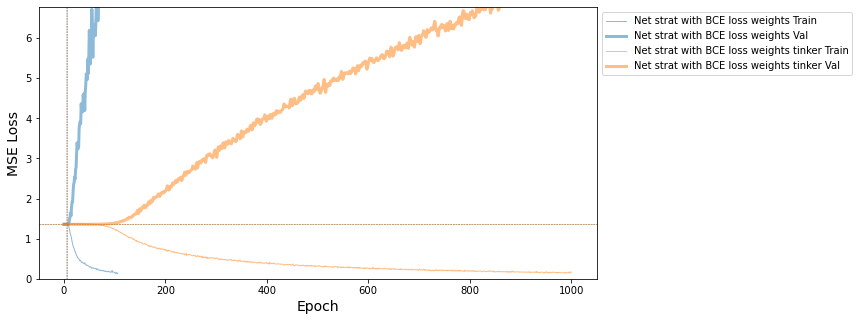

In [38]:
nets = [
    #(net_strat_val,'Net strat with val'),
    (net_strat_bcew,'Net strat with BCE loss weights'),
#     (net_strat_bcew_tink,'Net strat with BCE loss weights tinker'),
#     (net_strat_bcew_tink2,'Net strat with BCE loss weights tinker'),
#     (net_strat_bcew_tink3,'Net strat with BCE loss weights tinker'),
#     (net_strat_bcew_tink4,'Net strat with BCE loss weights tinker'),
    (net_strat_bcew_tink5,'Net strat with BCE loss weights tinker'),
]


sk_loss_plot(nets,yscaler=5)

In [39]:
cls_full_train_df = view_cls_report(net_strat_bcew_tink5,Xtrain_strat,ytrain_strat,imods_filt)
cls_test_df = view_cls_report(net_strat_bcew_tink5,Xval_strat,yval_strat,imods_filt)
cls_test_df = view_cls_report(net_strat_bcew_tink5,Xtest_strat,ytest_strat,imods_filt)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

Running bce weight tinkering


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


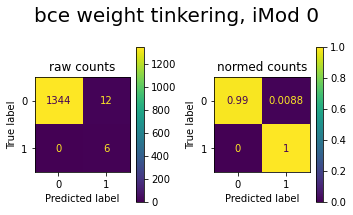

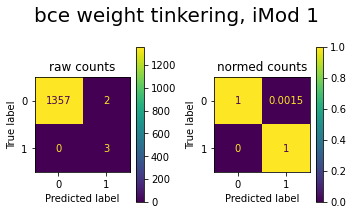

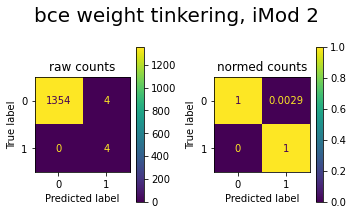

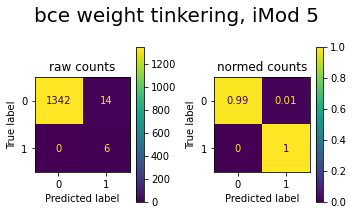

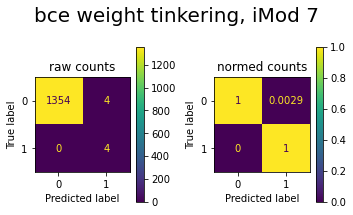

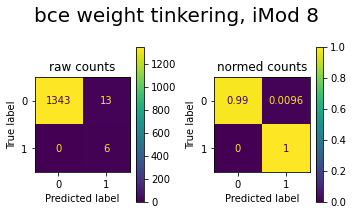

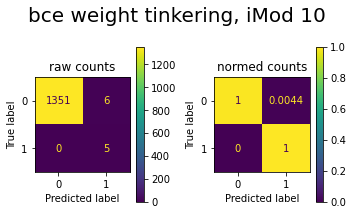

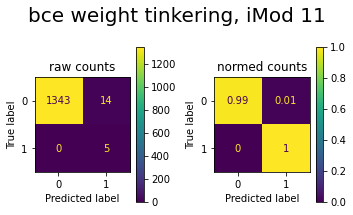

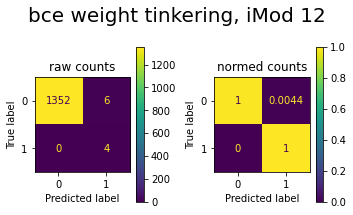

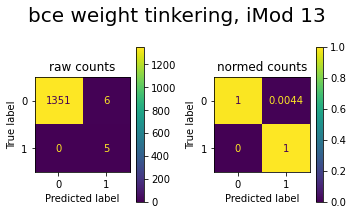

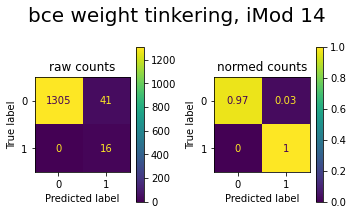

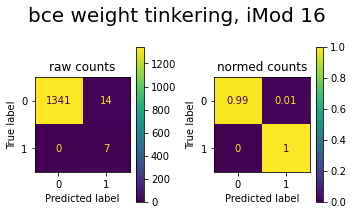

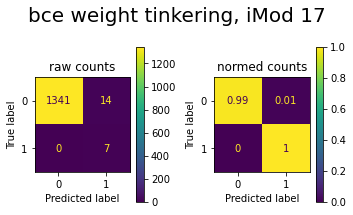

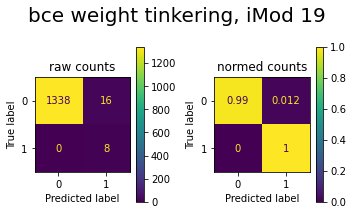

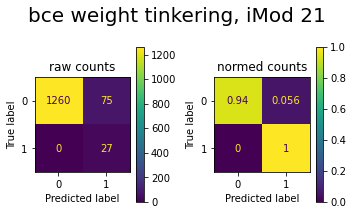

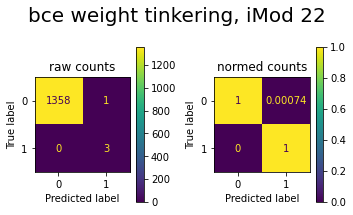

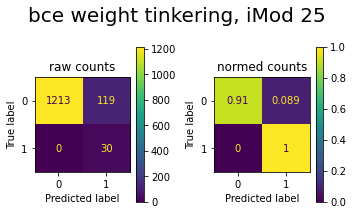

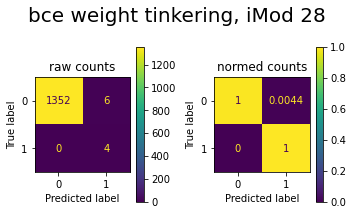

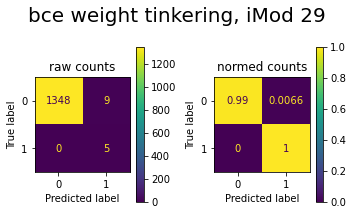

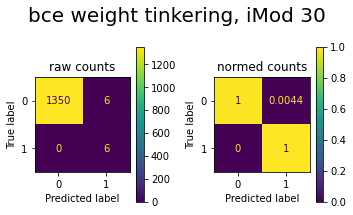

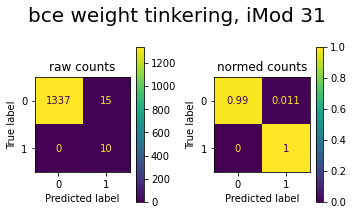

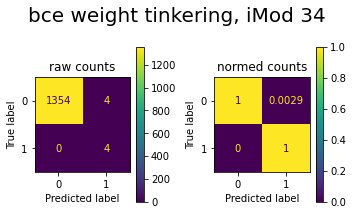

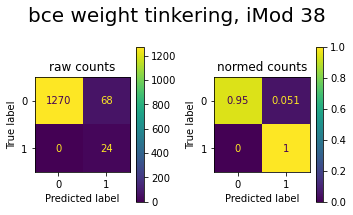

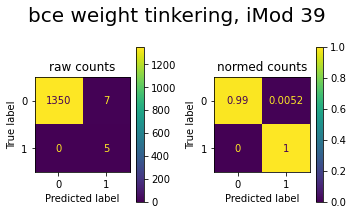

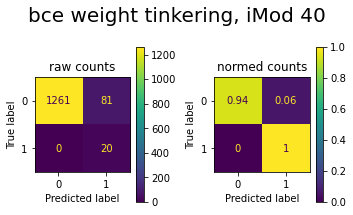

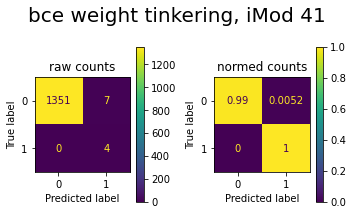

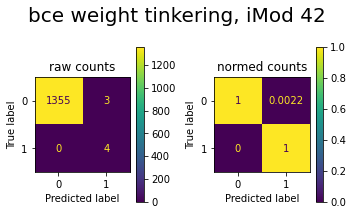

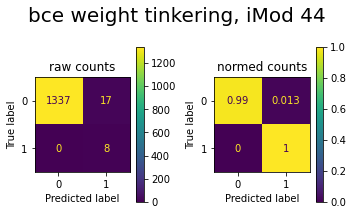

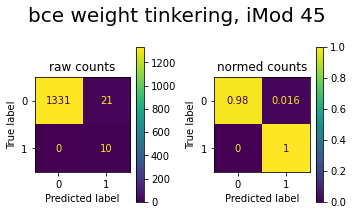

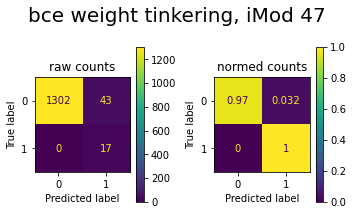

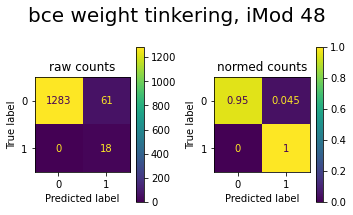

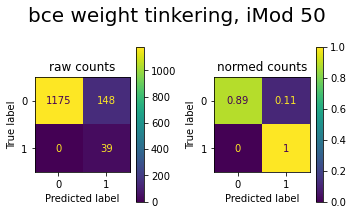

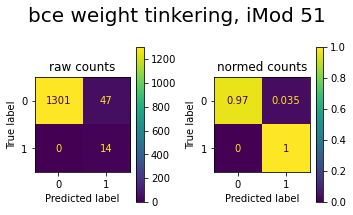

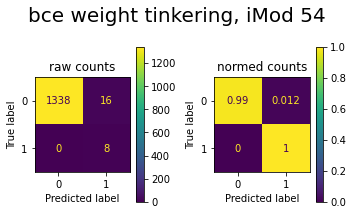

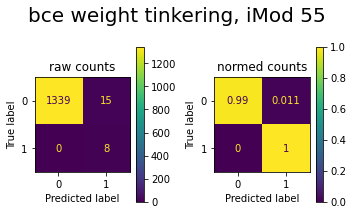

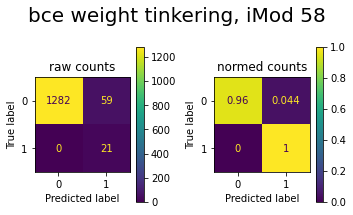

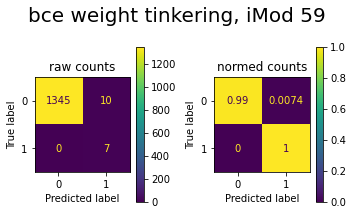

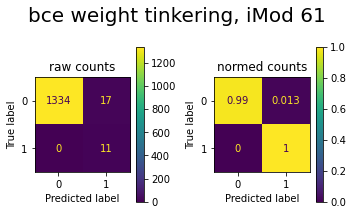

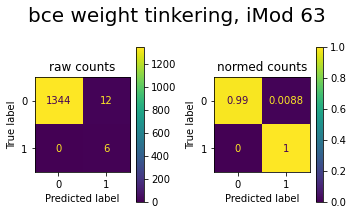

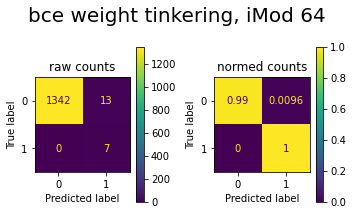

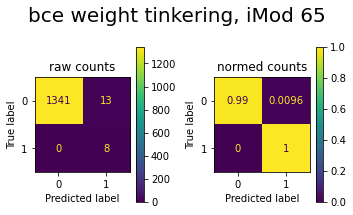

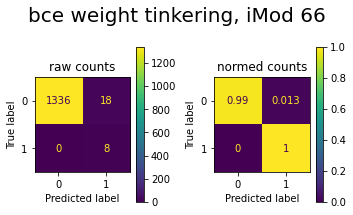

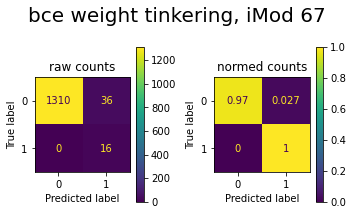

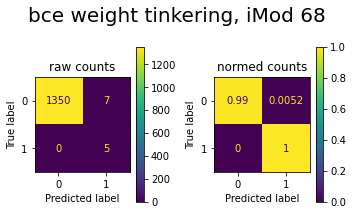

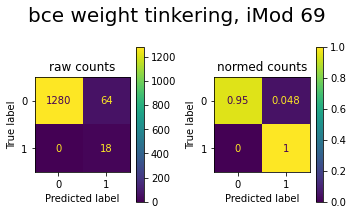

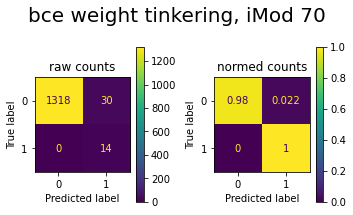

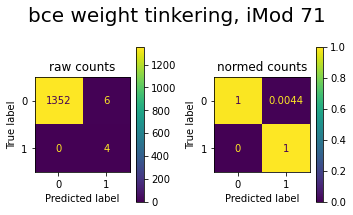

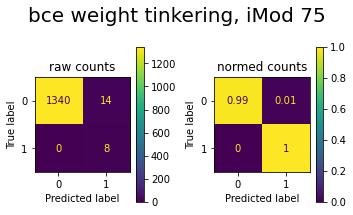

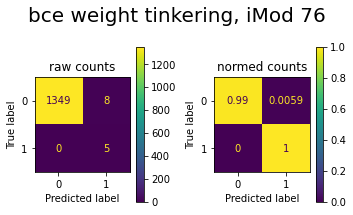

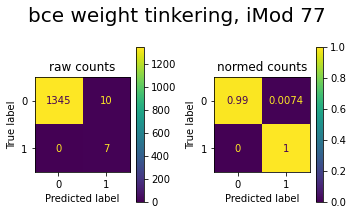

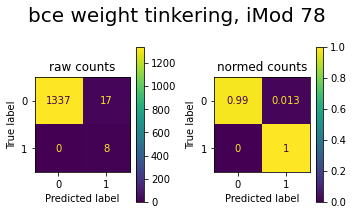

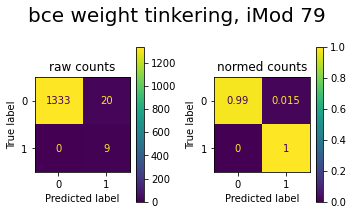

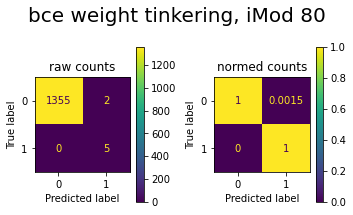

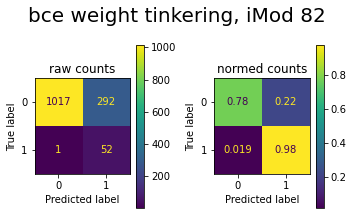

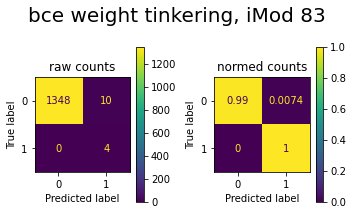

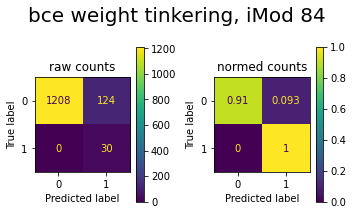

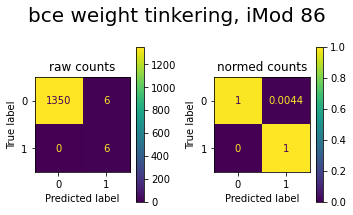

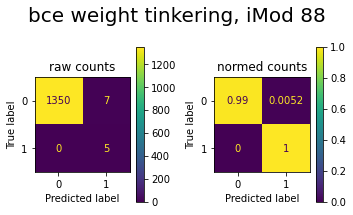

In [40]:
plot_confusion_multi([(net_strat_bcew_tink5,'bce weight tinkering')], Xtrain_strat,ytrain_strat,imods_filt)

In [41]:
#plot_confusion_multi([(net_strat_bcew_tink4,'bce weight tinkering')], Xval_strat,yval_strat,imods_filt)

In [42]:
#plot_confusion_multi([(net_strat_bcew_tink4,'bce weight tinkering')], Xtest_strat,ytest_strat,imods_filt)

In [43]:
net_strat_bcew_tink5.get_params()

{'module': models.DNA_2CNN_2FC_Multi,
 'criterion': BCEWithLogitsLoss(),
 'optimizer': torch.optim.adamw.AdamW,
 'lr': 0.0001,
 'max_epochs': 2000,
 'batch_size': 256,
 'iterator_train': torch.utils.data.dataloader.DataLoader,
 'iterator_valid': torch.utils.data.dataloader.DataLoader,
 'dataset': skorch.dataset.Dataset,
 'train_split': functools.partial(<function _make_split at 0x7f992046b0e0>, valid_ds=<skorch.dataset.Dataset object at 0x7f98c3a9e0d0>),
 'callbacks': [<skorch.callbacks.training.EarlyStopping at 0x7f985c3bd390>,
 'predict_nonlinearity': 'auto',
 'warm_start': False,
 'verbose': 1,
 'device': device(type='cuda'),
 '_kwargs': {'module__seq_len': 300,
  'module__n_tasks': 58,
  'module__num_filters1': 64,
  'module__num_filters2': 8,
  'module__kernel_size1': 8,
  'module__kernel_size2': 3,
  'module__conv_pool_size1': 3,
  'module__conv_pool_size2': 1,
  'module__fc_node_num1': 50,
  'module__fc_node_num2': 50,
  'module__dropout1': 0.2,
  'module__dropout2': 0.4,
  'opt

# SKORCH search

In [279]:
from sklearn.model_selection import RandomizedSearchCV


In [287]:
valid_ds = Dataset(Xval_strat, yval_strat)

net_search = NeuralNetClassifier(
    m.DNA_2CNN_2FC_Multi,
    #m.DNA_2CNN_Multi,
    #m.DNA_CNN_Multi,
    #train_split=ValidSplit(0.2),
    #train_split=None,
    #train_split=ValidSplit(k_fold.split(Xtrain_strat,ytrain_strat)),
    #train_split=k_fold,
    train_split=predefined_split(valid_ds),
    criterion=torch.nn.BCEWithLogitsLoss(pos_weight=bce_pos_weights),
    module__seq_len=300,
    module__n_tasks=y.shape[1],
    max_epochs=2000,
    #lr=0.001,
    device=DEVICE,
    callbacks=[
         #EarlyStopping(patience=100),
         EarlyStopping(patience=300),
         #Checkpoint(load_best=True),
         GradientNormClipping()
     ],
    verbose=0,

)


In [288]:
params = {
    'lr': [0.001, 0.0005, 0.0001,],#loguniform(0.0001, 0.01)
    'batch_size':[32,64,128,256],
    'module__num_filters1': [16,32,64,128],
    'module__num_filters2': [16,32,64,128],
    'module__kernel_size1': [4,8,16,32],
    'module__kernel_size2': [4,8,16,32],
    'module__conv_pool_size1': [2,4],
    'module__fc_node_num1': [10,50,100,500],
    'module__fc_node_num2': [10,50,100,500],
    'module__dropout1': [0.0,0.2,0.4],
    'module__dropout2': [0.0,0.2,0.4],
    'optimizer':[torch.optim.SGD, torch.optim.Adam,torch.optim.AdamW,torch.optim.RMSprop]
    #'optimizer':[torch.optim.Adam,torch.optim.AdamW,torch.optim.RMSprop]
}

In [291]:
search = RandomizedSearchCV(
    net_search, 
    params, 
    n_iter=500, 
    #scoring='neg_mean_squared_error', 
    #scoring=['precision','recall','f1_macro'], 
    scoring=['f1_macro'], 
    refit='f1_macro',
    n_jobs=-1, 
    #cv=3,#cv, 
    #cv=k_fold.split(Xtrain_strat,ytrain_strat),
    #cv=k_fold,
    random_state=7,
    verbose=1
)

In [292]:
search.fit(Xtrain_strat,ytrain_strat)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 53.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 116.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 209.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 323.3min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 473.1min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 638.9min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 649.9min finished


RandomizedSearchCV(estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class 'models.DNA_2CNN_2FC_Multi'>,
  module__n_tasks=58,
  module__seq_len=300,
),
                   n_iter=500, n_jobs=-1,
                   param_distributions={'batch_size': [32, 64, 128, 256],
                                        'lr': [0.001, 0.0005, 0.0001],
                                        'module__conv_pool_size1': [2, 4],
                                        'module__dropout1': [0.0, 0.2, 0.4],
                                        'module__drop...
                                        'module__kernel_size1': [4, 8, 16, 32],
                                        'module__kernel_size2': [4, 8, 16, 32],
                                        'module__num_filters1': [16, 32, 64,
                                                                 128],
                                        'module__num_filters2': [16, 32, 64,
                                

In [293]:
1+3

4

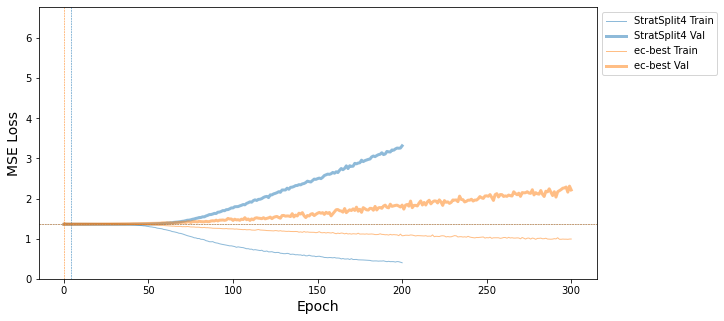

In [295]:
netss = [
    #(net_randsplit,"RandSplit"),
    (net_strat_bcew_tink4,"StratSplit4"),
    (search.best_estimator_,'ec-best')
]

sk_loss_plot(netss)

### inspect hyperparam search results

In [296]:
search.best_estimator_

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=DNA_2CNN_2FC_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 16, kernel_size=(4, 16), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.4, inplace=False)
      (4): Conv2d(16, 128, kernel_size=(1, 4), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.4, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=17792, out_features=10, bias=True)
      (9): ReLU()
      (10): Linear(in_features=10, out_features=500, bias=True)
      (11): ReLU()
      (12): Linear(in_features=500, out_features=58, bias=True)
    )
  ),
)

In [297]:
search.best_params_

{'optimizer': torch.optim.rmsprop.RMSprop,
 'module__num_filters2': 128,
 'module__num_filters1': 16,
 'module__kernel_size2': 4,
 'module__kernel_size1': 16,
 'module__fc_node_num2': 500,
 'module__fc_node_num1': 10,
 'module__dropout2': 0.4,
 'module__dropout1': 0.4,
 'module__conv_pool_size1': 2,
 'lr': 0.0001,
 'batch_size': 256}

In [298]:
res_df = pd.DataFrame(search.cv_results_)
res_df['opt_name'] = res_df['param_optimizer'].apply(lambda x: x.__name__)
res_df

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       134.922935      6.769828         0.038413        0.005305   
1        32.628558      0.521362         0.016442        0.001764   
2        36.742397      0.480560         0.016439        0.002489   
3        47.250834      4.226117         0.017608        0.001342   
4        21.798534      1.560944         0.013442        0.000632   
..             ...           ...              ...             ...   
495      43.590408      1.275636         0.020677        0.001830   
496      40.046049      0.327979         0.019808        0.002273   
497      28.925875      5.456215         0.016243        0.001518   
498      61.296736      7.202483         0.021766        0.002760   
499      38.402370      5.537510         0.017794        0.005182   

                           param_optimizer param_module__num_filters2  \
0    <class 'torch.optim.rmsprop.RMSprop'>                        128   
1            <class 'torch.optim.sgd.SGD'>                         32   
2          <class 'torch.optim.adam.Adam'>                         64   
3        <class 'torch.optim.adamw.AdamW'>                         32   
4    <class 'torch.optim.rmsprop.RMSprop'>                         16   
..                                     ...                        ...   
495        <class 'torch.optim.adam.Adam'>                        128   
496        <class 'torch.optim.adam.Adam'>                         64   
497  <class 'torch.optim.rmsprop.RMSprop'>                        128   
498          <class 'torch.optim.sgd.SGD'>                         16   
499          <class 'torch.optim.sgd.SGD'>                         16   

    param_module__num_filters1 param_module__kernel_size2  \
0                           64                         16   
1                           16                         32   
2                           32                          4   
3                          128                         32   
4                           32                         32   
..                         ...                        ...   
495                         32                         32   
496                        128                          8   
497                         32                          4   
498                        128                          8   
499                        128                          8   

    param_module__kernel_size1 param_module__fc_node_num2  ...  \
0                            4                         10  ...   
1                            4                         50  ...   
2                           16                         10  ...   
3                            8                        100  ...   
4                            4                         10  ...   
..                         ...                        ...  ...   
495                          8                         50  ...   
496                         32                        100  ...   
497                         16                         50  ...   
498                          8                        500  ...   
499                          8                        500  ...   

                                                params split0_test_f1_macro  \
0    {'optimizer': <class 'torch.optim.rmsprop.RMSp...             0.003260   
1    {'optimizer': <class 'torch.optim.sgd.SGD'>, '...             0.003396   
2    {'optimizer': <class 'torch.optim.adam.Adam'>,...             0.004886   
3    {'optimizer': <class 'torch.optim.adamw.AdamW'...             0.002302   
4    {'optimizer': <class 'torch.optim.rmsprop.RMSp...             0.004010   
..                                                 ...                  ...   
495  {'optimizer': <class 'torch.optim.adam.Adam'>,...             0.016850   
496  {'optimizer': <class 'torch.optim.adam.Adam'>,...             0.012868   
497  {'optimizer': <class 'torch.optim.rmsprop.RMSp...        

In [300]:
sm_res_df = res_df[[
    "rank_test_f1_macro",
    "mean_test_f1_macro",
    "param_module__num_filters1",
    "param_module__num_filters2",
    "param_module__kernel_size1",
    "param_module__kernel_size2",
    "param_lr",
    "param_module__fc_node_num1",
    "param_module__fc_node_num2",
    "opt_name"]]

In [301]:
sm_res_df

rank_test_f1_macro  mean_test_f1_macro param_module__num_filters1  \
0                   391            0.003754                         64   
1                   188            0.007440                         16   
2                   121            0.008560                         32   
3                   105            0.008809                        128   
4                    36            0.011006                         32   
..                  ...                 ...                        ...   
495                  96            0.008920                         32   
496                  20            0.011995                        128   
497                 229            0.006968                         32   
498                 282            0.005955                        128   
499                  87            0.009090                        128   

    param_module__num_filters2 param_module__kernel_size1  \
0                          128                          4   
1                           32                          4   
2                           64                         16   
3                           32                          8   
4                           16                          4   
..                         ...                        ...   
495                        128                          8   
496                         64                         32   
497                        128                         16   
498                         16                          8   
499                         16                          8   

    param_module__kernel_size2 param_lr param_module__fc_node_num1  \
0                           16   0.0005                        500   
1                           32   0.0001                        100   
2                            4    0.001                         10   
3                           32   0.0001                        100   
4                           32    0.001                         50   
..                         ...      ...                        ...   
495                         32   0.0005                         50   
496                          8   0.0001                         50   
497                          4    0.001                         10   
498                          8   0.0005                         10   
499                          8   0.0001                        500   

    param_module__fc_node_num2 opt_name  
0                           10  RMSprop  
1                           50      SGD  
2                           10     Adam  
3                          100    AdamW  
4                           10  RMSprop  
..                         ...      ...  
495                         50     Adam  
496                        100     Adam  
497                         50  RMSprop  
498                        500      SGD  
499                        500      SGD  

[500 rows x 10 columns]

In [303]:
alt.Chart(sm_res_df).mark_point().encode(
    x='rank_test_f1_macro:Q',
    y='mean_test_f1_macro:Q',
    color=alt.Color('param_lr:N',scale=alt.Scale(scheme='tableau10')),
#     column='param_module__num_filters:N',
#     detail='model_desc:N',
    #shape="param_module__kernel_size1:N"
    
).interactive()

alt.Chart(...)

In [305]:
alt.Chart(sm_res_df).mark_point(size=100).encode(
    x=alt.X('param_module__kernel_size1:O',title="kernel size 1"),
    y='mean_test_f1_macro:Q',
    color=alt.Color('param_lr:N',scale=alt.Scale(scheme='tableau10')),
    column='param_module__num_filters1:N',
#     detail='model_desc:N',
    shape="opt_name:N",
    tooltip=["rank_test_f1_macro:O","param_module__num_filters1:N","param_module__kernel_size1:N","param_lr:N","param_module__fc_node_num1:N"]
    
).interactive()

alt.Chart(...)

In [306]:
alt.Chart(sm_res_df).mark_boxplot(extent='min-max').encode(
    x=alt.X('param_module__num_filters1:O'),#title="kernel size 1"),
    y='mean_test_f1_macro:Q',
    #color=alt.Color('param_lr:N',scale=alt.Scale(scheme='tableau10')),
    column='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

In [307]:
alt.Chart(sm_res_df[~sm_res_df['opt_name'].isin(['SGD'])]).mark_boxplot(extent='min-max').encode(
    x=alt.X('param_module__num_filters1:O'),#title="kernel size 1"),
    y='mean_test_f1_macro:Q',
    #color=alt.Color('param_lr:N',scale=alt.Scale(scheme='tableau10')),
    column='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

In [308]:
alt.Chart(sm_res_df).mark_point(size=100).encode(
    x=alt.X('param_module__num_filters1:O'),#title="kernel size 1"),
    y='mean_test_f1_macro:Q',
    color=alt.Color('rank_test_f1_macro:Q',scale=alt.Scale(scheme='viridis')),
    column='param_module__kernel_size1:N',
    shape='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

In [310]:
alt.Chart(sm_res_df).mark_point(size=100).encode(
    x=alt.X('param_module__fc_node_num1:O'),#title="kernel size 1"),
    y='mean_test_f1_macro:Q',
    color=alt.Color('rank_test_f1_macro:Q',scale=alt.Scale(scheme='viridis')),
    column='param_module__fc_node_num2:N',
    shape='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

In [311]:
res_df.to_csv('ec_iMod_out/hyper_clf_weightedLoss.tsv',sep='\t',index=False)

In [313]:
# best estimator predictions
cls_full_train_df = view_cls_report(search.best_estimator_,Xtrain_strat,ytrain_strat,imods_filt)
cls_full_val_df = view_cls_report(search.best_estimator_,Xval_strat,yval_strat,imods_filt)
cls_full_test_df = view_cls_report(search.best_estimator_,Xtest_strat,ytest_strat,imods_filt)


alt.VConcatChart(...)

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


alt.VConcatChart(...)

alt.VConcatChart(...)

Running searchbest train


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


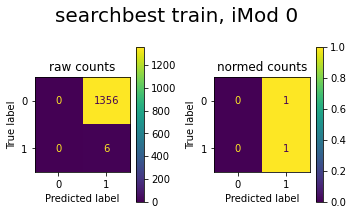

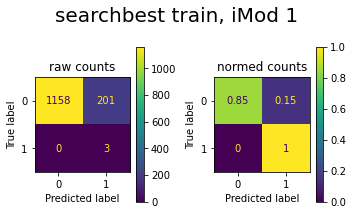

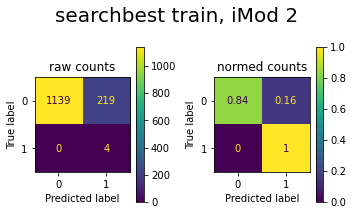

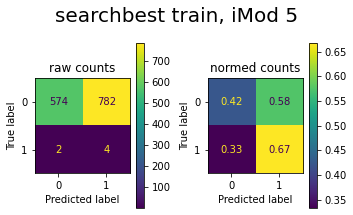

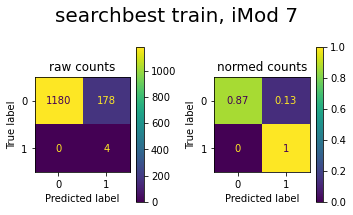

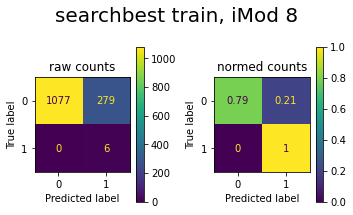

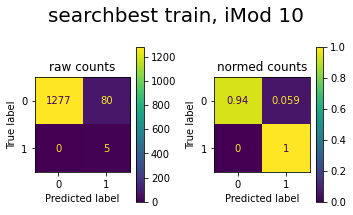

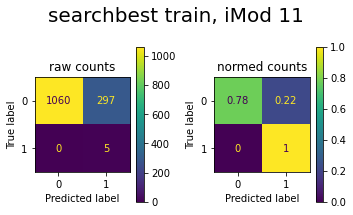

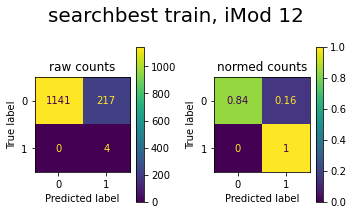

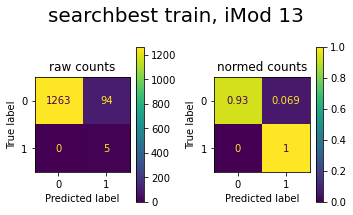

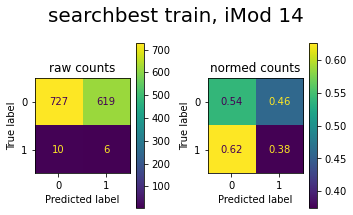

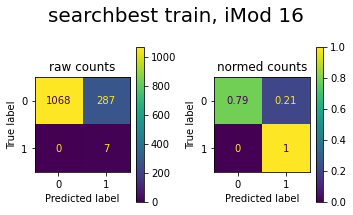

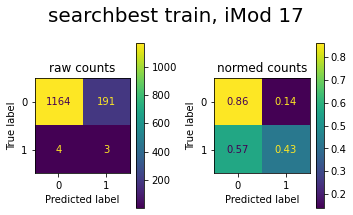

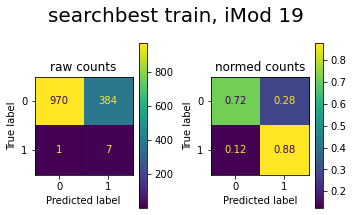

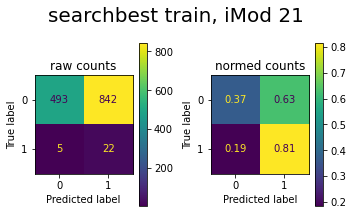

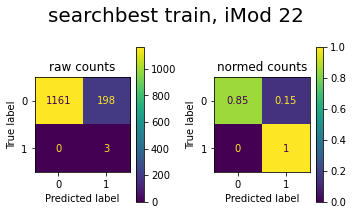

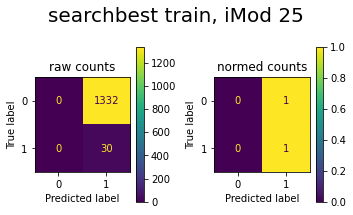

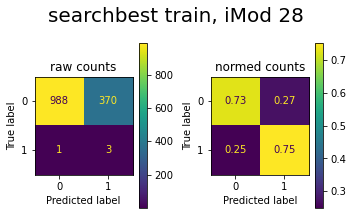

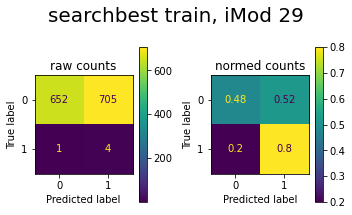

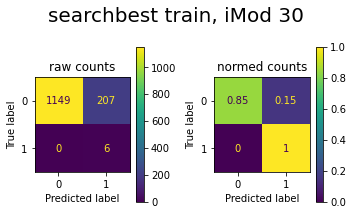

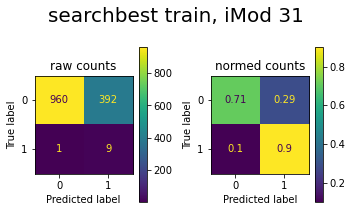

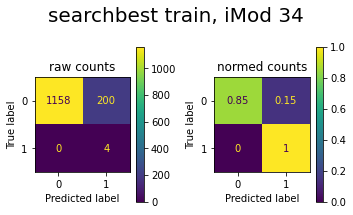

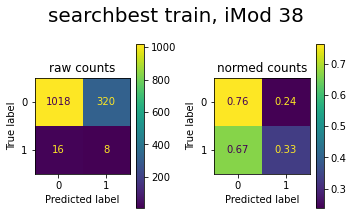

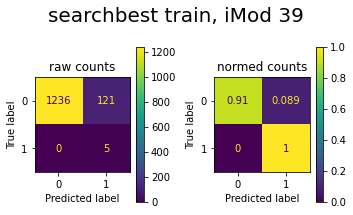

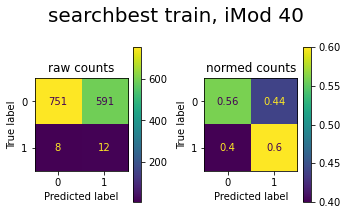

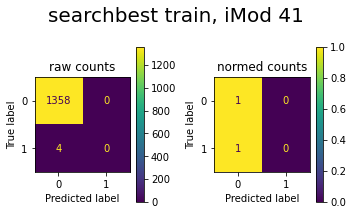

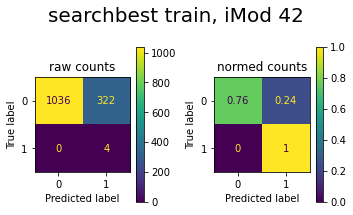

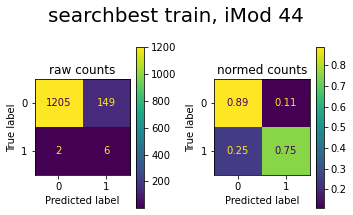

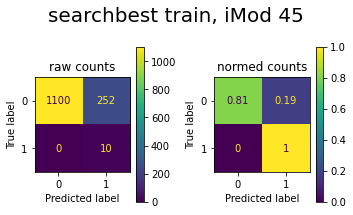

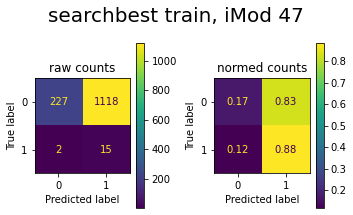

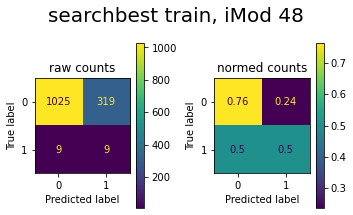

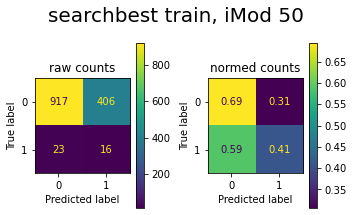

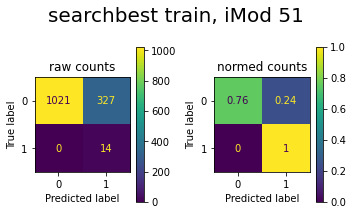

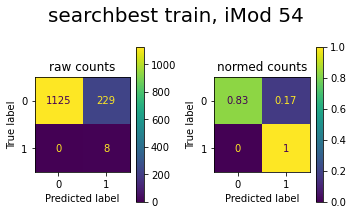

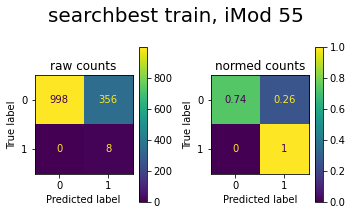

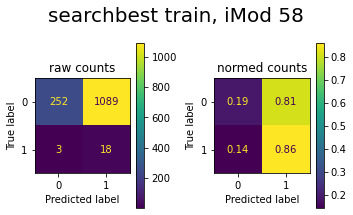

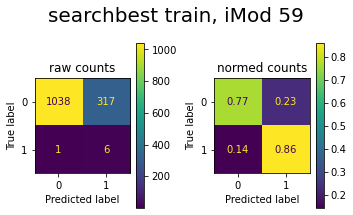

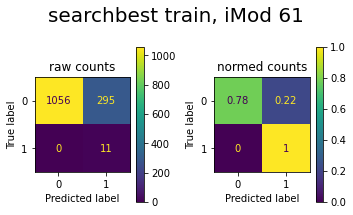

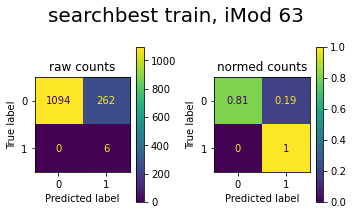

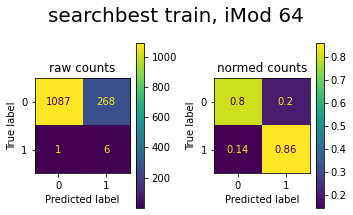

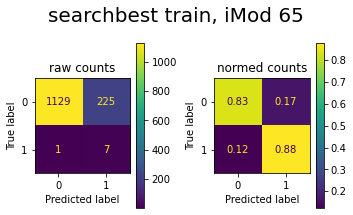

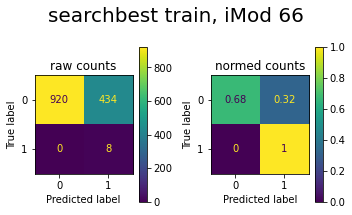

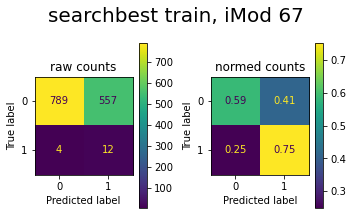

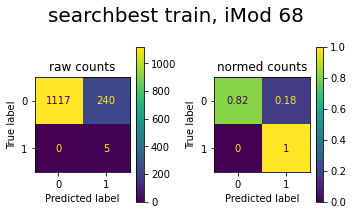

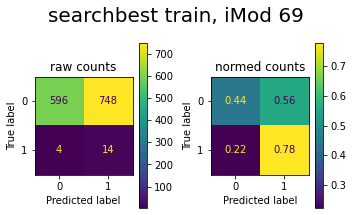

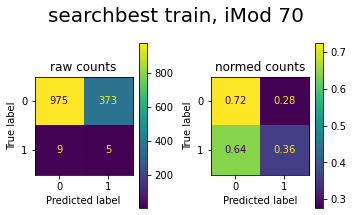

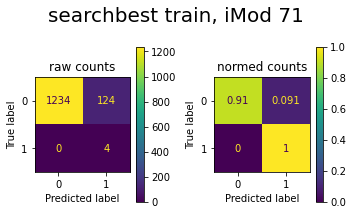

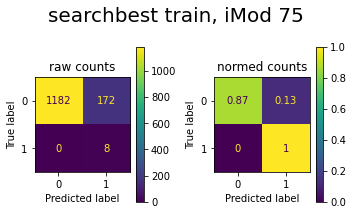

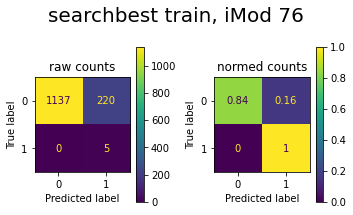

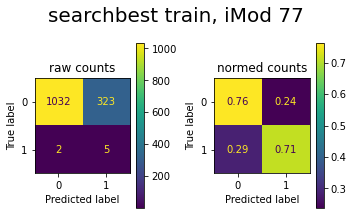

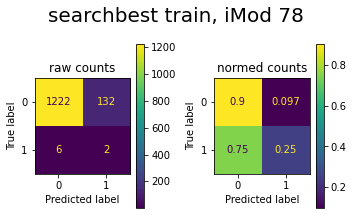

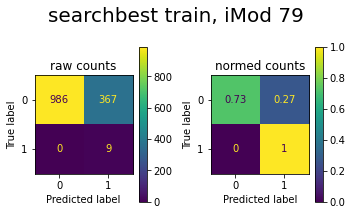

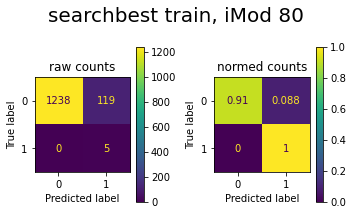

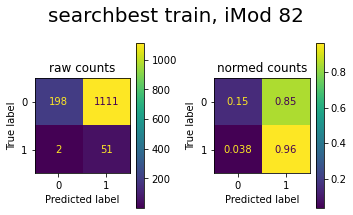

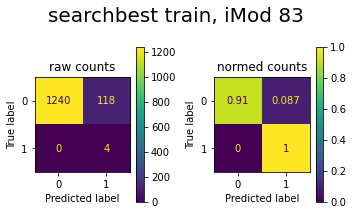

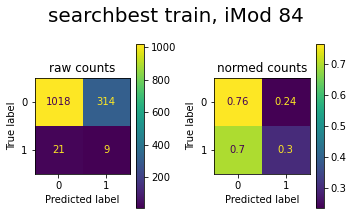

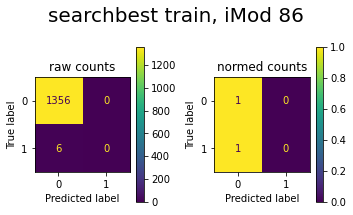

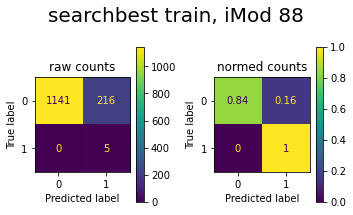

In [314]:
plot_confusion_multi([(search.best_estimator_,'searchbest train')], Xtrain_strat,ytrain_strat,imods_filt)

Running searchbest val


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in long_scalars
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


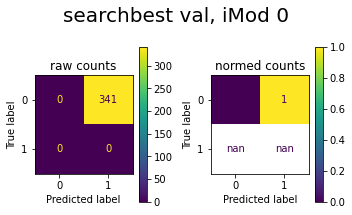

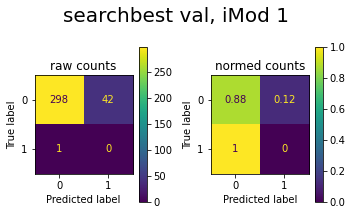

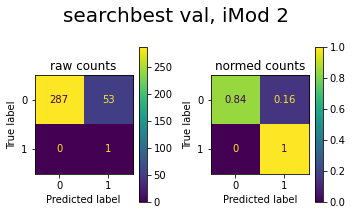

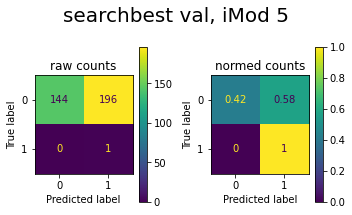

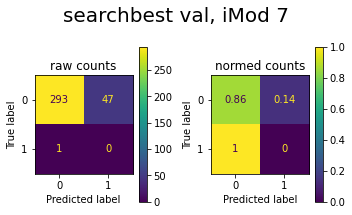

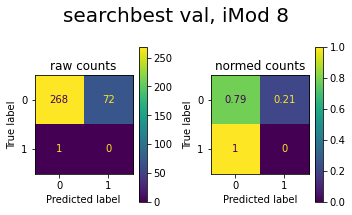

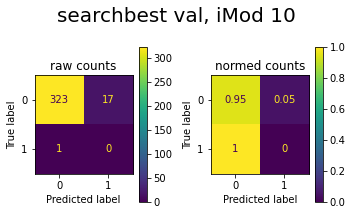

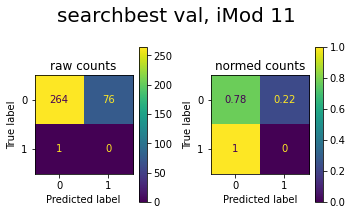

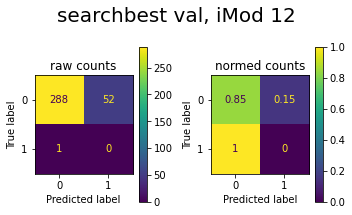

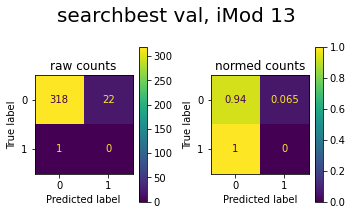

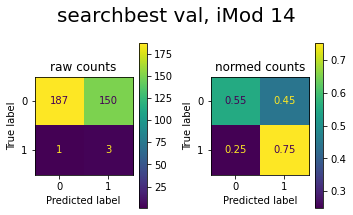

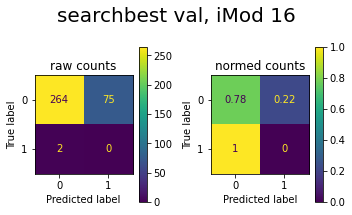

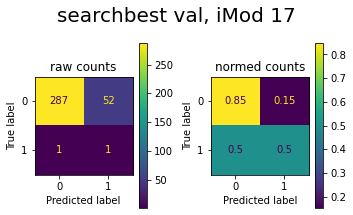

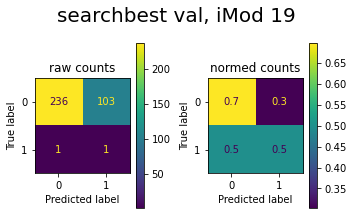

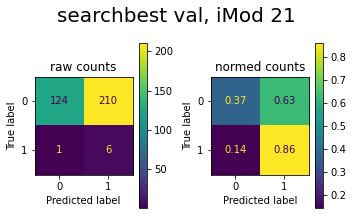

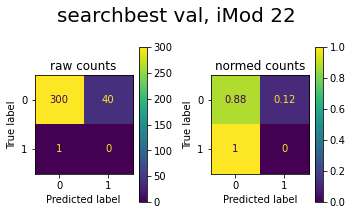

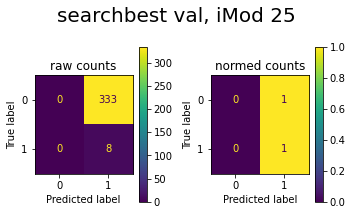

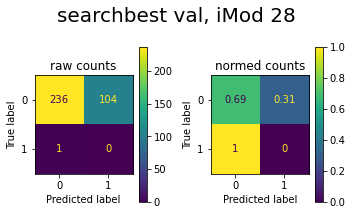

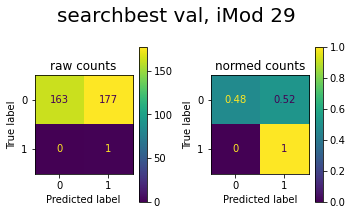

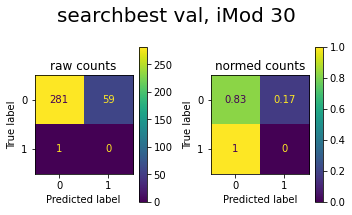

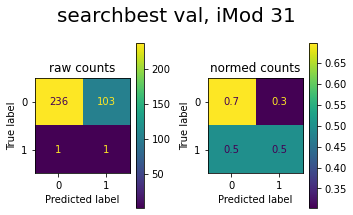

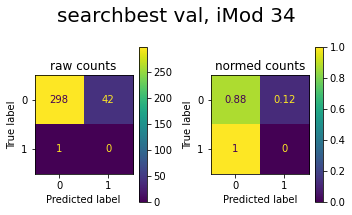

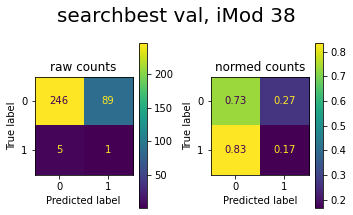

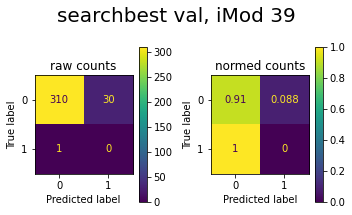

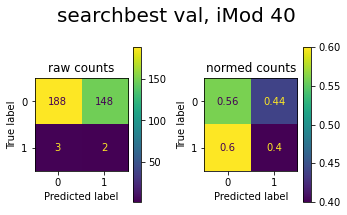

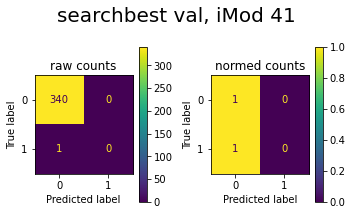

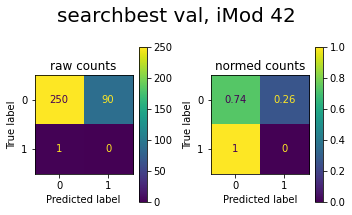

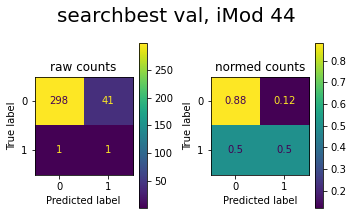

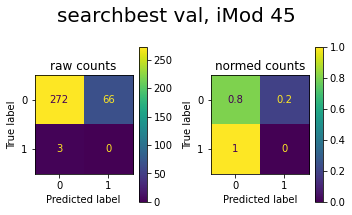

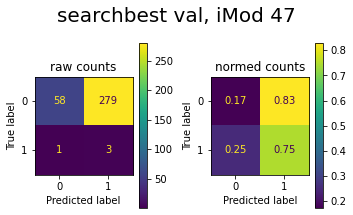

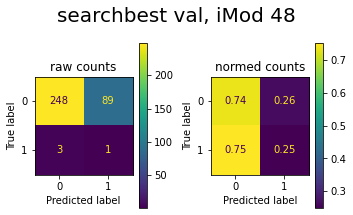

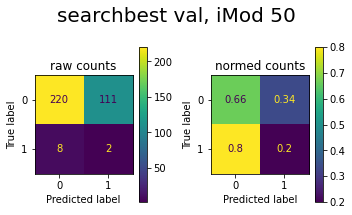

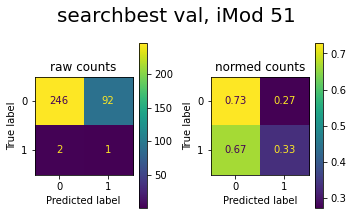

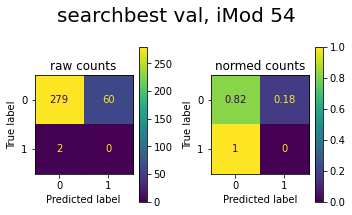

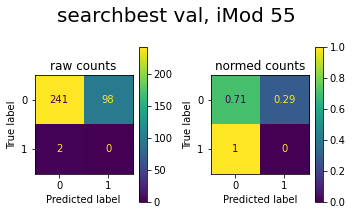

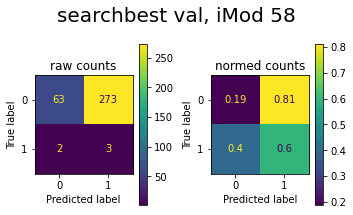

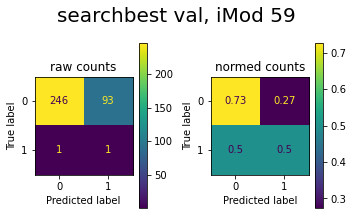

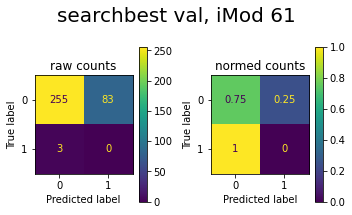

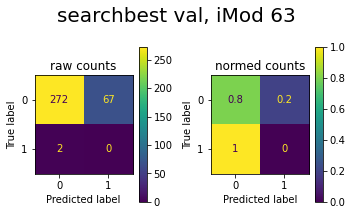

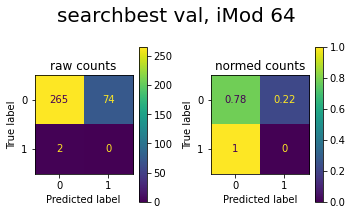

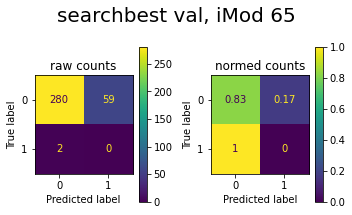

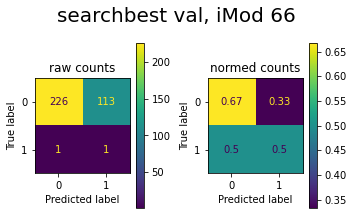

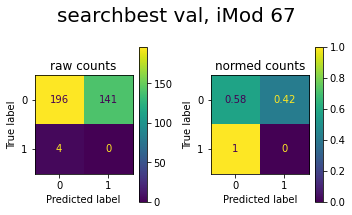

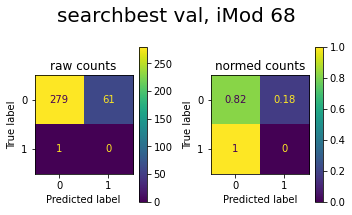

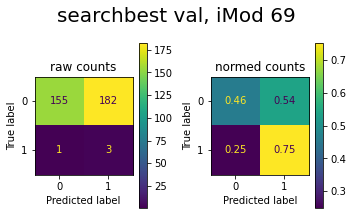

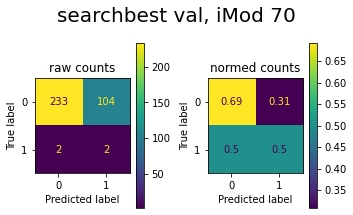

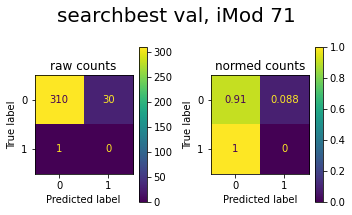

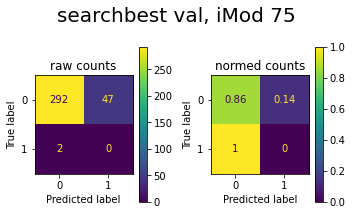

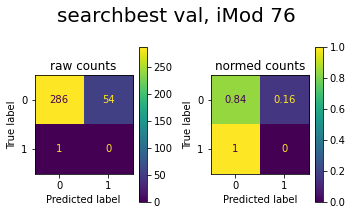

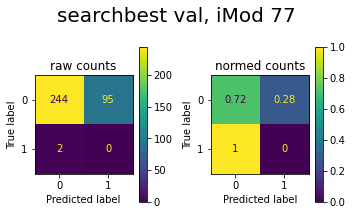

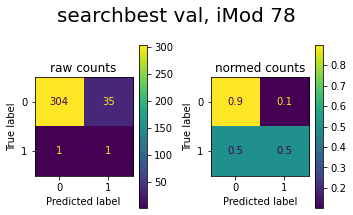

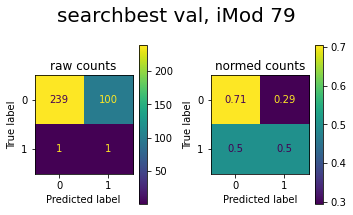

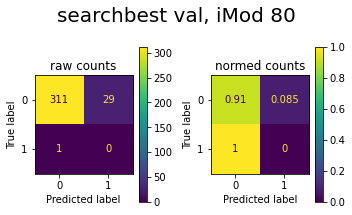

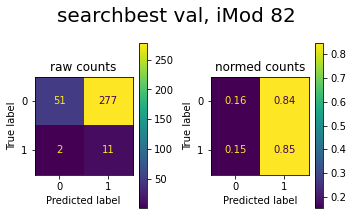

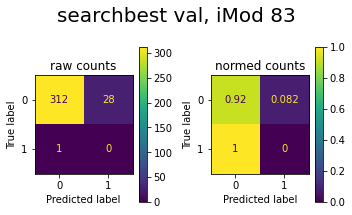

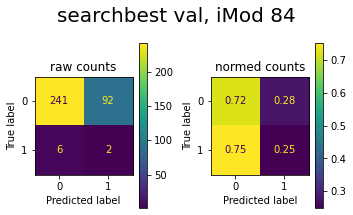

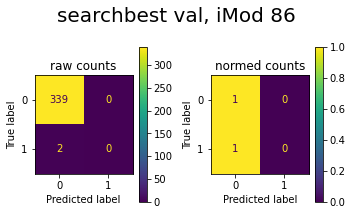

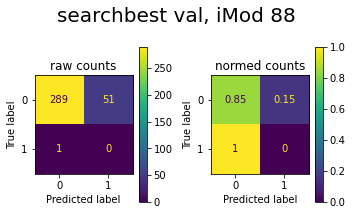

In [315]:
plot_confusion_multi([(search.best_estimator_,'searchbest val')], Xval_strat,yval_strat,imods_filt)

## try cros_val_predict

In [ ]:
# {'optimizer': torch.optim.adam.Adam,
#  'module__num_filters2': 128,
#  'module__num_filters1': 128,
#  'module__kernel_size2': 16,
#  'module__kernel_size1': 4,
#  'module__fc_node_num1': 500,
#  'module__dropout2': 0.4,
#  'module__dropout1': 0.0,
#  'module__conv_pool_size1': 4,
#  'lr': 0.01}

In [74]:
net_cvp = NeuralNetClassifier(
        m.DNA_2CNN_2FC_Multi, # my pytorch model
        criterion=torch.nn.BCEWithLogitsLoss(),
        #train_split=ValidSplit(0.2),
        #train_split=ValidSplit(k_fold.split(Xtrain_strat,ytrain_strat)),
        train_split=None,
        module__seq_len=300, # pass arg to pytorch model
        module__n_tasks=ytrain.shape[1],
        module__num_filters1=128,
        module__num_filters2=64,
        module__kernel_size1=8,
        module__kernel_size2=8,
        module__conv_pool_size1=3, 
        module__conv_pool_size2=1,
        module__fc_node_num1 = 100,
        module__fc_node_num2 = 100,
        module__dropout1 = 0.2,
        module__dropout2 = 0.2,
        max_epochs=2000,
        lr=0.01,
        device=DEVICE,
         callbacks=[
             EarlyStopping(patience=200,monitor='train_loss'),
             # suggested monitoring train loss when i want to do gridsearchcv with early stop?
             # https://github.com/skorch-dev/skorch/issues/837
             #Checkpoint(load_best=True),
             GradientNormClipping()
         ],
        optimizer=torch.optim.Adam,
        iterator_train__shuffle=True,
        #train_split=predefined_split(valid_ds)
        #train_split=None,
        verbose=1
    )

In [75]:
from sklearn.model_selection import cross_val_predict

In [76]:
y_pred = cross_val_predict(net_cvp, Xtrain_strat, ytrain_strat, cv=5)

# these instructions for using skorch with cross_val_predict don't work
# https://skorch.readthedocs.io/en/latest/user/dataset.html?highlight=fold#validsplit

# when train_split=None, then "valid loss" is not in history
# when train_split is left default, it says StratifiedCV needs a suitable y

  epoch    train_loss     dur
-------  ------------  ------
      1        0.5955  0.0902
      2        0.1069  0.0893
      3        0.0700  0.0672
      4        0.0555  0.0666
      5        0.0519  0.0659
      6        0.0500  0.0603
      7        0.0489  0.0582
      8        0.0483  0.0583
      9        0.0483  0.0579
     10        0.0482  0.0589
     11        0.0484  0.0579
     12        0.0480  0.0546
     13        0.0482  0.0576
     14        0.0481  0.0568
     15        0.0482  0.0570
     16        0.0481  0.0566
     17        0.0478  0.0570
     18        0.0479  0.0573
     19        0.0480  0.0577
     20        0.0482  0.0584
     21        0.0480  0.0583
     22        0.0474  0.0579
     23        0.0474  0.0584
     24        0.0475  0.0580
     25        0.0473  0.0587
     26        0.0475  0.0579
     27        0.0471  0.0580
     28        0.0468  0.0579
     29        0.0467  0.0580
     30        0.0475  0.0579
     31        0.0467  0.0579
     32   

    241        0.0040  0.0555
    242        0.0042  0.0554
    243        0.0048  0.0555
    244        0.0046  0.0555
    245        0.0056  0.0559
    246        0.0044  0.0558
    247        0.0041  0.0557
    248        0.0039  0.0556
    249        0.0042  0.0562
    250        0.0039  0.0563
    251        0.0050  0.0559
    252        0.0035  0.0559
    253        0.0051  0.0562
    254        0.0055  0.0564
    255        0.0051  0.0559
    256        0.0049  0.0558
    257        0.0048  0.0556
    258        0.0043  0.0556
    259        0.0032  0.0557
    260        0.0041  0.0557
    261        0.0041  0.0561
    262        0.0053  0.0556
    263        0.0037  0.0556
    264        0.0036  0.0555
    265        0.0048  0.0558
    266        0.0035  0.0559
    267        0.0043  0.0559
    268        0.0038  0.0556
    269        0.0039  0.0556
    270        0.0046  0.0557
    271        0.0048  0.0559
    272        0.0034  0.0561
    273        0.0041  0.0560
    274   

    512        0.0060  0.0582
    513        0.0043  0.0582
    514        0.0047  0.0585
    515        0.0046  0.0586
    516        0.0044  0.0578
    517        0.0053  0.0577
    518        0.0054  0.0579
    519        0.0048  0.0578
    520        0.0041  0.0576
    521        0.0032  0.0577
    522        0.0041  0.0578
    523        0.0040  0.0577
    524        0.0043  0.0577
    525        0.0036  0.0575
    526        0.0025  0.0576
    527        0.0043  0.0575
    528        0.0034  0.0576
    529        0.0039  0.0573
    530        0.0046  0.0574
    531        0.0039  0.0578
    532        0.0045  0.0575
    533        0.0029  0.0576
    534        0.0039  0.0578
    535        0.0039  0.0578
    536        0.0041  0.0576
    537        0.0043  0.0579
    538        0.0040  0.0577
    539        0.0043  0.0580
    540        0.0049  0.0576
    541        0.0033  0.0578
    542        0.0047  0.0575
    543        0.0041  0.0576
    544        0.0037  0.0579
    545   

      2        0.1280  0.0578
      3        0.0697  0.0594
      4        0.0581  0.0584
      5        0.0525  0.0580
      6        0.0507  0.0581
      7        0.0489  0.0585
      8        0.0486  0.0586
      9        0.0484  0.0581
     10        0.0486  0.0574
     11        0.0481  0.0575
     12        0.0482  0.0577
     13        0.0481  0.0576
     14        0.0482  0.0573
     15        0.0485  0.0574
     16        0.0485  0.0574
     17        0.0478  0.0576
     18        0.0482  0.0569
     19        0.0481  0.0574
     20        0.0480  0.0579
     21        0.0478  0.0576
     22        0.0475  0.0566
     23        0.0476  0.0555
     24        0.0475  0.0558
     25        0.0473  0.0559
     26        0.0474  0.0559
     27        0.0473  0.0555
     28        0.0472  0.0555
     29        0.0471  0.0557
     30        0.0468  0.0565
     31        0.0470  0.0551
     32        0.0469  0.0552
     33        0.0466  0.0551
     34        0.0467  0.0555
     35   

    242        0.0029  0.0555
    243        0.0029  0.0556
    244        0.0027  0.0556
    245        0.0029  0.0557
    246        0.0034  0.0575
    247        0.0027  0.0585
    248        0.0036  0.0589
    249        0.0029  0.0586
    250        0.0045  0.0586
    251        0.0036  0.0584
    252        0.0033  0.0584
    253        0.0038  0.0585
    254        0.0037  0.0588
    255        0.0043  0.0583
    256        0.0034  0.0582
    257        0.0040  0.0584
    258        0.0032  0.0585
    259        0.0036  0.0592
    260        0.0036  0.0593
    261        0.0031  0.0587
    262        0.0031  0.0586
    263        0.0027  0.0583
    264        0.0032  0.0579
    265        0.0025  0.0589
    266        0.0033  0.0585
    267        0.0037  0.0584
    268        0.0032  0.0582
    269        0.0038  0.0585
    270        0.0032  0.0580
    271        0.0047  0.0579
    272        0.0038  0.0571
    273        0.0037  0.0571
    274        0.0026  0.0579
    275   

    514        0.0042  0.0586
    515        0.0042  0.0590
    516        0.0031  0.0592
    517        0.0031  0.0587
    518        0.0047  0.0586
    519        0.0042  0.0583
    520        0.0038  0.0592
    521        0.0042  0.0591
    522        0.0033  0.0586
    523        0.0045  0.0587
    524        0.0041  0.0585
    525        0.0047  0.0587
    526        0.0037  0.0594
    527        0.0053  0.0584
    528        0.0041  0.0586
    529        0.0057  0.0587
    530        0.0039  0.0585
    531        0.0032  0.0586
    532        0.0023  0.0586
    533        0.0026  0.0587
    534        0.0026  0.0583
    535        0.0034  0.0589
    536        0.0038  0.0586
    537        0.0031  0.0590
    538        0.0040  0.0587
    539        0.0038  0.0584
    540        0.0027  0.0589
    541        0.0038  0.0585
    542        0.0063  0.0586
    543        0.0039  0.0587
    544        0.0051  0.0585
    545        0.0041  0.0582
    546        0.0045  0.0584
    547   

     89        0.0056  0.0551
     90        0.0052  0.0551
     91        0.0049  0.0548
     92        0.0048  0.0550
     93        0.0050  0.0545
     94        0.0044  0.0563
     95        0.0047  0.0550
     96        0.0043  0.0551
     97        0.0035  0.0552
     98        0.0034  0.0552
     99        0.0031  0.0551
    100        0.0030  0.0551
    101        0.0037  0.0552
    102        0.0028  0.0551
    103        0.0031  0.0551
    104        0.0028  0.0552
    105        0.0029  0.0551
    106        0.0033  0.0549
    107        0.0039  0.0550
    108        0.0035  0.0552
    109        0.0042  0.0556
    110        0.0036  0.0553
    111        0.0048  0.0552
    112        0.0035  0.0551
    113        0.0039  0.0551
    114        0.0031  0.0551
    115        0.0031  0.0551
    116        0.0037  0.0552
    117        0.0030  0.0546
    118        0.0026  0.0575
    119        0.0036  0.0574
    120        0.0031  0.0564
    121        0.0031  0.0561
    122   

    357        0.0020  0.0571
    358        0.0035  0.0572
    359        0.0029  0.0571
    360        0.0024  0.0572
    361        0.0021  0.0584
    362        0.0020  0.0577
    363        0.0022  0.0575
    364        0.0028  0.0577
    365        0.0036  0.0577
    366        0.0032  0.0560
    367        0.0043  0.0559
    368        0.0022  0.0560
    369        0.0033  0.0563
    370        0.0038  0.0560
    371        0.0020  0.0558
    372        0.0036  0.0557
    373        0.0049  0.0556
    374        0.0041  0.0558
    375        0.0044  0.0561
    376        0.0064  0.0560
    377        0.0059  0.0559
    378        0.0059  0.0560
    379        0.0042  0.0561
    380        0.0051  0.0558
    381        0.0052  0.0560
    382        0.0042  0.0554
    383        0.0030  0.0555
    384        0.0035  0.0554
    385        0.0041  0.0564
    386        0.0036  0.0562
    387        0.0028  0.0562
    388        0.0035  0.0559
    389        0.0036  0.0559
    390   

    190        0.0028  0.0550
    191        0.0032  0.0549
    192        0.0040  0.0550
    193        0.0034  0.0549
    194        0.0035  0.0549
    195        0.0041  0.0547
    196        0.0037  0.0547
    197        0.0040  0.0549
    198        0.0045  0.0548
    199        0.0045  0.0548
    200        0.0046  0.0549
    201        0.0044  0.0547
    202        0.0046  0.0546
    203        0.0043  0.0546
    204        0.0040  0.0547
    205        0.0040  0.0547
    206        0.0052  0.0549
    207        0.0050  0.0546
    208        0.0041  0.0548
    209        0.0034  0.0548
    210        0.0032  0.0550
    211        0.0031  0.0552
    212        0.0037  0.0550
    213        0.0037  0.0550
    214        0.0037  0.0550
    215        0.0032  0.0549
    216        0.0038  0.0550
    217        0.0042  0.0550
    218        0.0036  0.0549
    219        0.0032  0.0549
    220        0.0030  0.0548
    221        0.0039  0.0547
    222        0.0038  0.0550
    223   

    461        0.0025  0.0549
    462        0.0020  0.0549
    463        0.0019  0.0547
    464        0.0024  0.0548
    465        0.0017  0.0552
    466        0.0022  0.0554
    467        0.0028  0.0553
    468        0.0037  0.0551
    469        0.0029  0.0551
    470        0.0032  0.0550
    471        0.0034  0.0550
    472        0.0052  0.0550
    473        0.0050  0.0551
    474        0.0030  0.0551
    475        0.0040  0.0551
    476        0.0043  0.0550
    477        0.0029  0.0550
    478        0.0028  0.0549
    479        0.0032  0.0546
    480        0.0035  0.0548
    481        0.0042  0.0548
    482        0.0025  0.0549
    483        0.0037  0.0550
    484        0.0036  0.0550
    485        0.0038  0.0550
    486        0.0040  0.0548
    487        0.0035  0.0550
    488        0.0036  0.0550
    489        0.0021  0.0553
    490        0.0033  0.0552
    491        0.0029  0.0550
    492        0.0029  0.0551
    493        0.0032  0.0553
    494   

    187        0.0349  0.0550
    188        0.0349  0.0550
    189        0.0349  0.0551
    190        0.0349  0.0550
    191        0.0351  0.0551
    192        0.0349  0.0551
    193        0.0351  0.0552
    194        0.0350  0.0551
    195        0.0350  0.0549
    196        0.0350  0.0550
    197        0.0349  0.0556
    198        0.0348  0.0554
    199        0.0350  0.0557
    200        0.0350  0.0553
    201        0.0349  0.0550
    202        0.0349  0.0550
    203        0.0349  0.0549
    204        0.0349  0.0548
    205        0.0349  0.0549
    206        0.0349  0.0550
    207        0.0350  0.0549
    208        0.0349  0.0547
    209        0.0349  0.0551
    210        0.0349  0.0550
    211        0.0349  0.0552
    212        0.0348  0.0551
    213        0.0348  0.0549
    214        0.0349  0.0550
    215        0.0348  0.0548
    216        0.0349  0.0548
    217        0.0349  0.0548
Stopping since train_loss has not improved in the last 200 epochs.


In [77]:
netts = [
    #(search.best_estimator_,'ec-best_oldarch'),
    (net_cvp, 'manual cvp?')
]

sk_loss_plot(netts)

# errors because cross_val_predict doesn't actually train the model...?

TypeError: 'NoneType' object is not subscriptable

<Figure size 720x360 with 0 Axes>

In [78]:
net_cvp

<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class 'models.DNA_2CNN_2FC_Multi'>,
  module__conv_pool_size1=3,
  module__conv_pool_size2=1,
  module__dropout1=0.2,
  module__dropout2=0.2,
  module__fc_node_num1=100,
  module__fc_node_num2=100,
  module__kernel_size1=8,
  module__kernel_size2=8,
  module__n_tasks=58,
  module__num_filters1=128,
  module__num_filters2=64,
  module__seq_len=300,
)

In [79]:
y_pred

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [80]:
def view_cls_report2(yt,yp,imods):
    '''
    For a given model and set of X,y examples, save and display 
    a summary of the primary classification metrics
    '''
    # get the classification report
    cls_rep = classification_report(yt, yp,target_names=imods,output_dict=True)
    
    # conver the dict into a df for viewing
    cls_df = pd.DataFrame.from_dict(cls_rep,orient='index')
    cls_df.index.name='imod'
    cls_df = cls_df.reset_index()
    
    # drop the micro/macro average colums
    cls_df = cls_df.drop(cls_df[~cls_df['imod'].isin(imods)].index)
    # convert to int for sorting
    cls_df['imod'] = cls_df['imod'].apply(lambda x: int(x))
    
    # melt the df for altair
    cls_melt = cls_df.melt(
        id_vars=['imod','support'],
        value_vars=['precision','recall','f1-score'],
        var_name='metric',
        value_name='score')
    
    #alt_cls_summary(cls_melt)
    display(alt_cls_summary2(cls_melt))

    return cls_df

In [81]:
# from cross_val_predict preds
view_cls_report2(ytrain_strat,y_pred,imods_filt)

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


alt.VConcatChart(...)

imod  precision  recall  f1-score  support
0      0        0.0     0.0       0.0        6
1      1        0.0     0.0       0.0        3
2      2        0.0     0.0       0.0        4
3      5        0.0     0.0       0.0        6
4      7        0.0     0.0       0.0        4
5      8        0.0     0.0       0.0        6
6     10        0.0     0.0       0.0        5
7     11        0.0     0.0       0.0        5
8     12        0.0     0.0       0.0        4
9     13        0.0     0.0       0.0        5
10    14        0.0     0.0       0.0       16
11    16        0.0     0.0       0.0        7
12    17        0.0     0.0       0.0        7
13    19        0.0     0.0       0.0        8
14    21        0.0     0.0       0.0       27
15    22        0.0     0.0       0.0        3
16    25        0.0     0.0       0.0       30
17    28        0.0     0.0       0.0        4
18    29        0.0     0.0       0.0        5
19    30        0.0     0.0       0.0        6
20    31        0.0     0.0       0.0       10
21    34        0.0     0.0       0.0        4
22    38        0.0     0.0       0.0       24
23    39        0.0     0.0       0.0        5
24    40        0.0     0.0       0.0       20
25    41        0.0     0.0       0.0        4
26    42        0.0     0.0       0.0        4
27    44        0.0     0.0       0.0        8
28    45        0.0     0.0       0.0       10
29    47        0.0     0.0       0.0       17
30    48        0.0     0.0       0.0       18
31    50        0.0     0.0       0.0       39
32    51        0.0     0.0       0.0       14
33    54        0.0     0.0       0.0        8
34    55        0.0     0.0       0.0        8
35    58        0.0     0.0       0.0       21
36    59        0.0     0.0       0.0        7
37    61        0.0     0.0       0.0       11
38    63        0.0     0.0       0.0        6
39    64        0.0     0.0       0.0        7
40    65        0.0     0.0       0.0        8
41    66        0.0     0.0       0.0        8
42    67        0.0     0.0       0.0       16
43    68        0.0     0.0       0.0        5
44    69        0.0     0.0       0.0       18
45    70        0.0     0.0       0.0       14
46    71        0.0     0.0       0.0        4
47    75        0.0     0.0       0.0        8
48    76        0.0     0.0       0.0        5
49    77        0.0     0.0       0.0        7
50    78        0.0     0.0       0.0        8
51    79        0.0     0.0       0.0        9
52    80        0.0     0.0       0.0        5
53    82        0.0     0.0       0.0       53
54    83        0.0     0.0       0.0        4
55    84        0.0     0.0       0.0       30
56    86        0.0     0.0       0.0        6
57    88        0.0     0.0       0.0        5

YTRUE torch.Size([1362, 92])
**** ave r2:     -0.0005887257365900982
**** r2 overall: -0.0005887258745234803
YTRUE torch.Size([341, 92])
**** ave r2:     -0.0030626685740936716
**** r2 overall: -0.003062669608321528


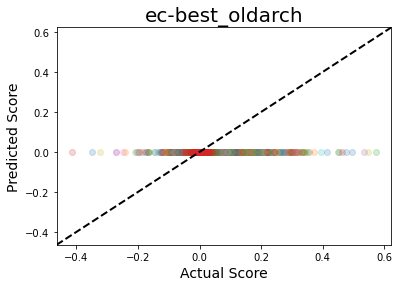

NotInitializedError: This NeuralNetRegressor instance is not initialized yet. Call 'initialize' or 'fit' with appropriate arguments before using this method.

In [60]:
view_preds(nets,make_legend=False)

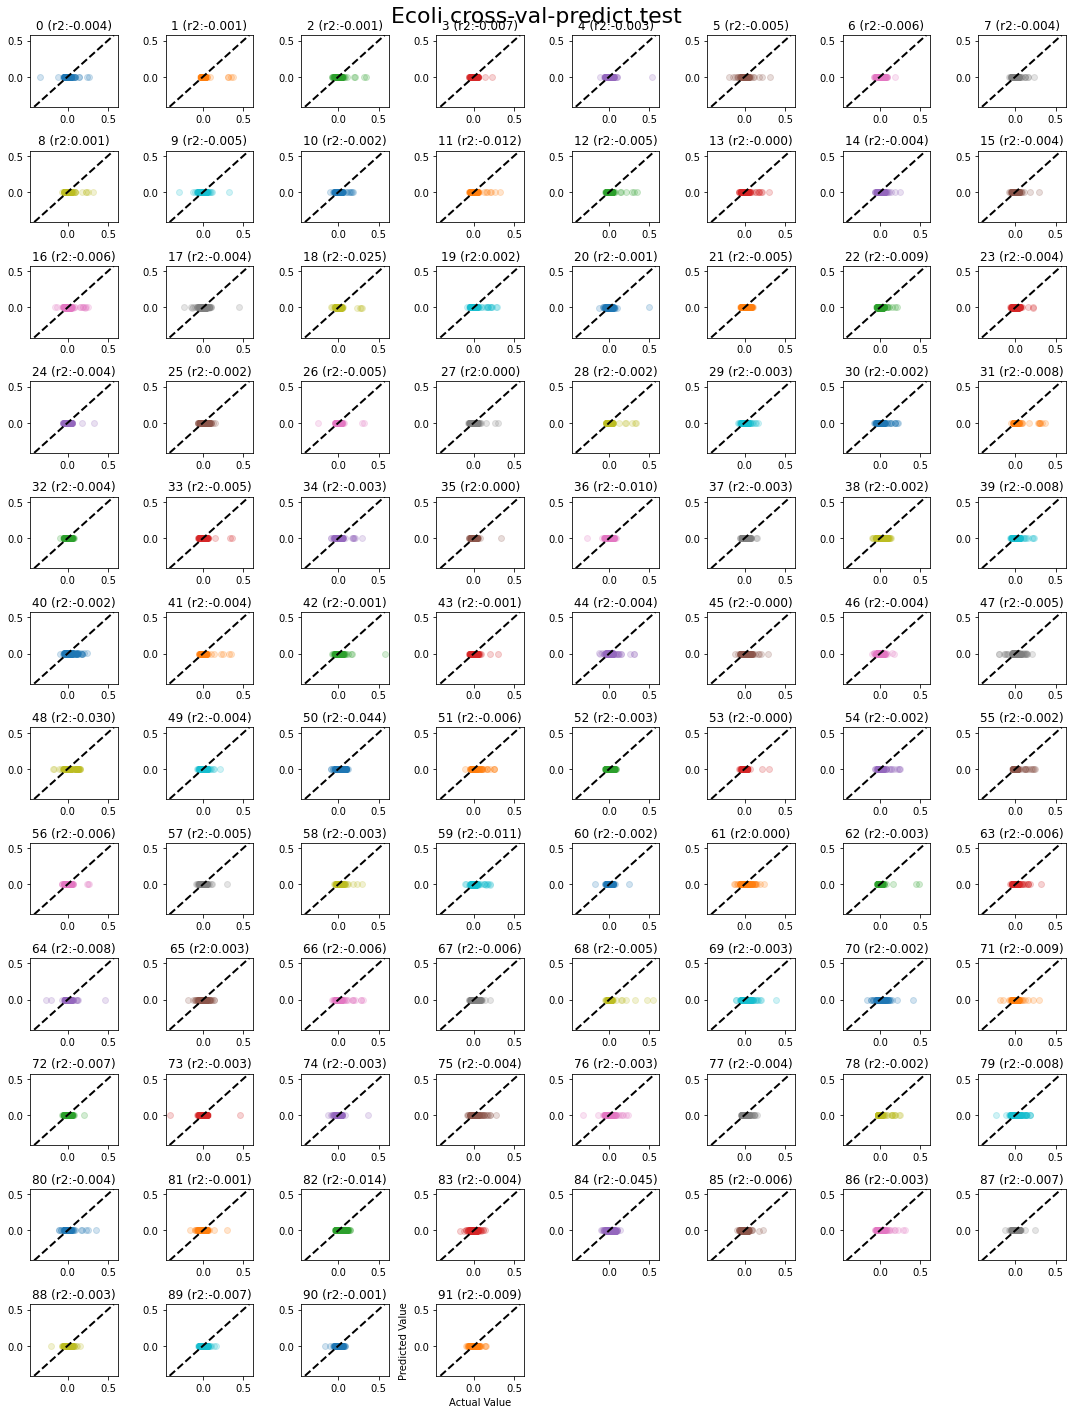

In [61]:
view_multi_parity("Ecoli cross-val-predict test", 
    y, 
    y_pred,
    rigid=True)

# Next ideas
* Retry with data aug 
* gradient clipping


# NOTE: 
--> using "load_best" = True seems to work now?? Stops on the final one